In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image


from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'ASETRI'
    elif x == 1:
        return 'EPTBOT'
    elif x == 2:
        return 'MYOEMA'
    elif x == 3:
        return 'PIPKUH'
    elif x == 4:
        return 'RHIMUS'
    elif x == 5:
        return 'RHYNAS'
    elif x == 6:
        return 'ROUAEG'
    elif x == 7:
        return 'TAPPER'
    else:
        return 'Unknown'

In [4]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1799
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((341, 224)) 
    spectrogram = np.array(spectrogram) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    
# print(X_all)
# print(Y_all)
# # plt.imshow(X_all[0])


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 

# print(X_all)
# print(Y_all)

(3193, 224, 341, 3)
(3193,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)



<h2>Model Building</h2>

In [8]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))(mpool)


        c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))(mpool)

        c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)
        #bt = LeakyReLU(alpha=0.01)(bt)
        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        f = Flatten()(mpool)

        x_dense = Dense(2048)(f)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.4)(bt)


        x_dense = Dense(1024)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.3)(bt)

        x_dense = Dense(512)(bt)
        bt = BatchNormalization()(x_dense)
        bt = Activation('relu')(bt)
        bt = Dropout(0.2)(bt)

        x_out = Dense(8, name='output', activation='softmax')(bt)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(
                lr=hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [9]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(224,341,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=1,
    directory='random_search',
    project_name='bat'
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.1, batch_size=8)

Train on 2298 samples, validate on 256 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 7:02 - loss: 2.5198 - acc: 0.0000e+0 - ETA: 2:26 - loss: 2.3543 - acc: 0.1250    - ETA: 1:31 - loss: 2.3040 - acc: 0.100 - ETA: 1:07 - loss: 2.1921 - acc: 0.160 - ETA: 54s - loss: 2.2505 - acc: 0.166 - ETA: 45s - loss: 2.1578 - acc: 0.19 - ETA: 39s - loss: 2.1171 - acc: 0.21 - ETA: 35s - loss: 2.0722 - acc: 0.23 - ETA: 32s - loss: 2.0339 - acc: 0.25 - ETA: 29s - loss: 1.9668 - acc: 0.28 - ETA: 27s - loss: 1.8982 - acc: 0.30 - ETA: 25s - loss: 1.8477 - acc: 0.34 - ETA: 24s - loss: 1.8444 - acc: 0.34 - ETA: 22s - loss: 1.8652 - acc: 0.34 - ETA: 21s - loss: 1.8407 - acc: 0.35 - ETA: 20s - loss: 1.8227 - acc: 0.35 - ETA: 19s - loss: 1.8402 - acc: 0.35 - ETA: 19s - loss: 1.8479 - acc: 0.36 - ETA: 18s - loss: 1.8150 - acc: 0.38 - ETA: 17s - loss: 1.8231 - acc: 0.39 - ETA: 17s - loss: 1.8184 - acc: 0.39 - ETA: 16s - loss: 1.7876 - acc: 0.40 - ETA: 16s - loss: 1.7796 - acc: 0.41 - ETA: 1

2298/2298 [==============================] - ETA: 9s - loss: 1.1702 - acc: 0.375 - ETA: 9s - loss: 1.5040 - acc: 0.416 - ETA: 9s - loss: 1.3785 - acc: 0.525 - ETA: 9s - loss: 1.3447 - acc: 0.553 - ETA: 9s - loss: 1.3867 - acc: 0.527 - ETA: 9s - loss: 1.5332 - acc: 0.488 - ETA: 9s - loss: 1.5342 - acc: 0.490 - ETA: 9s - loss: 1.6036 - acc: 0.466 - ETA: 9s - loss: 1.5668 - acc: 0.477 - ETA: 9s - loss: 1.5399 - acc: 0.473 - ETA: 9s - loss: 1.5202 - acc: 0.482 - ETA: 9s - loss: 1.5723 - acc: 0.467 - ETA: 8s - loss: 1.5625 - acc: 0.470 - ETA: 8s - loss: 1.5523 - acc: 0.476 - ETA: 8s - loss: 1.5298 - acc: 0.487 - ETA: 8s - loss: 1.5175 - acc: 0.487 - ETA: 8s - loss: 1.5026 - acc: 0.488 - ETA: 8s - loss: 1.5151 - acc: 0.478 - ETA: 8s - loss: 1.5031 - acc: 0.486 - ETA: 8s - loss: 1.5122 - acc: 0.477 - ETA: 8s - loss: 1.5219 - acc: 0.478 - ETA: 8s - loss: 1.5060 - acc: 0.482 - ETA: 8s - loss: 1.4796 - acc: 0.494 - ETA: 8s - loss: 1.4934 - acc: 0.489 - ETA: 8s - loss: 1.4909 - acc: 0.492 - ETA: 

2298/2298 [==============================] - ETA: 9s - loss: 1.5954 - acc: 0.500 - ETA: 9s - loss: 1.4932 - acc: 0.541 - ETA: 9s - loss: 1.5991 - acc: 0.475 - ETA: 9s - loss: 1.6563 - acc: 0.482 - ETA: 9s - loss: 1.5860 - acc: 0.527 - ETA: 9s - loss: 1.6025 - acc: 0.511 - ETA: 9s - loss: 1.5250 - acc: 0.538 - ETA: 9s - loss: 1.4734 - acc: 0.541 - ETA: 9s - loss: 1.4475 - acc: 0.558 - ETA: 9s - loss: 1.4594 - acc: 0.552 - ETA: 9s - loss: 1.4698 - acc: 0.553 - ETA: 9s - loss: 1.4562 - acc: 0.538 - ETA: 9s - loss: 1.4317 - acc: 0.550 - ETA: 9s - loss: 1.3849 - acc: 0.574 - ETA: 8s - loss: 1.3991 - acc: 0.569 - ETA: 8s - loss: 1.4104 - acc: 0.564 - ETA: 8s - loss: 1.4012 - acc: 0.568 - ETA: 8s - loss: 1.3858 - acc: 0.567 - ETA: 8s - loss: 1.3645 - acc: 0.570 - ETA: 8s - loss: 1.3549 - acc: 0.573 - ETA: 8s - loss: 1.3585 - acc: 0.570 - ETA: 8s - loss: 1.3425 - acc: 0.569 - ETA: 8s - loss: 1.3522 - acc: 0.563 - ETA: 8s - loss: 1.3460 - acc: 0.563 - ETA: 8s - loss: 1.3396 - acc: 0.568 - ETA: 

2298/2298 [==============================] - ETA: 12s - loss: 1.8508 - acc: 0.50 - ETA: 11s - loss: 1.8371 - acc: 0.50 - ETA: 10s - loss: 1.5894 - acc: 0.50 - ETA: 10s - loss: 1.5473 - acc: 0.50 - ETA: 10s - loss: 1.4967 - acc: 0.50 - ETA: 9s - loss: 1.5173 - acc: 0.4886 - ETA: 9s - loss: 1.5843 - acc: 0.528 - ETA: 9s - loss: 1.6356 - acc: 0.525 - ETA: 9s - loss: 1.5676 - acc: 0.536 - ETA: 9s - loss: 1.5822 - acc: 0.513 - ETA: 9s - loss: 1.5490 - acc: 0.529 - ETA: 9s - loss: 1.5237 - acc: 0.532 - ETA: 9s - loss: 1.5097 - acc: 0.530 - ETA: 9s - loss: 1.5162 - acc: 0.527 - ETA: 9s - loss: 1.5590 - acc: 0.517 - ETA: 9s - loss: 1.5470 - acc: 0.516 - ETA: 8s - loss: 1.5474 - acc: 0.503 - ETA: 8s - loss: 1.5500 - acc: 0.507 - ETA: 8s - loss: 1.5195 - acc: 0.520 - ETA: 8s - loss: 1.4987 - acc: 0.522 - ETA: 8s - loss: 1.4954 - acc: 0.524 - ETA: 8s - loss: 1.4843 - acc: 0.529 - ETA: 8s - loss: 1.4799 - acc: 0.527 - ETA: 8s - loss: 1.4712 - acc: 0.529 - ETA: 8s - loss: 1.4630 - acc: 0.530 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.9462 - acc: 0.750 - ETA: 9s - loss: 1.6051 - acc: 0.583 - ETA: 9s - loss: 1.4456 - acc: 0.625 - ETA: 9s - loss: 1.4067 - acc: 0.589 - ETA: 9s - loss: 1.4342 - acc: 0.583 - ETA: 9s - loss: 1.4242 - acc: 0.545 - ETA: 9s - loss: 1.4090 - acc: 0.538 - ETA: 9s - loss: 1.3998 - acc: 0.541 - ETA: 9s - loss: 1.3805 - acc: 0.544 - ETA: 9s - loss: 1.3661 - acc: 0.559 - ETA: 9s - loss: 1.2995 - acc: 0.577 - ETA: 9s - loss: 1.3030 - acc: 0.570 - ETA: 9s - loss: 1.3007 - acc: 0.575 - ETA: 9s - loss: 1.3281 - acc: 0.569 - ETA: 9s - loss: 1.3092 - acc: 0.581 - ETA: 8s - loss: 1.2976 - acc: 0.588 - ETA: 8s - loss: 1.3441 - acc: 0.568 - ETA: 8s - loss: 1.3492 - acc: 0.567 - ETA: 8s - loss: 1.3910 - acc: 0.557 - ETA: 8s - loss: 1.3771 - acc: 0.557 - ETA: 8s - loss: 1.3582 - acc: 0.564 - ETA: 8s - loss: 1.3642 - acc: 0.561 - ETA: 8s - loss: 1.3320 - acc: 0.569 - ETA: 8s - loss: 1.3235 - acc: 0.566 - ETA: 8s - loss: 1.3462 - acc: 0.561 - ETA: 

2298/2298 [==============================] - ETA: 9s - loss: 1.3994 - acc: 0.250 - ETA: 9s - loss: 1.4564 - acc: 0.333 - ETA: 9s - loss: 1.2512 - acc: 0.425 - ETA: 9s - loss: 1.2547 - acc: 0.482 - ETA: 9s - loss: 1.1895 - acc: 0.513 - ETA: 9s - loss: 1.1363 - acc: 0.534 - ETA: 9s - loss: 1.1957 - acc: 0.538 - ETA: 9s - loss: 1.2138 - acc: 0.525 - ETA: 9s - loss: 1.1957 - acc: 0.536 - ETA: 9s - loss: 1.2041 - acc: 0.546 - ETA: 9s - loss: 1.2154 - acc: 0.547 - ETA: 9s - loss: 1.1973 - acc: 0.554 - ETA: 9s - loss: 1.2315 - acc: 0.555 - ETA: 9s - loss: 1.2081 - acc: 0.564 - ETA: 9s - loss: 1.1953 - acc: 0.573 - ETA: 9s - loss: 1.2209 - acc: 0.568 - ETA: 8s - loss: 1.2138 - acc: 0.575 - ETA: 8s - loss: 1.2098 - acc: 0.582 - ETA: 8s - loss: 1.2132 - acc: 0.581 - ETA: 8s - loss: 1.2463 - acc: 0.576 - ETA: 8s - loss: 1.2556 - acc: 0.573 - ETA: 8s - loss: 1.2566 - acc: 0.575 - ETA: 8s - loss: 1.2523 - acc: 0.580 - ETA: 8s - loss: 1.2364 - acc: 0.587 - ETA: 8s - loss: 1.2479 - acc: 0.586 - ETA: 

2298/2298 [==============================] - ETA: 12s - loss: 1.5949 - acc: 0.37 - ETA: 12s - loss: 1.3760 - acc: 0.50 - ETA: 11s - loss: 1.2746 - acc: 0.52 - ETA: 10s - loss: 1.1313 - acc: 0.57 - ETA: 10s - loss: 1.2511 - acc: 0.54 - ETA: 10s - loss: 1.2946 - acc: 0.54 - ETA: 10s - loss: 1.2131 - acc: 0.57 - ETA: 10s - loss: 1.2435 - acc: 0.59 - ETA: 9s - loss: 1.2452 - acc: 0.5809 - ETA: 9s - loss: 1.2184 - acc: 0.598 - ETA: 9s - loss: 1.2263 - acc: 0.589 - ETA: 9s - loss: 1.2163 - acc: 0.592 - ETA: 9s - loss: 1.1744 - acc: 0.610 - ETA: 9s - loss: 1.1378 - acc: 0.625 - ETA: 9s - loss: 1.1156 - acc: 0.625 - ETA: 9s - loss: 1.1052 - acc: 0.633 - ETA: 9s - loss: 1.0845 - acc: 0.640 - ETA: 9s - loss: 1.1143 - acc: 0.635 - ETA: 9s - loss: 1.1540 - acc: 0.628 - ETA: 8s - loss: 1.1880 - acc: 0.612 - ETA: 8s - loss: 1.1903 - acc: 0.615 - ETA: 8s - loss: 1.2159 - acc: 0.610 - ETA: 8s - loss: 1.2151 - acc: 0.613 - ETA: 8s - loss: 1.2323 - acc: 0.606 - ETA: 8s - loss: 1.2244 - acc: 0.604 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 2.0530 - acc: 0.12 - ETA: 11s - loss: 1.5504 - acc: 0.41 - ETA: 11s - loss: 1.3923 - acc: 0.52 - ETA: 10s - loss: 1.2438 - acc: 0.55 - ETA: 10s - loss: 1.3839 - acc: 0.51 - ETA: 10s - loss: 1.3580 - acc: 0.52 - ETA: 10s - loss: 1.2925 - acc: 0.54 - ETA: 10s - loss: 1.2587 - acc: 0.55 - ETA: 9s - loss: 1.1889 - acc: 0.5882 - ETA: 9s - loss: 1.1637 - acc: 0.592 - ETA: 9s - loss: 1.2279 - acc: 0.577 - ETA: 9s - loss: 1.1969 - acc: 0.587 - ETA: 9s - loss: 1.2088 - acc: 0.585 - ETA: 9s - loss: 1.1909 - acc: 0.588 - ETA: 9s - loss: 1.1717 - acc: 0.594 - ETA: 9s - loss: 1.1582 - acc: 0.596 - ETA: 9s - loss: 1.1957 - acc: 0.587 - ETA: 9s - loss: 1.2139 - acc: 0.578 - ETA: 9s - loss: 1.2013 - acc: 0.577 - ETA: 9s - loss: 1.1807 - acc: 0.589 - ETA: 8s - loss: 1.1919 - acc: 0.588 - ETA: 8s - loss: 1.1888 - acc: 0.590 - ETA: 8s - loss: 1.1936 - acc: 0.586 - ETA: 8s - loss: 1.1998 - acc: 0.585 - ETA: 8s - loss: 1.1845 - acc: 0.594 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.3293 - acc: 0.50 - ETA: 11s - loss: 1.4999 - acc: 0.45 - ETA: 11s - loss: 1.2308 - acc: 0.57 - ETA: 10s - loss: 1.2602 - acc: 0.58 - ETA: 10s - loss: 1.3240 - acc: 0.55 - ETA: 10s - loss: 1.2712 - acc: 0.57 - ETA: 10s - loss: 1.2359 - acc: 0.58 - ETA: 10s - loss: 1.2372 - acc: 0.60 - ETA: 10s - loss: 1.2656 - acc: 0.58 - ETA: 9s - loss: 1.2642 - acc: 0.5855 - ETA: 9s - loss: 1.2185 - acc: 0.607 - ETA: 9s - loss: 1.1756 - acc: 0.625 - ETA: 9s - loss: 1.1708 - acc: 0.625 - ETA: 9s - loss: 1.1584 - acc: 0.620 - ETA: 9s - loss: 1.1523 - acc: 0.620 - ETA: 9s - loss: 1.1320 - acc: 0.625 - ETA: 9s - loss: 1.2072 - acc: 0.598 - ETA: 9s - loss: 1.2036 - acc: 0.600 - ETA: 9s - loss: 1.2174 - acc: 0.598 - ETA: 9s - loss: 1.2194 - acc: 0.596 - ETA: 8s - loss: 1.2114 - acc: 0.603 - ETA: 8s - loss: 1.2132 - acc: 0.604 - ETA: 8s - loss: 1.2124 - acc: 0.602 - ETA: 8s - loss: 1.2015 - acc: 0.606 - ETA: 8s - loss: 1.2019 - acc: 0.604 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8383 - acc: 0.75 - ETA: 12s - loss: 0.9742 - acc: 0.62 - ETA: 11s - loss: 1.0323 - acc: 0.60 - ETA: 11s - loss: 1.1698 - acc: 0.57 - ETA: 10s - loss: 1.1237 - acc: 0.58 - ETA: 10s - loss: 1.1391 - acc: 0.60 - ETA: 10s - loss: 1.1178 - acc: 0.61 - ETA: 10s - loss: 1.1799 - acc: 0.61 - ETA: 10s - loss: 1.1554 - acc: 0.62 - ETA: 10s - loss: 1.1321 - acc: 0.63 - ETA: 9s - loss: 1.1110 - acc: 0.6429 - ETA: 9s - loss: 1.1173 - acc: 0.641 - ETA: 9s - loss: 1.1255 - acc: 0.630 - ETA: 9s - loss: 1.1256 - acc: 0.629 - ETA: 9s - loss: 1.1405 - acc: 0.625 - ETA: 9s - loss: 1.1416 - acc: 0.625 - ETA: 9s - loss: 1.1317 - acc: 0.628 - ETA: 9s - loss: 1.1322 - acc: 0.632 - ETA: 9s - loss: 1.1282 - acc: 0.635 - ETA: 9s - loss: 1.1462 - acc: 0.625 - ETA: 9s - loss: 1.1649 - acc: 0.615 - ETA: 8s - loss: 1.1608 - acc: 0.616 - ETA: 8s - loss: 1.1988 - acc: 0.602 - ETA: 8s - loss: 1.2024 - acc: 0.598 - ETA: 8s - loss: 1.2192 - acc: 0.596 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.9656 - acc: 0.62 - ETA: 11s - loss: 1.1094 - acc: 0.62 - ETA: 11s - loss: 1.0876 - acc: 0.60 - ETA: 10s - loss: 1.0373 - acc: 0.58 - ETA: 10s - loss: 1.0982 - acc: 0.56 - ETA: 10s - loss: 1.1906 - acc: 0.56 - ETA: 10s - loss: 1.1593 - acc: 0.57 - ETA: 10s - loss: 1.2037 - acc: 0.55 - ETA: 9s - loss: 1.2177 - acc: 0.5441 - ETA: 9s - loss: 1.2007 - acc: 0.552 - ETA: 9s - loss: 1.2089 - acc: 0.553 - ETA: 9s - loss: 1.2223 - acc: 0.554 - ETA: 9s - loss: 1.1924 - acc: 0.570 - ETA: 9s - loss: 1.1788 - acc: 0.574 - ETA: 9s - loss: 1.1795 - acc: 0.573 - ETA: 9s - loss: 1.1592 - acc: 0.580 - ETA: 9s - loss: 1.1508 - acc: 0.579 - ETA: 9s - loss: 1.1406 - acc: 0.578 - ETA: 9s - loss: 1.1239 - acc: 0.584 - ETA: 9s - loss: 1.1116 - acc: 0.586 - ETA: 8s - loss: 1.1056 - acc: 0.591 - ETA: 8s - loss: 1.1076 - acc: 0.595 - ETA: 8s - loss: 1.1350 - acc: 0.597 - ETA: 8s - loss: 1.1463 - acc: 0.595 - ETA: 8s - loss: 1.1565 - acc: 0.586 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 2.7154 - acc: 0.125 - ETA: 10s - loss: 1.4968 - acc: 0.50 - ETA: 10s - loss: 1.3502 - acc: 0.60 - ETA: 10s - loss: 1.2585 - acc: 0.60 - ETA: 9s - loss: 1.3055 - acc: 0.5833 - ETA: 9s - loss: 1.2917 - acc: 0.579 - ETA: 9s - loss: 1.1913 - acc: 0.615 - ETA: 9s - loss: 1.2335 - acc: 0.591 - ETA: 9s - loss: 1.2299 - acc: 0.573 - ETA: 9s - loss: 1.1916 - acc: 0.585 - ETA: 9s - loss: 1.1627 - acc: 0.601 - ETA: 9s - loss: 1.1303 - acc: 0.614 - ETA: 9s - loss: 1.1267 - acc: 0.610 - ETA: 9s - loss: 1.1148 - acc: 0.615 - ETA: 9s - loss: 1.0965 - acc: 0.625 - ETA: 9s - loss: 1.0855 - acc: 0.629 - ETA: 9s - loss: 1.0691 - acc: 0.640 - ETA: 9s - loss: 1.1044 - acc: 0.632 - ETA: 8s - loss: 1.1115 - acc: 0.631 - ETA: 8s - loss: 1.0966 - acc: 0.631 - ETA: 8s - loss: 1.0962 - acc: 0.637 - ETA: 8s - loss: 1.1003 - acc: 0.636 - ETA: 8s - loss: 1.1080 - acc: 0.636 - ETA: 8s - loss: 1.1194 - acc: 0.630 - ETA: 8s - loss: 1.1171 - acc: 0.630 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.9152 - acc: 0.75 - ETA: 10s - loss: 1.5996 - acc: 0.58 - ETA: 10s - loss: 1.3885 - acc: 0.60 - ETA: 10s - loss: 1.3260 - acc: 0.64 - ETA: 10s - loss: 1.3921 - acc: 0.61 - ETA: 9s - loss: 1.3554 - acc: 0.6136 - ETA: 9s - loss: 1.3706 - acc: 0.596 - ETA: 9s - loss: 1.4499 - acc: 0.566 - ETA: 9s - loss: 1.4136 - acc: 0.580 - ETA: 9s - loss: 1.3546 - acc: 0.598 - ETA: 9s - loss: 1.3442 - acc: 0.595 - ETA: 9s - loss: 1.3315 - acc: 0.587 - ETA: 9s - loss: 1.3272 - acc: 0.590 - ETA: 9s - loss: 1.3118 - acc: 0.583 - ETA: 9s - loss: 1.2718 - acc: 0.594 - ETA: 9s - loss: 1.2486 - acc: 0.600 - ETA: 9s - loss: 1.2360 - acc: 0.606 - ETA: 9s - loss: 1.2441 - acc: 0.596 - ETA: 8s - loss: 1.2298 - acc: 0.601 - ETA: 8s - loss: 1.2242 - acc: 0.609 - ETA: 8s - loss: 1.2145 - acc: 0.612 - ETA: 8s - loss: 1.2213 - acc: 0.619 - ETA: 8s - loss: 1.1993 - acc: 0.625 - ETA: 8s - loss: 1.2052 - acc: 0.617 - ETA: 8s - loss: 1.2022 - acc: 0.614 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.5299 - acc: 0.75 - ETA: 12s - loss: 0.5902 - acc: 0.87 - ETA: 12s - loss: 0.8454 - acc: 0.77 - ETA: 11s - loss: 0.7794 - acc: 0.82 - ETA: 11s - loss: 0.8299 - acc: 0.77 - ETA: 10s - loss: 0.8453 - acc: 0.77 - ETA: 10s - loss: 0.9316 - acc: 0.74 - ETA: 10s - loss: 0.9365 - acc: 0.72 - ETA: 10s - loss: 0.9697 - acc: 0.70 - ETA: 10s - loss: 1.0058 - acc: 0.69 - ETA: 10s - loss: 1.0552 - acc: 0.66 - ETA: 9s - loss: 1.0183 - acc: 0.6739 - ETA: 9s - loss: 1.0217 - acc: 0.670 - ETA: 9s - loss: 1.0198 - acc: 0.666 - ETA: 9s - loss: 1.0296 - acc: 0.668 - ETA: 9s - loss: 1.0408 - acc: 0.657 - ETA: 9s - loss: 1.0555 - acc: 0.651 - ETA: 9s - loss: 1.0516 - acc: 0.657 - ETA: 9s - loss: 1.0535 - acc: 0.658 - ETA: 9s - loss: 1.0519 - acc: 0.657 - ETA: 9s - loss: 1.0705 - acc: 0.649 - ETA: 9s - loss: 1.0593 - acc: 0.654 - ETA: 8s - loss: 1.0909 - acc: 0.650 - ETA: 8s - loss: 1.0974 - acc: 0.648 - ETA: 8s - loss: 1.1035 - acc: 0.648 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.4670 - acc: 0.37 - ETA: 12s - loss: 1.2457 - acc: 0.54 - ETA: 12s - loss: 1.1050 - acc: 0.62 - ETA: 11s - loss: 1.0606 - acc: 0.64 - ETA: 11s - loss: 1.0743 - acc: 0.65 - ETA: 10s - loss: 0.9841 - acc: 0.68 - ETA: 10s - loss: 0.9420 - acc: 0.68 - ETA: 10s - loss: 0.9543 - acc: 0.66 - ETA: 10s - loss: 1.0015 - acc: 0.64 - ETA: 10s - loss: 1.0106 - acc: 0.65 - ETA: 10s - loss: 0.9970 - acc: 0.66 - ETA: 9s - loss: 1.0187 - acc: 0.6522 - ETA: 9s - loss: 1.0234 - acc: 0.665 - ETA: 9s - loss: 1.0443 - acc: 0.662 - ETA: 9s - loss: 1.0581 - acc: 0.663 - ETA: 9s - loss: 1.0532 - acc: 0.661 - ETA: 9s - loss: 1.0481 - acc: 0.659 - ETA: 9s - loss: 1.0595 - acc: 0.653 - ETA: 9s - loss: 1.0524 - acc: 0.652 - ETA: 9s - loss: 1.0501 - acc: 0.657 - ETA: 9s - loss: 1.0322 - acc: 0.667 - ETA: 9s - loss: 1.0514 - acc: 0.662 - ETA: 8s - loss: 1.0509 - acc: 0.661 - ETA: 8s - loss: 1.0691 - acc: 0.654 - ETA: 8s - loss: 1.0713 - acc: 0.653 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.3166 - acc: 0.62 - ETA: 11s - loss: 1.1011 - acc: 0.62 - ETA: 11s - loss: 1.1384 - acc: 0.55 - ETA: 10s - loss: 1.0379 - acc: 0.60 - ETA: 10s - loss: 1.1275 - acc: 0.56 - ETA: 10s - loss: 1.1606 - acc: 0.56 - ETA: 10s - loss: 1.2461 - acc: 0.56 - ETA: 10s - loss: 1.2436 - acc: 0.55 - ETA: 10s - loss: 1.2628 - acc: 0.54 - ETA: 9s - loss: 1.2334 - acc: 0.5526 - ETA: 9s - loss: 1.2359 - acc: 0.541 - ETA: 9s - loss: 1.2444 - acc: 0.543 - ETA: 9s - loss: 1.2365 - acc: 0.545 - ETA: 9s - loss: 1.1983 - acc: 0.555 - ETA: 9s - loss: 1.1770 - acc: 0.564 - ETA: 9s - loss: 1.1928 - acc: 0.556 - ETA: 9s - loss: 1.1838 - acc: 0.556 - ETA: 9s - loss: 1.1708 - acc: 0.564 - ETA: 9s - loss: 1.1930 - acc: 0.567 - ETA: 9s - loss: 1.1793 - acc: 0.567 - ETA: 9s - loss: 1.1564 - acc: 0.579 - ETA: 8s - loss: 1.1612 - acc: 0.581 - ETA: 8s - loss: 1.1542 - acc: 0.594 - ETA: 8s - loss: 1.1421 - acc: 0.595 - ETA: 8s - loss: 1.1245 - acc: 0.599 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.7514 - acc: 0.62 - ETA: 12s - loss: 0.9559 - acc: 0.66 - ETA: 11s - loss: 1.0873 - acc: 0.60 - ETA: 11s - loss: 1.1911 - acc: 0.55 - ETA: 10s - loss: 1.1497 - acc: 0.56 - ETA: 10s - loss: 1.1155 - acc: 0.60 - ETA: 10s - loss: 1.0945 - acc: 0.61 - ETA: 10s - loss: 1.0298 - acc: 0.65 - ETA: 10s - loss: 1.0734 - acc: 0.62 - ETA: 10s - loss: 1.0886 - acc: 0.61 - ETA: 10s - loss: 1.0563 - acc: 0.62 - ETA: 9s - loss: 1.0569 - acc: 0.6304 - ETA: 9s - loss: 1.0548 - acc: 0.630 - ETA: 9s - loss: 1.0718 - acc: 0.625 - ETA: 9s - loss: 1.0576 - acc: 0.620 - ETA: 9s - loss: 1.0981 - acc: 0.608 - ETA: 9s - loss: 1.0883 - acc: 0.613 - ETA: 9s - loss: 1.0874 - acc: 0.610 - ETA: 9s - loss: 1.1002 - acc: 0.604 - ETA: 9s - loss: 1.0868 - acc: 0.612 - ETA: 9s - loss: 1.0786 - acc: 0.618 - ETA: 9s - loss: 1.0757 - acc: 0.619 - ETA: 8s - loss: 1.0675 - acc: 0.619 - ETA: 8s - loss: 1.0643 - acc: 0.622 - ETA: 8s - loss: 1.0461 - acc: 0.632 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5753 - acc: 0.75 - ETA: 10s - loss: 1.1587 - acc: 0.50 - ETA: 10s - loss: 0.9522 - acc: 0.62 - ETA: 10s - loss: 0.9626 - acc: 0.62 - ETA: 10s - loss: 0.8803 - acc: 0.66 - ETA: 10s - loss: 0.9416 - acc: 0.65 - ETA: 9s - loss: 0.9600 - acc: 0.6635 - ETA: 9s - loss: 0.9882 - acc: 0.658 - ETA: 9s - loss: 0.9953 - acc: 0.647 - ETA: 9s - loss: 0.9820 - acc: 0.657 - ETA: 9s - loss: 0.9843 - acc: 0.654 - ETA: 9s - loss: 1.0017 - acc: 0.646 - ETA: 9s - loss: 1.0062 - acc: 0.640 - ETA: 9s - loss: 0.9882 - acc: 0.643 - ETA: 9s - loss: 1.0065 - acc: 0.646 - ETA: 9s - loss: 0.9977 - acc: 0.645 - ETA: 9s - loss: 0.9817 - acc: 0.647 - ETA: 9s - loss: 0.9968 - acc: 0.650 - ETA: 9s - loss: 0.9937 - acc: 0.645 - ETA: 9s - loss: 1.0025 - acc: 0.641 - ETA: 9s - loss: 1.0008 - acc: 0.643 - ETA: 8s - loss: 1.0082 - acc: 0.645 - ETA: 8s - loss: 1.0390 - acc: 0.633 - ETA: 8s - loss: 1.0558 - acc: 0.625 - ETA: 8s - loss: 1.0415 - acc: 0.632 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8977 - acc: 0.50 - ETA: 10s - loss: 0.9025 - acc: 0.62 - ETA: 10s - loss: 0.7461 - acc: 0.70 - ETA: 10s - loss: 0.8091 - acc: 0.66 - ETA: 10s - loss: 0.7672 - acc: 0.68 - ETA: 10s - loss: 0.7507 - acc: 0.69 - ETA: 9s - loss: 0.8267 - acc: 0.6538 - ETA: 9s - loss: 0.8033 - acc: 0.675 - ETA: 9s - loss: 0.8228 - acc: 0.661 - ETA: 9s - loss: 0.8654 - acc: 0.664 - ETA: 9s - loss: 0.8901 - acc: 0.654 - ETA: 9s - loss: 0.8890 - acc: 0.657 - ETA: 9s - loss: 0.8940 - acc: 0.660 - ETA: 9s - loss: 0.8781 - acc: 0.662 - ETA: 9s - loss: 0.9012 - acc: 0.650 - ETA: 9s - loss: 0.8818 - acc: 0.661 - ETA: 9s - loss: 0.8826 - acc: 0.666 - ETA: 9s - loss: 0.8762 - acc: 0.671 - ETA: 9s - loss: 0.8992 - acc: 0.665 - ETA: 9s - loss: 0.9097 - acc: 0.669 - ETA: 9s - loss: 0.8928 - acc: 0.676 - ETA: 8s - loss: 0.8902 - acc: 0.680 - ETA: 8s - loss: 0.8888 - acc: 0.677 - ETA: 8s - loss: 0.8822 - acc: 0.678 - ETA: 8s - loss: 0.8830 - acc: 0.681 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 1.3539 - acc: 0.75 - ETA: 11s - loss: 1.3502 - acc: 0.50 - ETA: 11s - loss: 1.2003 - acc: 0.60 - ETA: 10s - loss: 1.1165 - acc: 0.66 - ETA: 10s - loss: 1.0933 - acc: 0.68 - ETA: 10s - loss: 1.0046 - acc: 0.69 - ETA: 10s - loss: 0.9873 - acc: 0.70 - ETA: 10s - loss: 0.9830 - acc: 0.68 - ETA: 10s - loss: 0.9841 - acc: 0.68 - ETA: 10s - loss: 0.9683 - acc: 0.69 - ETA: 9s - loss: 0.9418 - acc: 0.6964 - ETA: 9s - loss: 0.9021 - acc: 0.712 - ETA: 9s - loss: 0.9024 - acc: 0.715 - ETA: 9s - loss: 0.9182 - acc: 0.703 - ETA: 9s - loss: 0.9129 - acc: 0.702 - ETA: 9s - loss: 0.8737 - acc: 0.721 - ETA: 9s - loss: 0.8870 - acc: 0.715 - ETA: 9s - loss: 0.8932 - acc: 0.710 - ETA: 9s - loss: 0.8943 - acc: 0.712 - ETA: 9s - loss: 0.8873 - acc: 0.714 - ETA: 9s - loss: 0.8815 - acc: 0.713 - ETA: 9s - loss: 0.8741 - acc: 0.712 - ETA: 8s - loss: 0.8677 - acc: 0.711 - ETA: 8s - loss: 0.8634 - acc: 0.707 - ETA: 8s - loss: 0.8662 - acc: 0.704 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.0466 - acc: 0.75 - ETA: 10s - loss: 0.6304 - acc: 0.83 - ETA: 10s - loss: 0.6447 - acc: 0.80 - ETA: 10s - loss: 0.6747 - acc: 0.78 - ETA: 10s - loss: 0.7345 - acc: 0.76 - ETA: 9s - loss: 0.7735 - acc: 0.7500 - ETA: 9s - loss: 0.7609 - acc: 0.740 - ETA: 9s - loss: 0.7259 - acc: 0.750 - ETA: 9s - loss: 0.7369 - acc: 0.742 - ETA: 9s - loss: 0.7237 - acc: 0.756 - ETA: 9s - loss: 0.7408 - acc: 0.744 - ETA: 9s - loss: 0.7456 - acc: 0.744 - ETA: 9s - loss: 0.7222 - acc: 0.755 - ETA: 9s - loss: 0.7161 - acc: 0.754 - ETA: 9s - loss: 0.7108 - acc: 0.754 - ETA: 9s - loss: 0.6884 - acc: 0.766 - ETA: 9s - loss: 0.6827 - acc: 0.768 - ETA: 9s - loss: 0.6628 - acc: 0.778 - ETA: 9s - loss: 0.6599 - acc: 0.777 - ETA: 9s - loss: 0.6970 - acc: 0.759 - ETA: 8s - loss: 0.7047 - acc: 0.762 - ETA: 8s - loss: 0.7042 - acc: 0.758 - ETA: 8s - loss: 0.7319 - acc: 0.752 - ETA: 8s - loss: 0.7353 - acc: 0.752 - ETA: 8s - loss: 0.7301 - acc: 0.757 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6645 - acc: 0.87 - ETA: 10s - loss: 0.7764 - acc: 0.70 - ETA: 10s - loss: 0.5864 - acc: 0.77 - ETA: 10s - loss: 0.6741 - acc: 0.73 - ETA: 10s - loss: 0.6761 - acc: 0.72 - ETA: 10s - loss: 0.6791 - acc: 0.73 - ETA: 9s - loss: 0.6994 - acc: 0.7308 - ETA: 9s - loss: 0.6993 - acc: 0.733 - ETA: 9s - loss: 0.6895 - acc: 0.735 - ETA: 9s - loss: 0.6483 - acc: 0.763 - ETA: 9s - loss: 0.6460 - acc: 0.767 - ETA: 9s - loss: 0.6118 - acc: 0.788 - ETA: 9s - loss: 0.6018 - acc: 0.790 - ETA: 9s - loss: 0.6105 - acc: 0.787 - ETA: 9s - loss: 0.6229 - acc: 0.784 - ETA: 9s - loss: 0.6538 - acc: 0.786 - ETA: 9s - loss: 0.6529 - acc: 0.784 - ETA: 9s - loss: 0.6475 - acc: 0.789 - ETA: 9s - loss: 0.6456 - acc: 0.780 - ETA: 9s - loss: 0.6499 - acc: 0.778 - ETA: 8s - loss: 0.6530 - acc: 0.777 - ETA: 8s - loss: 0.6634 - acc: 0.773 - ETA: 8s - loss: 0.6691 - acc: 0.772 - ETA: 8s - loss: 0.7094 - acc: 0.755 - ETA: 8s - loss: 0.7268 - acc: 0.744 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8118 - acc: 0.75 - ETA: 10s - loss: 0.9795 - acc: 0.66 - ETA: 10s - loss: 0.7904 - acc: 0.75 - ETA: 10s - loss: 0.6149 - acc: 0.80 - ETA: 10s - loss: 0.5630 - acc: 0.79 - ETA: 10s - loss: 0.6110 - acc: 0.78 - ETA: 9s - loss: 0.6110 - acc: 0.7885 - ETA: 9s - loss: 0.5679 - acc: 0.808 - ETA: 9s - loss: 0.5420 - acc: 0.816 - ETA: 9s - loss: 0.6000 - acc: 0.789 - ETA: 9s - loss: 0.6749 - acc: 0.761 - ETA: 9s - loss: 0.6664 - acc: 0.766 - ETA: 9s - loss: 0.6334 - acc: 0.780 - ETA: 9s - loss: 0.6159 - acc: 0.787 - ETA: 9s - loss: 0.6251 - acc: 0.788 - ETA: 9s - loss: 0.6225 - acc: 0.794 - ETA: 9s - loss: 0.6074 - acc: 0.799 - ETA: 9s - loss: 0.6560 - acc: 0.785 - ETA: 9s - loss: 0.6372 - acc: 0.790 - ETA: 9s - loss: 0.6286 - acc: 0.798 - ETA: 8s - loss: 0.6214 - acc: 0.795 - ETA: 8s - loss: 0.6238 - acc: 0.790 - ETA: 8s - loss: 0.6197 - acc: 0.788 - ETA: 8s - loss: 0.6093 - acc: 0.792 - ETA: 8s - loss: 0.5944 - acc: 0.801 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8407 - acc: 0.50 - ETA: 10s - loss: 0.5824 - acc: 0.75 - ETA: 10s - loss: 0.5973 - acc: 0.72 - ETA: 10s - loss: 0.5649 - acc: 0.75 - ETA: 10s - loss: 0.5690 - acc: 0.76 - ETA: 10s - loss: 0.5625 - acc: 0.78 - ETA: 9s - loss: 0.5638 - acc: 0.7885 - ETA: 9s - loss: 0.5823 - acc: 0.775 - ETA: 9s - loss: 0.5828 - acc: 0.786 - ETA: 9s - loss: 0.6116 - acc: 0.776 - ETA: 9s - loss: 0.5983 - acc: 0.779 - ETA: 9s - loss: 0.5616 - acc: 0.798 - ETA: 9s - loss: 0.5552 - acc: 0.800 - ETA: 9s - loss: 0.5348 - acc: 0.810 - ETA: 9s - loss: 0.5426 - acc: 0.806 - ETA: 9s - loss: 0.5625 - acc: 0.798 - ETA: 9s - loss: 0.5511 - acc: 0.806 - ETA: 9s - loss: 0.5629 - acc: 0.800 - ETA: 9s - loss: 0.5488 - acc: 0.804 - ETA: 9s - loss: 0.5413 - acc: 0.807 - ETA: 9s - loss: 0.5395 - acc: 0.804 - ETA: 8s - loss: 0.5294 - acc: 0.805 - ETA: 8s - loss: 0.5407 - acc: 0.802 - ETA: 8s - loss: 0.5349 - acc: 0.805 - ETA: 8s - loss: 0.5371 - acc: 0.806 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1604 - acc: 1.00 - ETA: 10s - loss: 0.6085 - acc: 0.87 - ETA: 10s - loss: 0.5353 - acc: 0.82 - ETA: 10s - loss: 0.6687 - acc: 0.73 - ETA: 10s - loss: 0.6219 - acc: 0.75 - ETA: 9s - loss: 0.5892 - acc: 0.7841 - ETA: 9s - loss: 0.5581 - acc: 0.798 - ETA: 9s - loss: 0.5224 - acc: 0.825 - ETA: 9s - loss: 0.5075 - acc: 0.830 - ETA: 9s - loss: 0.5074 - acc: 0.828 - ETA: 9s - loss: 0.5294 - acc: 0.821 - ETA: 9s - loss: 0.5180 - acc: 0.815 - ETA: 9s - loss: 0.4862 - acc: 0.830 - ETA: 9s - loss: 0.4819 - acc: 0.833 - ETA: 9s - loss: 0.4871 - acc: 0.836 - ETA: 9s - loss: 0.4793 - acc: 0.838 - ETA: 9s - loss: 0.4846 - acc: 0.837 - ETA: 9s - loss: 0.5047 - acc: 0.832 - ETA: 9s - loss: 0.5104 - acc: 0.827 - ETA: 9s - loss: 0.5117 - acc: 0.830 - ETA: 8s - loss: 0.5176 - acc: 0.829 - ETA: 8s - loss: 0.5154 - acc: 0.828 - ETA: 8s - loss: 0.5290 - acc: 0.822 - ETA: 8s - loss: 0.5392 - acc: 0.816 - ETA: 8s - loss: 0.5345 - acc: 0.816 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2937 - acc: 0.87 - ETA: 10s - loss: 0.2527 - acc: 0.91 - ETA: 10s - loss: 0.3491 - acc: 0.90 - ETA: 10s - loss: 0.3536 - acc: 0.89 - ETA: 10s - loss: 0.3701 - acc: 0.87 - ETA: 9s - loss: 0.3909 - acc: 0.8409 - ETA: 9s - loss: 0.4327 - acc: 0.846 - ETA: 9s - loss: 0.4169 - acc: 0.858 - ETA: 9s - loss: 0.4572 - acc: 0.852 - ETA: 9s - loss: 0.4581 - acc: 0.842 - ETA: 9s - loss: 0.4338 - acc: 0.857 - ETA: 9s - loss: 0.4376 - acc: 0.853 - ETA: 9s - loss: 0.4319 - acc: 0.850 - ETA: 9s - loss: 0.4393 - acc: 0.851 - ETA: 9s - loss: 0.4379 - acc: 0.849 - ETA: 9s - loss: 0.4657 - acc: 0.842 - ETA: 9s - loss: 0.4541 - acc: 0.848 - ETA: 9s - loss: 0.4743 - acc: 0.839 - ETA: 9s - loss: 0.5004 - acc: 0.820 - ETA: 9s - loss: 0.5231 - acc: 0.810 - ETA: 8s - loss: 0.5244 - acc: 0.807 - ETA: 8s - loss: 0.5158 - acc: 0.814 - ETA: 8s - loss: 0.5130 - acc: 0.813 - ETA: 8s - loss: 0.5041 - acc: 0.819 - ETA: 8s - loss: 0.4877 - acc: 0.826 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3495 - acc: 0.87 - ETA: 10s - loss: 0.6246 - acc: 0.87 - ETA: 10s - loss: 0.6016 - acc: 0.82 - ETA: 10s - loss: 0.4839 - acc: 0.85 - ETA: 10s - loss: 0.4162 - acc: 0.88 - ETA: 9s - loss: 0.4049 - acc: 0.8750 - ETA: 9s - loss: 0.3949 - acc: 0.875 - ETA: 9s - loss: 0.3970 - acc: 0.875 - ETA: 9s - loss: 0.4469 - acc: 0.860 - ETA: 9s - loss: 0.4340 - acc: 0.861 - ETA: 9s - loss: 0.4420 - acc: 0.857 - ETA: 9s - loss: 0.4225 - acc: 0.864 - ETA: 9s - loss: 0.4085 - acc: 0.870 - ETA: 9s - loss: 0.4442 - acc: 0.861 - ETA: 9s - loss: 0.4332 - acc: 0.870 - ETA: 9s - loss: 0.4164 - acc: 0.875 - ETA: 9s - loss: 0.4126 - acc: 0.875 - ETA: 9s - loss: 0.4248 - acc: 0.867 - ETA: 9s - loss: 0.4333 - acc: 0.864 - ETA: 9s - loss: 0.4344 - acc: 0.859 - ETA: 8s - loss: 0.4305 - acc: 0.862 - ETA: 8s - loss: 0.4245 - acc: 0.866 - ETA: 8s - loss: 0.4118 - acc: 0.869 - ETA: 8s - loss: 0.4069 - acc: 0.867 - ETA: 8s - loss: 0.4153 - acc: 0.862 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8096 - acc: 0.62 - ETA: 10s - loss: 0.5589 - acc: 0.79 - ETA: 10s - loss: 0.3942 - acc: 0.85 - ETA: 10s - loss: 0.3578 - acc: 0.85 - ETA: 10s - loss: 0.4488 - acc: 0.84 - ETA: 10s - loss: 0.5168 - acc: 0.82 - ETA: 10s - loss: 0.4553 - acc: 0.85 - ETA: 9s - loss: 0.4596 - acc: 0.8583 - ETA: 9s - loss: 0.4400 - acc: 0.860 - ETA: 9s - loss: 0.4331 - acc: 0.861 - ETA: 9s - loss: 0.4212 - acc: 0.863 - ETA: 9s - loss: 0.4186 - acc: 0.869 - ETA: 9s - loss: 0.4028 - acc: 0.875 - ETA: 9s - loss: 0.3966 - acc: 0.875 - ETA: 9s - loss: 0.4049 - acc: 0.870 - ETA: 9s - loss: 0.4046 - acc: 0.871 - ETA: 9s - loss: 0.3961 - acc: 0.871 - ETA: 9s - loss: 0.3959 - acc: 0.867 - ETA: 9s - loss: 0.3838 - acc: 0.871 - ETA: 9s - loss: 0.3815 - acc: 0.871 - ETA: 9s - loss: 0.3809 - acc: 0.875 - ETA: 8s - loss: 0.3746 - acc: 0.877 - ETA: 8s - loss: 0.3874 - acc: 0.875 - ETA: 8s - loss: 0.3755 - acc: 0.880 - ETA: 8s - loss: 0.3680 - acc: 0.882 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4312 - acc: 0.87 - ETA: 13s - loss: 0.3013 - acc: 0.93 - ETA: 12s - loss: 0.3787 - acc: 0.84 - ETA: 11s - loss: 0.4675 - acc: 0.81 - ETA: 11s - loss: 0.4213 - acc: 0.82 - ETA: 11s - loss: 0.3837 - acc: 0.83 - ETA: 10s - loss: 0.4574 - acc: 0.81 - ETA: 10s - loss: 0.4767 - acc: 0.81 - ETA: 10s - loss: 0.4568 - acc: 0.82 - ETA: 10s - loss: 0.4238 - acc: 0.83 - ETA: 10s - loss: 0.4146 - acc: 0.83 - ETA: 10s - loss: 0.4187 - acc: 0.84 - ETA: 10s - loss: 0.4024 - acc: 0.84 - ETA: 9s - loss: 0.4260 - acc: 0.8365 - ETA: 9s - loss: 0.4274 - acc: 0.839 - ETA: 9s - loss: 0.4115 - acc: 0.841 - ETA: 9s - loss: 0.4074 - acc: 0.843 - ETA: 9s - loss: 0.4014 - acc: 0.841 - ETA: 9s - loss: 0.4012 - acc: 0.843 - ETA: 9s - loss: 0.3885 - acc: 0.848 - ETA: 9s - loss: 0.3989 - acc: 0.843 - ETA: 9s - loss: 0.3922 - acc: 0.845 - ETA: 9s - loss: 0.3812 - acc: 0.849 - ETA: 9s - loss: 0.3881 - acc: 0.845 - ETA: 8s - loss: 0.3925 - acc: 0.843 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1877 - acc: 0.87 - ETA: 11s - loss: 0.3254 - acc: 0.79 - ETA: 10s - loss: 0.4835 - acc: 0.72 - ETA: 10s - loss: 0.5813 - acc: 0.73 - ETA: 10s - loss: 0.5275 - acc: 0.76 - ETA: 10s - loss: 0.4999 - acc: 0.77 - ETA: 10s - loss: 0.4769 - acc: 0.78 - ETA: 10s - loss: 0.4445 - acc: 0.80 - ETA: 10s - loss: 0.4291 - acc: 0.81 - ETA: 9s - loss: 0.4092 - acc: 0.8224 - ETA: 9s - loss: 0.3904 - acc: 0.833 - ETA: 9s - loss: 0.3722 - acc: 0.842 - ETA: 9s - loss: 0.3573 - acc: 0.845 - ETA: 9s - loss: 0.3422 - acc: 0.851 - ETA: 9s - loss: 0.3348 - acc: 0.853 - ETA: 9s - loss: 0.3355 - acc: 0.850 - ETA: 9s - loss: 0.3324 - acc: 0.848 - ETA: 9s - loss: 0.3259 - acc: 0.857 - ETA: 9s - loss: 0.3461 - acc: 0.854 - ETA: 9s - loss: 0.3398 - acc: 0.855 - ETA: 9s - loss: 0.3383 - acc: 0.859 - ETA: 9s - loss: 0.3303 - acc: 0.860 - ETA: 8s - loss: 0.3299 - acc: 0.863 - ETA: 8s - loss: 0.3419 - acc: 0.856 - ETA: 8s - loss: 0.3403 - acc: 0.859 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0961 - acc: 1.00 - ETA: 10s - loss: 0.2549 - acc: 0.95 - ETA: 10s - loss: 0.2111 - acc: 0.95 - ETA: 10s - loss: 0.2702 - acc: 0.91 - ETA: 10s - loss: 0.3088 - acc: 0.90 - ETA: 9s - loss: 0.3264 - acc: 0.9091 - ETA: 9s - loss: 0.3307 - acc: 0.894 - ETA: 9s - loss: 0.3181 - acc: 0.891 - ETA: 9s - loss: 0.3177 - acc: 0.882 - ETA: 9s - loss: 0.3577 - acc: 0.875 - ETA: 9s - loss: 0.3384 - acc: 0.886 - ETA: 9s - loss: 0.3377 - acc: 0.885 - ETA: 9s - loss: 0.3514 - acc: 0.880 - ETA: 9s - loss: 0.3487 - acc: 0.884 - ETA: 9s - loss: 0.3360 - acc: 0.887 - ETA: 9s - loss: 0.3285 - acc: 0.891 - ETA: 9s - loss: 0.3473 - acc: 0.886 - ETA: 9s - loss: 0.3414 - acc: 0.889 - ETA: 9s - loss: 0.3338 - acc: 0.891 - ETA: 9s - loss: 0.3273 - acc: 0.891 - ETA: 8s - loss: 0.3414 - acc: 0.884 - ETA: 8s - loss: 0.3492 - acc: 0.886 - ETA: 8s - loss: 0.3447 - acc: 0.888 - ETA: 8s - loss: 0.3373 - acc: 0.891 - ETA: 8s - loss: 0.3570 - acc: 0.887 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5862 - acc: 0.87 - ETA: 10s - loss: 0.2410 - acc: 0.95 - ETA: 10s - loss: 0.1718 - acc: 0.97 - ETA: 10s - loss: 0.2096 - acc: 0.92 - ETA: 10s - loss: 0.1920 - acc: 0.94 - ETA: 9s - loss: 0.2161 - acc: 0.9205 - ETA: 9s - loss: 0.1987 - acc: 0.923 - ETA: 9s - loss: 0.2085 - acc: 0.916 - ETA: 9s - loss: 0.2121 - acc: 0.904 - ETA: 9s - loss: 0.2182 - acc: 0.907 - ETA: 9s - loss: 0.2224 - acc: 0.904 - ETA: 9s - loss: 0.2078 - acc: 0.913 - ETA: 9s - loss: 0.1996 - acc: 0.920 - ETA: 9s - loss: 0.1962 - acc: 0.921 - ETA: 9s - loss: 0.1985 - acc: 0.918 - ETA: 9s - loss: 0.1923 - acc: 0.923 - ETA: 9s - loss: 0.1919 - acc: 0.920 - ETA: 9s - loss: 0.2181 - acc: 0.910 - ETA: 9s - loss: 0.2348 - acc: 0.905 - ETA: 9s - loss: 0.2441 - acc: 0.907 - ETA: 8s - loss: 0.2552 - acc: 0.905 - ETA: 8s - loss: 0.2499 - acc: 0.907 - ETA: 8s - loss: 0.2439 - acc: 0.911 - ETA: 8s - loss: 0.2552 - acc: 0.906 - ETA: 8s - loss: 0.2630 - acc: 0.905 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8082 - acc: 0.87 - ETA: 10s - loss: 0.3618 - acc: 0.91 - ETA: 10s - loss: 0.3113 - acc: 0.90 - ETA: 10s - loss: 0.2499 - acc: 0.92 - ETA: 10s - loss: 0.2159 - acc: 0.94 - ETA: 10s - loss: 0.2012 - acc: 0.94 - ETA: 10s - loss: 0.1901 - acc: 0.95 - ETA: 10s - loss: 0.2373 - acc: 0.92 - ETA: 9s - loss: 0.2343 - acc: 0.9265 - ETA: 9s - loss: 0.2373 - acc: 0.927 - ETA: 9s - loss: 0.2236 - acc: 0.934 - ETA: 9s - loss: 0.2372 - acc: 0.923 - ETA: 9s - loss: 0.2392 - acc: 0.920 - ETA: 9s - loss: 0.2349 - acc: 0.921 - ETA: 9s - loss: 0.2509 - acc: 0.913 - ETA: 9s - loss: 0.2850 - acc: 0.907 - ETA: 9s - loss: 0.2895 - acc: 0.901 - ETA: 9s - loss: 0.2933 - acc: 0.896 - ETA: 9s - loss: 0.2887 - acc: 0.898 - ETA: 9s - loss: 0.2898 - acc: 0.900 - ETA: 9s - loss: 0.2848 - acc: 0.902 - ETA: 9s - loss: 0.2744 - acc: 0.907 - ETA: 8s - loss: 0.2771 - acc: 0.902 - ETA: 8s - loss: 0.2709 - acc: 0.904 - ETA: 8s - loss: 0.2666 - acc: 0.903 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0943 - acc: 1.00 - ETA: 10s - loss: 0.5139 - acc: 0.87 - ETA: 10s - loss: 0.3853 - acc: 0.90 - ETA: 10s - loss: 0.4970 - acc: 0.83 - ETA: 10s - loss: 0.5502 - acc: 0.81 - ETA: 10s - loss: 0.6059 - acc: 0.82 - ETA: 10s - loss: 0.6475 - acc: 0.80 - ETA: 9s - loss: 0.6449 - acc: 0.8000 - ETA: 9s - loss: 0.6147 - acc: 0.801 - ETA: 9s - loss: 0.5798 - acc: 0.815 - ETA: 9s - loss: 0.5564 - acc: 0.815 - ETA: 9s - loss: 0.5500 - acc: 0.815 - ETA: 9s - loss: 0.5420 - acc: 0.820 - ETA: 9s - loss: 0.5288 - acc: 0.824 - ETA: 9s - loss: 0.5181 - acc: 0.819 - ETA: 9s - loss: 0.5143 - acc: 0.818 - ETA: 9s - loss: 0.4973 - acc: 0.825 - ETA: 9s - loss: 0.4855 - acc: 0.825 - ETA: 9s - loss: 0.4721 - acc: 0.831 - ETA: 9s - loss: 0.4739 - acc: 0.830 - ETA: 9s - loss: 0.4725 - acc: 0.832 - ETA: 8s - loss: 0.4589 - acc: 0.840 - ETA: 8s - loss: 0.4669 - acc: 0.836 - ETA: 8s - loss: 0.4541 - acc: 0.840 - ETA: 8s - loss: 0.4505 - acc: 0.841 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.1157 - acc: 1.00 - ETA: 12s - loss: 0.2487 - acc: 0.91 - ETA: 11s - loss: 0.3427 - acc: 0.92 - ETA: 11s - loss: 0.3074 - acc: 0.91 - ETA: 11s - loss: 0.3225 - acc: 0.88 - ETA: 10s - loss: 0.2881 - acc: 0.90 - ETA: 10s - loss: 0.2822 - acc: 0.90 - ETA: 10s - loss: 0.2718 - acc: 0.90 - ETA: 10s - loss: 0.2581 - acc: 0.91 - ETA: 10s - loss: 0.2483 - acc: 0.91 - ETA: 10s - loss: 0.2730 - acc: 0.90 - ETA: 10s - loss: 0.2568 - acc: 0.91 - ETA: 9s - loss: 0.2486 - acc: 0.9150 - ETA: 9s - loss: 0.2390 - acc: 0.921 - ETA: 9s - loss: 0.2593 - acc: 0.909 - ETA: 9s - loss: 0.2874 - acc: 0.895 - ETA: 9s - loss: 0.2841 - acc: 0.893 - ETA: 9s - loss: 0.3000 - acc: 0.885 - ETA: 9s - loss: 0.2975 - acc: 0.885 - ETA: 9s - loss: 0.2873 - acc: 0.891 - ETA: 9s - loss: 0.2913 - acc: 0.887 - ETA: 9s - loss: 0.2884 - acc: 0.886 - ETA: 9s - loss: 0.2863 - acc: 0.888 - ETA: 9s - loss: 0.2798 - acc: 0.891 - ETA: 8s - loss: 0.2757 - acc: 0.892 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1992 - acc: 0.87 - ETA: 10s - loss: 0.3850 - acc: 0.83 - ETA: 10s - loss: 0.5104 - acc: 0.82 - ETA: 10s - loss: 0.4424 - acc: 0.83 - ETA: 10s - loss: 0.3818 - acc: 0.86 - ETA: 10s - loss: 0.3543 - acc: 0.87 - ETA: 10s - loss: 0.3523 - acc: 0.87 - ETA: 10s - loss: 0.3328 - acc: 0.88 - ETA: 9s - loss: 0.3756 - acc: 0.8676 - ETA: 9s - loss: 0.3595 - acc: 0.868 - ETA: 9s - loss: 0.3337 - acc: 0.875 - ETA: 9s - loss: 0.3501 - acc: 0.869 - ETA: 9s - loss: 0.3461 - acc: 0.870 - ETA: 9s - loss: 0.3524 - acc: 0.870 - ETA: 9s - loss: 0.3412 - acc: 0.870 - ETA: 9s - loss: 0.3451 - acc: 0.875 - ETA: 9s - loss: 0.3334 - acc: 0.882 - ETA: 9s - loss: 0.3261 - acc: 0.885 - ETA: 9s - loss: 0.3159 - acc: 0.891 - ETA: 9s - loss: 0.3124 - acc: 0.894 - ETA: 9s - loss: 0.3178 - acc: 0.893 - ETA: 9s - loss: 0.3097 - acc: 0.895 - ETA: 8s - loss: 0.3052 - acc: 0.897 - ETA: 8s - loss: 0.3046 - acc: 0.898 - ETA: 8s - loss: 0.3038 - acc: 0.900 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3214 - acc: 0.87 - ETA: 11s - loss: 0.2411 - acc: 0.91 - ETA: 10s - loss: 0.1753 - acc: 0.95 - ETA: 10s - loss: 0.1655 - acc: 0.94 - ETA: 10s - loss: 0.1654 - acc: 0.95 - ETA: 10s - loss: 0.1964 - acc: 0.94 - ETA: 10s - loss: 0.2072 - acc: 0.94 - ETA: 10s - loss: 0.2280 - acc: 0.91 - ETA: 10s - loss: 0.2456 - acc: 0.90 - ETA: 10s - loss: 0.2228 - acc: 0.91 - ETA: 9s - loss: 0.2709 - acc: 0.8929 - ETA: 9s - loss: 0.2828 - acc: 0.885 - ETA: 9s - loss: 0.2885 - acc: 0.880 - ETA: 9s - loss: 0.2766 - acc: 0.888 - ETA: 9s - loss: 0.2871 - acc: 0.883 - ETA: 9s - loss: 0.2723 - acc: 0.891 - ETA: 9s - loss: 0.2801 - acc: 0.886 - ETA: 9s - loss: 0.2747 - acc: 0.892 - ETA: 9s - loss: 0.2696 - acc: 0.891 - ETA: 9s - loss: 0.2590 - acc: 0.897 - ETA: 9s - loss: 0.2558 - acc: 0.902 - ETA: 9s - loss: 0.2550 - acc: 0.904 - ETA: 8s - loss: 0.2464 - acc: 0.908 - ETA: 8s - loss: 0.2453 - acc: 0.906 - ETA: 8s - loss: 0.2387 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3804 - acc: 0.87 - ETA: 12s - loss: 0.1595 - acc: 0.95 - ETA: 11s - loss: 0.1765 - acc: 0.95 - ETA: 11s - loss: 0.2481 - acc: 0.92 - ETA: 11s - loss: 0.2527 - acc: 0.91 - ETA: 11s - loss: 0.2505 - acc: 0.89 - ETA: 10s - loss: 0.2330 - acc: 0.91 - ETA: 10s - loss: 0.2882 - acc: 0.89 - ETA: 10s - loss: 0.2822 - acc: 0.88 - ETA: 10s - loss: 0.2776 - acc: 0.89 - ETA: 10s - loss: 0.2730 - acc: 0.89 - ETA: 10s - loss: 0.2758 - acc: 0.89 - ETA: 10s - loss: 0.2586 - acc: 0.90 - ETA: 9s - loss: 0.2643 - acc: 0.9074 - ETA: 9s - loss: 0.2559 - acc: 0.913 - ETA: 9s - loss: 0.2583 - acc: 0.915 - ETA: 9s - loss: 0.2521 - acc: 0.920 - ETA: 9s - loss: 0.2491 - acc: 0.921 - ETA: 9s - loss: 0.2503 - acc: 0.918 - ETA: 9s - loss: 0.2447 - acc: 0.919 - ETA: 9s - loss: 0.2374 - acc: 0.923 - ETA: 9s - loss: 0.2412 - acc: 0.918 - ETA: 9s - loss: 0.2425 - acc: 0.919 - ETA: 9s - loss: 0.2369 - acc: 0.922 - ETA: 8s - loss: 0.2404 - acc: 0.920 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0991 - acc: 1.00 - ETA: 11s - loss: 0.1125 - acc: 1.00 - ETA: 10s - loss: 0.1875 - acc: 0.95 - ETA: 10s - loss: 0.3833 - acc: 0.89 - ETA: 10s - loss: 0.4810 - acc: 0.86 - ETA: 10s - loss: 0.4932 - acc: 0.84 - ETA: 10s - loss: 0.4836 - acc: 0.83 - ETA: 10s - loss: 0.5082 - acc: 0.82 - ETA: 10s - loss: 0.4876 - acc: 0.82 - ETA: 10s - loss: 0.4800 - acc: 0.82 - ETA: 9s - loss: 0.4634 - acc: 0.8274 - ETA: 9s - loss: 0.4456 - acc: 0.831 - ETA: 9s - loss: 0.4204 - acc: 0.845 - ETA: 9s - loss: 0.3946 - acc: 0.856 - ETA: 9s - loss: 0.3934 - acc: 0.849 - ETA: 9s - loss: 0.3979 - acc: 0.854 - ETA: 9s - loss: 0.4010 - acc: 0.856 - ETA: 9s - loss: 0.4033 - acc: 0.857 - ETA: 9s - loss: 0.4080 - acc: 0.854 - ETA: 9s - loss: 0.3897 - acc: 0.862 - ETA: 9s - loss: 0.3932 - acc: 0.859 - ETA: 9s - loss: 0.3859 - acc: 0.863 - ETA: 9s - loss: 0.3726 - acc: 0.869 - ETA: 8s - loss: 0.3794 - acc: 0.867 - ETA: 8s - loss: 0.3887 - acc: 0.864 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1391 - acc: 0.87 - ETA: 11s - loss: 0.1046 - acc: 0.95 - ETA: 10s - loss: 0.2209 - acc: 0.90 - ETA: 10s - loss: 0.2876 - acc: 0.89 - ETA: 10s - loss: 0.3783 - acc: 0.84 - ETA: 10s - loss: 0.3693 - acc: 0.85 - ETA: 10s - loss: 0.3673 - acc: 0.85 - ETA: 10s - loss: 0.4763 - acc: 0.83 - ETA: 10s - loss: 0.4535 - acc: 0.83 - ETA: 9s - loss: 0.5482 - acc: 0.8092 - ETA: 9s - loss: 0.5322 - acc: 0.815 - ETA: 9s - loss: 0.5429 - acc: 0.815 - ETA: 9s - loss: 0.5910 - acc: 0.805 - ETA: 9s - loss: 0.5831 - acc: 0.800 - ETA: 9s - loss: 0.6052 - acc: 0.784 - ETA: 9s - loss: 0.6173 - acc: 0.782 - ETA: 9s - loss: 0.5877 - acc: 0.795 - ETA: 9s - loss: 0.5809 - acc: 0.796 - ETA: 9s - loss: 0.5554 - acc: 0.807 - ETA: 9s - loss: 0.5402 - acc: 0.810 - ETA: 9s - loss: 0.5379 - acc: 0.811 - ETA: 9s - loss: 0.5310 - acc: 0.811 - ETA: 8s - loss: 0.5250 - acc: 0.811 - ETA: 8s - loss: 0.5193 - acc: 0.813 - ETA: 8s - loss: 0.5125 - acc: 0.816 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1610 - acc: 0.87 - ETA: 11s - loss: 0.1049 - acc: 0.95 - ETA: 10s - loss: 0.1905 - acc: 0.92 - ETA: 10s - loss: 0.1906 - acc: 0.92 - ETA: 10s - loss: 0.1834 - acc: 0.93 - ETA: 10s - loss: 0.3309 - acc: 0.89 - ETA: 10s - loss: 0.3133 - acc: 0.90 - ETA: 10s - loss: 0.2854 - acc: 0.90 - ETA: 10s - loss: 0.2902 - acc: 0.90 - ETA: 9s - loss: 0.4534 - acc: 0.8816 - ETA: 9s - loss: 0.4211 - acc: 0.886 - ETA: 9s - loss: 0.4151 - acc: 0.885 - ETA: 9s - loss: 0.4044 - acc: 0.885 - ETA: 9s - loss: 0.3945 - acc: 0.888 - ETA: 9s - loss: 0.4045 - acc: 0.883 - ETA: 9s - loss: 0.3965 - acc: 0.883 - ETA: 9s - loss: 0.3989 - acc: 0.882 - ETA: 9s - loss: 0.4013 - acc: 0.875 - ETA: 9s - loss: 0.3925 - acc: 0.878 - ETA: 9s - loss: 0.3946 - acc: 0.871 - ETA: 9s - loss: 0.3797 - acc: 0.875 - ETA: 9s - loss: 0.3742 - acc: 0.875 - ETA: 8s - loss: 0.3660 - acc: 0.877 - ETA: 8s - loss: 0.3537 - acc: 0.883 - ETA: 8s - loss: 0.4096 - acc: 0.880 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0347 - acc: 1.00 - ETA: 10s - loss: 0.1391 - acc: 0.91 - ETA: 10s - loss: 0.1410 - acc: 0.90 - ETA: 10s - loss: 0.1403 - acc: 0.91 - ETA: 10s - loss: 0.1593 - acc: 0.90 - ETA: 10s - loss: 0.2012 - acc: 0.87 - ETA: 9s - loss: 0.2008 - acc: 0.8846 - ETA: 9s - loss: 0.2180 - acc: 0.875 - ETA: 9s - loss: 0.2183 - acc: 0.882 - ETA: 9s - loss: 0.2157 - acc: 0.888 - ETA: 9s - loss: 0.2554 - acc: 0.886 - ETA: 9s - loss: 0.2620 - acc: 0.885 - ETA: 9s - loss: 0.2603 - acc: 0.890 - ETA: 9s - loss: 0.2779 - acc: 0.888 - ETA: 9s - loss: 0.2793 - acc: 0.887 - ETA: 9s - loss: 0.2808 - acc: 0.887 - ETA: 9s - loss: 0.2755 - acc: 0.886 - ETA: 9s - loss: 0.2706 - acc: 0.889 - ETA: 9s - loss: 0.2718 - acc: 0.888 - ETA: 9s - loss: 0.2811 - acc: 0.884 - ETA: 9s - loss: 0.2732 - acc: 0.887 - ETA: 8s - loss: 0.2870 - acc: 0.883 - ETA: 8s - loss: 0.2875 - acc: 0.883 - ETA: 8s - loss: 0.2771 - acc: 0.888 - ETA: 8s - loss: 0.2768 - acc: 0.890 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0920 - acc: 1.00 - ETA: 13s - loss: 0.0752 - acc: 1.00 - ETA: 12s - loss: 0.0585 - acc: 1.00 - ETA: 11s - loss: 0.2348 - acc: 0.95 - ETA: 11s - loss: 0.2611 - acc: 0.92 - ETA: 11s - loss: 0.2875 - acc: 0.91 - ETA: 10s - loss: 0.3055 - acc: 0.89 - ETA: 10s - loss: 0.2735 - acc: 0.91 - ETA: 10s - loss: 0.2551 - acc: 0.92 - ETA: 10s - loss: 0.2484 - acc: 0.92 - ETA: 10s - loss: 0.3198 - acc: 0.90 - ETA: 10s - loss: 0.3319 - acc: 0.90 - ETA: 10s - loss: 0.3268 - acc: 0.90 - ETA: 9s - loss: 0.3097 - acc: 0.9087 - ETA: 9s - loss: 0.3004 - acc: 0.910 - ETA: 9s - loss: 0.3230 - acc: 0.908 - ETA: 9s - loss: 0.3207 - acc: 0.906 - ETA: 9s - loss: 0.3233 - acc: 0.904 - ETA: 9s - loss: 0.3223 - acc: 0.899 - ETA: 9s - loss: 0.3200 - acc: 0.894 - ETA: 9s - loss: 0.3073 - acc: 0.900 - ETA: 9s - loss: 0.3011 - acc: 0.898 - ETA: 9s - loss: 0.3114 - acc: 0.894 - ETA: 9s - loss: 0.3075 - acc: 0.896 - ETA: 8s - loss: 0.2988 - acc: 0.901 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2787 - acc: 0.87 - ETA: 10s - loss: 0.1451 - acc: 0.95 - ETA: 10s - loss: 0.1756 - acc: 0.97 - ETA: 10s - loss: 0.2440 - acc: 0.96 - ETA: 10s - loss: 0.1980 - acc: 0.97 - ETA: 9s - loss: 0.1870 - acc: 0.9659 - ETA: 9s - loss: 0.1842 - acc: 0.961 - ETA: 9s - loss: 0.2074 - acc: 0.950 - ETA: 9s - loss: 0.1921 - acc: 0.955 - ETA: 9s - loss: 0.1989 - acc: 0.953 - ETA: 9s - loss: 0.2075 - acc: 0.946 - ETA: 9s - loss: 0.2218 - acc: 0.940 - ETA: 9s - loss: 0.2176 - acc: 0.940 - ETA: 9s - loss: 0.2293 - acc: 0.935 - ETA: 9s - loss: 0.2325 - acc: 0.935 - ETA: 9s - loss: 0.2302 - acc: 0.935 - ETA: 9s - loss: 0.2351 - acc: 0.931 - ETA: 9s - loss: 0.2289 - acc: 0.932 - ETA: 9s - loss: 0.2340 - acc: 0.929 - ETA: 9s - loss: 0.2306 - acc: 0.926 - ETA: 8s - loss: 0.2465 - acc: 0.917 - ETA: 8s - loss: 0.2545 - acc: 0.915 - ETA: 8s - loss: 0.2487 - acc: 0.916 - ETA: 8s - loss: 0.2414 - acc: 0.920 - ETA: 8s - loss: 0.2350 - acc: 0.923 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2068 - acc: 0.87 - ETA: 13s - loss: 0.1516 - acc: 0.93 - ETA: 13s - loss: 0.1103 - acc: 0.95 - ETA: 13s - loss: 0.1153 - acc: 0.93 - ETA: 13s - loss: 0.1019 - acc: 0.95 - ETA: 12s - loss: 0.1251 - acc: 0.93 - ETA: 11s - loss: 0.1475 - acc: 0.93 - ETA: 11s - loss: 0.1570 - acc: 0.92 - ETA: 11s - loss: 0.1621 - acc: 0.92 - ETA: 10s - loss: 0.1454 - acc: 0.93 - ETA: 10s - loss: 0.1352 - acc: 0.94 - ETA: 10s - loss: 0.1539 - acc: 0.93 - ETA: 10s - loss: 0.1409 - acc: 0.94 - ETA: 10s - loss: 0.1476 - acc: 0.93 - ETA: 10s - loss: 0.1630 - acc: 0.93 - ETA: 10s - loss: 0.1662 - acc: 0.93 - ETA: 9s - loss: 0.1582 - acc: 0.9375 - ETA: 9s - loss: 0.1513 - acc: 0.941 - ETA: 9s - loss: 0.1463 - acc: 0.944 - ETA: 9s - loss: 0.1425 - acc: 0.947 - ETA: 9s - loss: 0.1388 - acc: 0.950 - ETA: 9s - loss: 0.1533 - acc: 0.950 - ETA: 9s - loss: 0.1469 - acc: 0.952 - ETA: 9s - loss: 0.1525 - acc: 0.948 - ETA: 9s - loss: 0.1489 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.3019 - acc: 0.87 - ETA: 10s - loss: 0.1493 - acc: 0.95 - ETA: 10s - loss: 0.2934 - acc: 0.85 - ETA: 10s - loss: 0.3049 - acc: 0.85 - ETA: 10s - loss: 0.3237 - acc: 0.87 - ETA: 10s - loss: 0.2944 - acc: 0.88 - ETA: 10s - loss: 0.3371 - acc: 0.88 - ETA: 10s - loss: 0.3390 - acc: 0.88 - ETA: 9s - loss: 0.3390 - acc: 0.8750 - ETA: 9s - loss: 0.3437 - acc: 0.875 - ETA: 9s - loss: 0.3230 - acc: 0.886 - ETA: 9s - loss: 0.3061 - acc: 0.891 - ETA: 9s - loss: 0.3246 - acc: 0.890 - ETA: 9s - loss: 0.3453 - acc: 0.884 - ETA: 9s - loss: 0.3462 - acc: 0.883 - ETA: 9s - loss: 0.3686 - acc: 0.883 - ETA: 9s - loss: 0.3523 - acc: 0.886 - ETA: 9s - loss: 0.3373 - acc: 0.889 - ETA: 9s - loss: 0.3279 - acc: 0.891 - ETA: 9s - loss: 0.3323 - acc: 0.891 - ETA: 9s - loss: 0.3353 - acc: 0.890 - ETA: 8s - loss: 0.3302 - acc: 0.889 - ETA: 8s - loss: 0.3433 - acc: 0.888 - ETA: 8s - loss: 0.3397 - acc: 0.891 - ETA: 8s - loss: 0.3327 - acc: 0.892 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5274 - acc: 0.87 - ETA: 10s - loss: 0.2259 - acc: 0.91 - ETA: 10s - loss: 0.1487 - acc: 0.95 - ETA: 10s - loss: 0.1361 - acc: 0.96 - ETA: 10s - loss: 0.1356 - acc: 0.95 - ETA: 10s - loss: 0.1509 - acc: 0.95 - ETA: 10s - loss: 0.1326 - acc: 0.96 - ETA: 9s - loss: 0.1498 - acc: 0.9500 - ETA: 9s - loss: 0.1503 - acc: 0.948 - ETA: 9s - loss: 0.1511 - acc: 0.947 - ETA: 9s - loss: 0.1767 - acc: 0.940 - ETA: 9s - loss: 0.1756 - acc: 0.934 - ETA: 9s - loss: 0.2047 - acc: 0.930 - ETA: 9s - loss: 0.1943 - acc: 0.935 - ETA: 9s - loss: 0.1827 - acc: 0.939 - ETA: 9s - loss: 0.1784 - acc: 0.939 - ETA: 9s - loss: 0.1731 - acc: 0.943 - ETA: 9s - loss: 0.1704 - acc: 0.942 - ETA: 9s - loss: 0.1663 - acc: 0.942 - ETA: 9s - loss: 0.1595 - acc: 0.945 - ETA: 9s - loss: 0.1539 - acc: 0.948 - ETA: 8s - loss: 0.1567 - acc: 0.947 - ETA: 8s - loss: 0.1602 - acc: 0.944 - ETA: 8s - loss: 0.1572 - acc: 0.946 - ETA: 8s - loss: 0.1532 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1236 - acc: 1.00 - ETA: 10s - loss: 0.1997 - acc: 0.91 - ETA: 10s - loss: 0.2366 - acc: 0.90 - ETA: 10s - loss: 0.2103 - acc: 0.91 - ETA: 10s - loss: 0.2567 - acc: 0.88 - ETA: 10s - loss: 0.3097 - acc: 0.85 - ETA: 10s - loss: 0.3027 - acc: 0.85 - ETA: 9s - loss: 0.3179 - acc: 0.8667 - ETA: 9s - loss: 0.3052 - acc: 0.867 - ETA: 9s - loss: 0.2909 - acc: 0.881 - ETA: 9s - loss: 0.2750 - acc: 0.886 - ETA: 9s - loss: 0.2602 - acc: 0.896 - ETA: 9s - loss: 0.2602 - acc: 0.895 - ETA: 9s - loss: 0.2916 - acc: 0.879 - ETA: 9s - loss: 0.2815 - acc: 0.883 - ETA: 9s - loss: 0.2717 - acc: 0.887 - ETA: 9s - loss: 0.2705 - acc: 0.886 - ETA: 9s - loss: 0.2611 - acc: 0.889 - ETA: 9s - loss: 0.2652 - acc: 0.888 - ETA: 9s - loss: 0.2588 - acc: 0.894 - ETA: 9s - loss: 0.2544 - acc: 0.896 - ETA: 8s - loss: 0.2649 - acc: 0.892 - ETA: 8s - loss: 0.2550 - acc: 0.897 - ETA: 8s - loss: 0.2457 - acc: 0.901 - ETA: 8s - loss: 0.2368 - acc: 0.905 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3039 - acc: 0.87 - ETA: 10s - loss: 0.1925 - acc: 0.91 - ETA: 10s - loss: 0.1241 - acc: 0.95 - ETA: 10s - loss: 0.1079 - acc: 0.96 - ETA: 9s - loss: 0.1168 - acc: 0.9583 - ETA: 9s - loss: 0.1119 - acc: 0.965 - ETA: 9s - loss: 0.1300 - acc: 0.961 - ETA: 9s - loss: 0.1181 - acc: 0.966 - ETA: 9s - loss: 0.1072 - acc: 0.970 - ETA: 9s - loss: 0.1052 - acc: 0.967 - ETA: 9s - loss: 0.1171 - acc: 0.964 - ETA: 9s - loss: 0.1185 - acc: 0.962 - ETA: 9s - loss: 0.1176 - acc: 0.965 - ETA: 9s - loss: 0.1153 - acc: 0.963 - ETA: 9s - loss: 0.1158 - acc: 0.965 - ETA: 9s - loss: 0.1258 - acc: 0.959 - ETA: 9s - loss: 0.1217 - acc: 0.962 - ETA: 9s - loss: 0.1163 - acc: 0.964 - ETA: 9s - loss: 0.1153 - acc: 0.962 - ETA: 8s - loss: 0.1112 - acc: 0.964 - ETA: 8s - loss: 0.1133 - acc: 0.963 - ETA: 8s - loss: 0.1128 - acc: 0.965 - ETA: 8s - loss: 0.1139 - acc: 0.963 - ETA: 8s - loss: 0.1150 - acc: 0.960 - ETA: 8s - loss: 0.1114 - acc: 0.961 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0471 - acc: 1.00 - ETA: 10s - loss: 0.6803 - acc: 0.87 - ETA: 10s - loss: 0.4926 - acc: 0.90 - ETA: 10s - loss: 0.4079 - acc: 0.89 - ETA: 10s - loss: 0.3689 - acc: 0.90 - ETA: 9s - loss: 0.3792 - acc: 0.8977 - ETA: 9s - loss: 0.3305 - acc: 0.913 - ETA: 9s - loss: 0.2984 - acc: 0.925 - ETA: 9s - loss: 0.2647 - acc: 0.933 - ETA: 9s - loss: 0.2850 - acc: 0.914 - ETA: 9s - loss: 0.3016 - acc: 0.910 - ETA: 9s - loss: 0.2859 - acc: 0.913 - ETA: 9s - loss: 0.2759 - acc: 0.915 - ETA: 9s - loss: 0.2623 - acc: 0.921 - ETA: 9s - loss: 0.2914 - acc: 0.918 - ETA: 9s - loss: 0.2989 - acc: 0.911 - ETA: 9s - loss: 0.2869 - acc: 0.912 - ETA: 9s - loss: 0.2738 - acc: 0.917 - ETA: 9s - loss: 0.2619 - acc: 0.922 - ETA: 9s - loss: 0.2596 - acc: 0.923 - ETA: 8s - loss: 0.2553 - acc: 0.923 - ETA: 8s - loss: 0.2528 - acc: 0.924 - ETA: 8s - loss: 0.2456 - acc: 0.927 - ETA: 8s - loss: 0.2382 - acc: 0.930 - ETA: 8s - loss: 0.2343 - acc: 0.931 - ETA:

Train on 2298 samples, validate on 256 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 2:13 - loss: 3.0514 - acc: 0.125 - ETA: 52s - loss: 2.7131 - acc: 0.333 - ETA: 36s - loss: 2.9223 - acc: 0.32 - ETA: 28s - loss: 2.9171 - acc: 0.33 - ETA: 24s - loss: 2.5890 - acc: 0.38 - ETA: 21s - loss: 2.4874 - acc: 0.42 - ETA: 19s - loss: 2.2797 - acc: 0.44 - ETA: 18s - loss: 2.2715 - acc: 0.45 - ETA: 16s - loss: 2.3641 - acc: 0.45 - ETA: 16s - loss: 2.2944 - acc: 0.48 - ETA: 15s - loss: 2.2875 - acc: 0.50 - ETA: 14s - loss: 2.2717 - acc: 0.50 - ETA: 14s - loss: 2.2294 - acc: 0.51 - ETA: 13s - loss: 2.1756 - acc: 0.51 - ETA: 13s - loss: 2.1777 - acc: 0.51 - ETA: 13s - loss: 2.1292 - acc: 0.52 - ETA: 12s - loss: 2.0977 - acc: 0.52 - ETA: 12s - loss: 2.1266 - acc: 0.52 - ETA: 12s - loss: 2.0789 - acc: 0.53 - ETA: 11s - loss: 2.0789 - acc: 0.53 - ETA: 11s - loss: 2.0819 - acc: 0.52 - ETA: 11s - loss: 2.0656 - acc: 0.52 - ETA: 11s - loss: 2.0405 - acc: 0.51 - ETA: 10s - loss: 2.0

2298/2298 [==============================] - ETA: 10s - loss: 1.4112 - acc: 0.50 - ETA: 10s - loss: 1.2142 - acc: 0.58 - ETA: 10s - loss: 1.2004 - acc: 0.65 - ETA: 10s - loss: 1.2606 - acc: 0.66 - ETA: 9s - loss: 1.2131 - acc: 0.6667 - ETA: 9s - loss: 1.5303 - acc: 0.613 - ETA: 9s - loss: 1.4709 - acc: 0.615 - ETA: 9s - loss: 1.4261 - acc: 0.625 - ETA: 9s - loss: 1.4287 - acc: 0.632 - ETA: 9s - loss: 1.4178 - acc: 0.638 - ETA: 9s - loss: 1.4411 - acc: 0.625 - ETA: 9s - loss: 1.5515 - acc: 0.614 - ETA: 9s - loss: 1.4921 - acc: 0.635 - ETA: 9s - loss: 1.4719 - acc: 0.629 - ETA: 9s - loss: 1.4716 - acc: 0.616 - ETA: 9s - loss: 1.4628 - acc: 0.616 - ETA: 9s - loss: 1.4178 - acc: 0.628 - ETA: 9s - loss: 1.4216 - acc: 0.625 - ETA: 9s - loss: 1.4348 - acc: 0.628 - ETA: 8s - loss: 1.4655 - acc: 0.625 - ETA: 8s - loss: 1.4356 - acc: 0.628 - ETA: 8s - loss: 1.4370 - acc: 0.627 - ETA: 8s - loss: 1.4341 - acc: 0.619 - ETA: 8s - loss: 1.4346 - acc: 0.619 - ETA: 8s - loss: 1.4367 - acc: 0.619 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5233 - acc: 0.87 - ETA: 10s - loss: 0.7022 - acc: 0.79 - ETA: 10s - loss: 1.1872 - acc: 0.67 - ETA: 10s - loss: 1.2007 - acc: 0.64 - ETA: 9s - loss: 1.3923 - acc: 0.5972 - ETA: 9s - loss: 1.3299 - acc: 0.613 - ETA: 9s - loss: 1.3348 - acc: 0.596 - ETA: 9s - loss: 1.4109 - acc: 0.575 - ETA: 9s - loss: 1.3737 - acc: 0.595 - ETA: 9s - loss: 1.3387 - acc: 0.605 - ETA: 9s - loss: 1.3131 - acc: 0.601 - ETA: 9s - loss: 1.2755 - acc: 0.614 - ETA: 9s - loss: 1.2870 - acc: 0.620 - ETA: 9s - loss: 1.3093 - acc: 0.611 - ETA: 9s - loss: 1.3439 - acc: 0.599 - ETA: 9s - loss: 1.3686 - acc: 0.596 - ETA: 9s - loss: 1.3665 - acc: 0.598 - ETA: 9s - loss: 1.3686 - acc: 0.596 - ETA: 9s - loss: 1.3607 - acc: 0.601 - ETA: 8s - loss: 1.3508 - acc: 0.596 - ETA: 8s - loss: 1.3243 - acc: 0.606 - ETA: 8s - loss: 1.3246 - acc: 0.601 - ETA: 8s - loss: 1.3335 - acc: 0.600 - ETA: 8s - loss: 1.3236 - acc: 0.598 - ETA: 8s - loss: 1.3292 - acc: 0.599 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.2555 - acc: 0.50 - ETA: 10s - loss: 1.6903 - acc: 0.50 - ETA: 10s - loss: 1.6432 - acc: 0.47 - ETA: 10s - loss: 1.6896 - acc: 0.48 - ETA: 10s - loss: 1.6006 - acc: 0.51 - ETA: 10s - loss: 1.4997 - acc: 0.53 - ETA: 10s - loss: 1.4808 - acc: 0.53 - ETA: 10s - loss: 1.4840 - acc: 0.53 - ETA: 9s - loss: 1.4431 - acc: 0.5441 - ETA: 9s - loss: 1.4177 - acc: 0.546 - ETA: 9s - loss: 1.3832 - acc: 0.553 - ETA: 9s - loss: 1.3906 - acc: 0.554 - ETA: 9s - loss: 1.4205 - acc: 0.560 - ETA: 9s - loss: 1.4089 - acc: 0.564 - ETA: 9s - loss: 1.4098 - acc: 0.560 - ETA: 9s - loss: 1.3765 - acc: 0.580 - ETA: 9s - loss: 1.3685 - acc: 0.583 - ETA: 9s - loss: 1.4381 - acc: 0.567 - ETA: 9s - loss: 1.4308 - acc: 0.567 - ETA: 9s - loss: 1.4302 - acc: 0.567 - ETA: 9s - loss: 1.4458 - acc: 0.567 - ETA: 8s - loss: 1.4614 - acc: 0.561 - ETA: 8s - loss: 1.4754 - acc: 0.555 - ETA: 8s - loss: 1.4671 - acc: 0.561 - ETA: 8s - loss: 1.4519 - acc: 0.563 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.6448 - acc: 0.87 - ETA: 12s - loss: 0.8250 - acc: 0.75 - ETA: 11s - loss: 0.9373 - acc: 0.67 - ETA: 11s - loss: 1.1102 - acc: 0.60 - ETA: 10s - loss: 1.0740 - acc: 0.63 - ETA: 10s - loss: 1.0807 - acc: 0.62 - ETA: 10s - loss: 1.1018 - acc: 0.60 - ETA: 10s - loss: 1.1896 - acc: 0.57 - ETA: 10s - loss: 1.1986 - acc: 0.57 - ETA: 10s - loss: 1.2130 - acc: 0.59 - ETA: 10s - loss: 1.1997 - acc: 0.59 - ETA: 9s - loss: 1.2135 - acc: 0.6033 - ETA: 9s - loss: 1.2099 - acc: 0.610 - ETA: 9s - loss: 1.2729 - acc: 0.601 - ETA: 9s - loss: 1.2792 - acc: 0.590 - ETA: 9s - loss: 1.2895 - acc: 0.588 - ETA: 9s - loss: 1.2771 - acc: 0.594 - ETA: 9s - loss: 1.2737 - acc: 0.592 - ETA: 9s - loss: 1.2620 - acc: 0.594 - ETA: 9s - loss: 1.2945 - acc: 0.586 - ETA: 9s - loss: 1.3109 - acc: 0.579 - ETA: 9s - loss: 1.2964 - acc: 0.581 - ETA: 8s - loss: 1.3093 - acc: 0.572 - ETA: 8s - loss: 1.3010 - acc: 0.569 - ETA: 8s - loss: 1.3065 - acc: 0.556 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.0953 - acc: 0.62 - ETA: 10s - loss: 1.4254 - acc: 0.45 - ETA: 10s - loss: 1.2966 - acc: 0.52 - ETA: 10s - loss: 1.3944 - acc: 0.53 - ETA: 9s - loss: 1.3237 - acc: 0.5556 - ETA: 9s - loss: 1.4215 - acc: 0.522 - ETA: 9s - loss: 1.5106 - acc: 0.509 - ETA: 9s - loss: 1.4515 - acc: 0.525 - ETA: 9s - loss: 1.4886 - acc: 0.529 - ETA: 9s - loss: 1.4579 - acc: 0.552 - ETA: 9s - loss: 1.4646 - acc: 0.547 - ETA: 9s - loss: 1.4768 - acc: 0.548 - ETA: 9s - loss: 1.4506 - acc: 0.555 - ETA: 9s - loss: 1.4670 - acc: 0.550 - ETA: 9s - loss: 1.4518 - acc: 0.551 - ETA: 9s - loss: 1.4437 - acc: 0.548 - ETA: 9s - loss: 1.4288 - acc: 0.553 - ETA: 9s - loss: 1.4285 - acc: 0.553 - ETA: 9s - loss: 1.4436 - acc: 0.547 - ETA: 8s - loss: 1.4452 - acc: 0.538 - ETA: 8s - loss: 1.4235 - acc: 0.548 - ETA: 8s - loss: 1.4217 - acc: 0.549 - ETA: 8s - loss: 1.4119 - acc: 0.555 - ETA: 8s - loss: 1.3990 - acc: 0.561 - ETA: 8s - loss: 1.4120 - acc: 0.553 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.7059 - acc: 0.75 - ETA: 11s - loss: 0.8341 - acc: 0.75 - ETA: 10s - loss: 1.0369 - acc: 0.67 - ETA: 10s - loss: 1.0981 - acc: 0.64 - ETA: 10s - loss: 1.1655 - acc: 0.61 - ETA: 10s - loss: 1.3645 - acc: 0.56 - ETA: 10s - loss: 1.3498 - acc: 0.57 - ETA: 10s - loss: 1.2792 - acc: 0.60 - ETA: 9s - loss: 1.3020 - acc: 0.5956 - ETA: 9s - loss: 1.3189 - acc: 0.592 - ETA: 9s - loss: 1.3225 - acc: 0.571 - ETA: 9s - loss: 1.3153 - acc: 0.570 - ETA: 9s - loss: 1.3143 - acc: 0.565 - ETA: 9s - loss: 1.2986 - acc: 0.564 - ETA: 9s - loss: 1.2687 - acc: 0.577 - ETA: 9s - loss: 1.2920 - acc: 0.576 - ETA: 9s - loss: 1.2797 - acc: 0.583 - ETA: 9s - loss: 1.2655 - acc: 0.589 - ETA: 9s - loss: 1.2406 - acc: 0.604 - ETA: 9s - loss: 1.2277 - acc: 0.612 - ETA: 9s - loss: 1.2211 - acc: 0.612 - ETA: 8s - loss: 1.2216 - acc: 0.613 - ETA: 8s - loss: 1.2141 - acc: 0.613 - ETA: 8s - loss: 1.2077 - acc: 0.619 - ETA: 8s - loss: 1.2110 - acc: 0.619 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.9006 - acc: 0.37 - ETA: 10s - loss: 1.8409 - acc: 0.33 - ETA: 10s - loss: 1.6236 - acc: 0.40 - ETA: 9s - loss: 1.5657 - acc: 0.4286 - ETA: 9s - loss: 1.5278 - acc: 0.444 - ETA: 9s - loss: 1.4872 - acc: 0.465 - ETA: 9s - loss: 1.4314 - acc: 0.480 - ETA: 9s - loss: 1.4382 - acc: 0.483 - ETA: 9s - loss: 1.3919 - acc: 0.500 - ETA: 9s - loss: 1.3753 - acc: 0.506 - ETA: 9s - loss: 1.3268 - acc: 0.529 - ETA: 9s - loss: 1.3339 - acc: 0.538 - ETA: 9s - loss: 1.3075 - acc: 0.555 - ETA: 9s - loss: 1.2763 - acc: 0.564 - ETA: 9s - loss: 1.2501 - acc: 0.573 - ETA: 9s - loss: 1.2692 - acc: 0.572 - ETA: 9s - loss: 1.2586 - acc: 0.579 - ETA: 9s - loss: 1.2273 - acc: 0.589 - ETA: 9s - loss: 1.1963 - acc: 0.604 - ETA: 9s - loss: 1.1753 - acc: 0.609 - ETA: 8s - loss: 1.1948 - acc: 0.606 - ETA: 8s - loss: 1.1620 - acc: 0.619 - ETA: 8s - loss: 1.1586 - acc: 0.616 - ETA: 8s - loss: 1.1743 - acc: 0.611 - ETA: 8s - loss: 1.1725 - acc: 0.619 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.0961 - acc: 0.50 - ETA: 10s - loss: 0.9379 - acc: 0.54 - ETA: 10s - loss: 1.1570 - acc: 0.52 - ETA: 9s - loss: 1.2145 - acc: 0.5179 - ETA: 9s - loss: 1.3109 - acc: 0.500 - ETA: 9s - loss: 1.2574 - acc: 0.522 - ETA: 9s - loss: 1.3946 - acc: 0.519 - ETA: 9s - loss: 1.3947 - acc: 0.516 - ETA: 9s - loss: 1.3801 - acc: 0.514 - ETA: 9s - loss: 1.3614 - acc: 0.526 - ETA: 9s - loss: 1.3403 - acc: 0.535 - ETA: 9s - loss: 1.3878 - acc: 0.516 - ETA: 9s - loss: 1.3585 - acc: 0.525 - ETA: 9s - loss: 1.3404 - acc: 0.527 - ETA: 9s - loss: 1.3353 - acc: 0.534 - ETA: 9s - loss: 1.3356 - acc: 0.540 - ETA: 9s - loss: 1.3284 - acc: 0.541 - ETA: 9s - loss: 1.3112 - acc: 0.553 - ETA: 9s - loss: 1.3059 - acc: 0.554 - ETA: 8s - loss: 1.2900 - acc: 0.554 - ETA: 8s - loss: 1.2594 - acc: 0.567 - ETA: 8s - loss: 1.2439 - acc: 0.575 - ETA: 8s - loss: 1.2219 - acc: 0.586 - ETA: 8s - loss: 1.2333 - acc: 0.582 - ETA: 8s - loss: 1.2408 - acc: 0.581 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.2206 - acc: 0.50 - ETA: 10s - loss: 1.0484 - acc: 0.62 - ETA: 10s - loss: 1.0857 - acc: 0.55 - ETA: 10s - loss: 1.3294 - acc: 0.50 - ETA: 9s - loss: 1.2475 - acc: 0.5417 - ETA: 9s - loss: 1.1550 - acc: 0.590 - ETA: 9s - loss: 1.2595 - acc: 0.576 - ETA: 9s - loss: 1.2025 - acc: 0.591 - ETA: 9s - loss: 1.2313 - acc: 0.573 - ETA: 9s - loss: 1.2408 - acc: 0.585 - ETA: 9s - loss: 1.2722 - acc: 0.571 - ETA: 9s - loss: 1.2405 - acc: 0.587 - ETA: 9s - loss: 1.2182 - acc: 0.605 - ETA: 9s - loss: 1.2458 - acc: 0.592 - ETA: 9s - loss: 1.2252 - acc: 0.603 - ETA: 9s - loss: 1.1923 - acc: 0.621 - ETA: 9s - loss: 1.1850 - acc: 0.621 - ETA: 9s - loss: 1.2047 - acc: 0.614 - ETA: 9s - loss: 1.1914 - acc: 0.618 - ETA: 8s - loss: 1.2082 - acc: 0.618 - ETA: 8s - loss: 1.2312 - acc: 0.609 - ETA: 8s - loss: 1.2522 - acc: 0.598 - ETA: 8s - loss: 1.2395 - acc: 0.602 - ETA: 8s - loss: 1.2235 - acc: 0.606 - ETA: 8s - loss: 1.2361 - acc: 0.599 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.6241 - acc: 0.75 - ETA: 12s - loss: 1.3989 - acc: 0.50 - ETA: 11s - loss: 1.2802 - acc: 0.55 - ETA: 11s - loss: 1.2161 - acc: 0.58 - ETA: 10s - loss: 1.1897 - acc: 0.61 - ETA: 10s - loss: 1.0914 - acc: 0.62 - ETA: 10s - loss: 1.0680 - acc: 0.64 - ETA: 10s - loss: 1.1029 - acc: 0.65 - ETA: 10s - loss: 1.0719 - acc: 0.64 - ETA: 10s - loss: 1.0542 - acc: 0.63 - ETA: 9s - loss: 1.1090 - acc: 0.6131 - ETA: 9s - loss: 1.1035 - acc: 0.614 - ETA: 9s - loss: 1.0922 - acc: 0.625 - ETA: 9s - loss: 1.1052 - acc: 0.620 - ETA: 9s - loss: 1.0898 - acc: 0.620 - ETA: 9s - loss: 1.0622 - acc: 0.629 - ETA: 9s - loss: 1.0486 - acc: 0.636 - ETA: 9s - loss: 1.0596 - acc: 0.635 - ETA: 9s - loss: 1.0633 - acc: 0.635 - ETA: 9s - loss: 1.0753 - acc: 0.631 - ETA: 9s - loss: 1.0783 - acc: 0.631 - ETA: 9s - loss: 1.0697 - acc: 0.633 - ETA: 8s - loss: 1.0578 - acc: 0.638 - ETA: 8s - loss: 1.0806 - acc: 0.633 - ETA: 8s - loss: 1.0679 - acc: 0.632 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.1140 - acc: 0.50 - ETA: 10s - loss: 0.9060 - acc: 0.66 - ETA: 10s - loss: 0.8894 - acc: 0.65 - ETA: 9s - loss: 0.9643 - acc: 0.5893 - ETA: 9s - loss: 0.9983 - acc: 0.583 - ETA: 9s - loss: 0.9519 - acc: 0.625 - ETA: 9s - loss: 0.9564 - acc: 0.615 - ETA: 9s - loss: 0.9986 - acc: 0.600 - ETA: 9s - loss: 1.0049 - acc: 0.617 - ETA: 9s - loss: 1.0024 - acc: 0.625 - ETA: 9s - loss: 0.9685 - acc: 0.636 - ETA: 9s - loss: 0.9451 - acc: 0.641 - ETA: 9s - loss: 0.9263 - acc: 0.645 - ETA: 9s - loss: 0.9445 - acc: 0.643 - ETA: 9s - loss: 0.9179 - acc: 0.659 - ETA: 9s - loss: 0.9064 - acc: 0.665 - ETA: 9s - loss: 0.8916 - acc: 0.666 - ETA: 9s - loss: 0.9285 - acc: 0.664 - ETA: 9s - loss: 0.9727 - acc: 0.645 - ETA: 8s - loss: 0.9651 - acc: 0.653 - ETA: 8s - loss: 0.9641 - acc: 0.652 - ETA: 8s - loss: 0.9728 - acc: 0.648 - ETA: 8s - loss: 0.9582 - acc: 0.655 - ETA: 8s - loss: 0.9697 - acc: 0.654 - ETA: 8s - loss: 0.9784 - acc: 0.653 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 1.1880 - acc: 0.625 - ETA: 10s - loss: 1.1154 - acc: 0.62 - ETA: 10s - loss: 1.0019 - acc: 0.70 - ETA: 9s - loss: 1.0093 - acc: 0.6786 - ETA: 9s - loss: 0.9032 - acc: 0.722 - ETA: 9s - loss: 0.8487 - acc: 0.727 - ETA: 9s - loss: 0.8756 - acc: 0.721 - ETA: 9s - loss: 0.8598 - acc: 0.708 - ETA: 9s - loss: 0.8565 - acc: 0.698 - ETA: 9s - loss: 0.8560 - acc: 0.690 - ETA: 9s - loss: 0.8679 - acc: 0.684 - ETA: 9s - loss: 0.8405 - acc: 0.695 - ETA: 9s - loss: 0.8400 - acc: 0.695 - ETA: 9s - loss: 0.8494 - acc: 0.689 - ETA: 9s - loss: 0.8439 - acc: 0.694 - ETA: 9s - loss: 0.8378 - acc: 0.697 - ETA: 9s - loss: 0.8421 - acc: 0.693 - ETA: 9s - loss: 0.8531 - acc: 0.689 - ETA: 9s - loss: 0.8745 - acc: 0.682 - ETA: 8s - loss: 0.8692 - acc: 0.685 - ETA: 8s - loss: 0.8701 - acc: 0.682 - ETA: 8s - loss: 0.9006 - acc: 0.674 - ETA: 8s - loss: 0.9068 - acc: 0.677 - ETA: 8s - loss: 0.8903 - acc: 0.683 - ETA: 8s - loss: 0.8932 - acc: 0.678 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.7458 - acc: 0.25 - ETA: 12s - loss: 1.4730 - acc: 0.45 - ETA: 11s - loss: 1.2809 - acc: 0.50 - ETA: 10s - loss: 1.1005 - acc: 0.58 - ETA: 10s - loss: 1.0761 - acc: 0.58 - ETA: 10s - loss: 1.0088 - acc: 0.61 - ETA: 10s - loss: 0.9143 - acc: 0.66 - ETA: 10s - loss: 0.9225 - acc: 0.65 - ETA: 10s - loss: 0.9177 - acc: 0.66 - ETA: 10s - loss: 0.9085 - acc: 0.67 - ETA: 9s - loss: 0.9049 - acc: 0.6845 - ETA: 9s - loss: 0.8624 - acc: 0.701 - ETA: 9s - loss: 0.8244 - acc: 0.710 - ETA: 9s - loss: 0.8048 - acc: 0.717 - ETA: 9s - loss: 0.7895 - acc: 0.719 - ETA: 9s - loss: 0.7837 - acc: 0.721 - ETA: 9s - loss: 0.7872 - acc: 0.727 - ETA: 9s - loss: 0.7704 - acc: 0.728 - ETA: 9s - loss: 0.7680 - acc: 0.726 - ETA: 9s - loss: 0.7805 - acc: 0.727 - ETA: 9s - loss: 0.7853 - acc: 0.725 - ETA: 8s - loss: 0.8053 - acc: 0.715 - ETA: 8s - loss: 0.8167 - acc: 0.713 - ETA: 8s - loss: 0.8548 - acc: 0.704 - ETA: 8s - loss: 0.8761 - acc: 0.699 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8485 - acc: 0.62 - ETA: 10s - loss: 0.7506 - acc: 0.66 - ETA: 10s - loss: 0.8022 - acc: 0.72 - ETA: 10s - loss: 0.8589 - acc: 0.69 - ETA: 10s - loss: 0.8488 - acc: 0.68 - ETA: 9s - loss: 0.8600 - acc: 0.6818 - ETA: 9s - loss: 0.8747 - acc: 0.663 - ETA: 9s - loss: 0.8753 - acc: 0.658 - ETA: 9s - loss: 0.8801 - acc: 0.654 - ETA: 9s - loss: 0.8605 - acc: 0.664 - ETA: 9s - loss: 0.8187 - acc: 0.678 - ETA: 9s - loss: 0.8345 - acc: 0.673 - ETA: 9s - loss: 0.8561 - acc: 0.660 - ETA: 9s - loss: 0.8755 - acc: 0.652 - ETA: 9s - loss: 0.8597 - acc: 0.668 - ETA: 9s - loss: 0.8418 - acc: 0.681 - ETA: 9s - loss: 0.8341 - acc: 0.685 - ETA: 9s - loss: 0.8265 - acc: 0.692 - ETA: 9s - loss: 0.8315 - acc: 0.695 - ETA: 8s - loss: 0.8416 - acc: 0.689 - ETA: 8s - loss: 0.8283 - acc: 0.692 - ETA: 8s - loss: 0.8212 - acc: 0.691 - ETA: 8s - loss: 0.8016 - acc: 0.702 - ETA: 8s - loss: 0.7993 - acc: 0.702 - ETA: 8s - loss: 0.8004 - acc: 0.699 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3862 - acc: 0.87 - ETA: 10s - loss: 0.5206 - acc: 0.83 - ETA: 10s - loss: 0.7523 - acc: 0.70 - ETA: 10s - loss: 0.7085 - acc: 0.71 - ETA: 10s - loss: 0.7231 - acc: 0.70 - ETA: 10s - loss: 0.6249 - acc: 0.76 - ETA: 10s - loss: 0.6435 - acc: 0.75 - ETA: 10s - loss: 0.6218 - acc: 0.76 - ETA: 9s - loss: 0.7049 - acc: 0.7426 - ETA: 9s - loss: 0.6847 - acc: 0.750 - ETA: 9s - loss: 0.6604 - acc: 0.761 - ETA: 9s - loss: 0.6329 - acc: 0.777 - ETA: 9s - loss: 0.6434 - acc: 0.765 - ETA: 9s - loss: 0.6601 - acc: 0.754 - ETA: 9s - loss: 0.6752 - acc: 0.754 - ETA: 9s - loss: 0.6710 - acc: 0.754 - ETA: 9s - loss: 0.7302 - acc: 0.746 - ETA: 9s - loss: 0.7583 - acc: 0.732 - ETA: 9s - loss: 0.7969 - acc: 0.719 - ETA: 9s - loss: 0.7904 - acc: 0.721 - ETA: 9s - loss: 0.7934 - acc: 0.719 - ETA: 8s - loss: 0.7917 - acc: 0.718 - ETA: 8s - loss: 0.7973 - acc: 0.716 - ETA: 8s - loss: 0.8100 - acc: 0.712 - ETA: 8s - loss: 0.7981 - acc: 0.719 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6320 - acc: 0.87 - ETA: 10s - loss: 0.8268 - acc: 0.75 - ETA: 10s - loss: 0.8881 - acc: 0.67 - ETA: 10s - loss: 0.9173 - acc: 0.64 - ETA: 9s - loss: 0.8852 - acc: 0.6389 - ETA: 9s - loss: 0.9845 - acc: 0.625 - ETA: 9s - loss: 1.0159 - acc: 0.625 - ETA: 9s - loss: 0.9534 - acc: 0.650 - ETA: 9s - loss: 0.9026 - acc: 0.661 - ETA: 9s - loss: 0.9115 - acc: 0.651 - ETA: 9s - loss: 0.9121 - acc: 0.648 - ETA: 9s - loss: 0.8848 - acc: 0.652 - ETA: 9s - loss: 0.8568 - acc: 0.665 - ETA: 9s - loss: 0.8771 - acc: 0.671 - ETA: 9s - loss: 0.8658 - acc: 0.676 - ETA: 9s - loss: 0.8438 - acc: 0.689 - ETA: 9s - loss: 0.8436 - acc: 0.697 - ETA: 9s - loss: 0.8481 - acc: 0.692 - ETA: 9s - loss: 0.8334 - acc: 0.695 - ETA: 8s - loss: 0.8146 - acc: 0.708 - ETA: 8s - loss: 0.8139 - acc: 0.707 - ETA: 8s - loss: 0.7955 - acc: 0.712 - ETA: 8s - loss: 0.7809 - acc: 0.716 - ETA: 8s - loss: 0.8196 - acc: 0.710 - ETA: 8s - loss: 0.8019 - acc: 0.716 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8006 - acc: 0.75 - ETA: 10s - loss: 0.4493 - acc: 0.87 - ETA: 10s - loss: 0.4986 - acc: 0.82 - ETA: 9s - loss: 0.5609 - acc: 0.8393 - ETA: 9s - loss: 0.5122 - acc: 0.861 - ETA: 9s - loss: 0.4625 - acc: 0.875 - ETA: 9s - loss: 0.5262 - acc: 0.846 - ETA: 9s - loss: 0.5784 - acc: 0.816 - ETA: 9s - loss: 0.5588 - acc: 0.830 - ETA: 9s - loss: 0.5573 - acc: 0.828 - ETA: 9s - loss: 0.6069 - acc: 0.809 - ETA: 9s - loss: 0.6209 - acc: 0.798 - ETA: 9s - loss: 0.6122 - acc: 0.795 - ETA: 9s - loss: 0.5889 - acc: 0.805 - ETA: 9s - loss: 0.5904 - acc: 0.810 - ETA: 9s - loss: 0.6085 - acc: 0.798 - ETA: 9s - loss: 0.6106 - acc: 0.799 - ETA: 9s - loss: 0.6047 - acc: 0.803 - ETA: 9s - loss: 0.6025 - acc: 0.804 - ETA: 8s - loss: 0.6184 - acc: 0.791 - ETA: 8s - loss: 0.6197 - acc: 0.792 - ETA: 8s - loss: 0.6181 - acc: 0.787 - ETA: 8s - loss: 0.6337 - acc: 0.777 - ETA: 8s - loss: 0.6276 - acc: 0.776 - ETA: 8s - loss: 0.6282 - acc: 0.775 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.7314 - acc: 0.75 - ETA: 13s - loss: 0.9571 - acc: 0.62 - ETA: 13s - loss: 0.9196 - acc: 0.66 - ETA: 12s - loss: 0.9915 - acc: 0.65 - ETA: 11s - loss: 0.9752 - acc: 0.67 - ETA: 11s - loss: 0.9457 - acc: 0.66 - ETA: 11s - loss: 0.8578 - acc: 0.71 - ETA: 10s - loss: 0.8773 - acc: 0.71 - ETA: 10s - loss: 0.8687 - acc: 0.70 - ETA: 10s - loss: 0.8421 - acc: 0.72 - ETA: 10s - loss: 0.8356 - acc: 0.72 - ETA: 10s - loss: 0.8022 - acc: 0.73 - ETA: 10s - loss: 0.8030 - acc: 0.72 - ETA: 9s - loss: 0.8004 - acc: 0.7250 - ETA: 9s - loss: 0.7806 - acc: 0.726 - ETA: 9s - loss: 0.7898 - acc: 0.724 - ETA: 9s - loss: 0.7783 - acc: 0.729 - ETA: 9s - loss: 0.7867 - acc: 0.723 - ETA: 9s - loss: 0.7725 - acc: 0.728 - ETA: 9s - loss: 0.7797 - acc: 0.729 - ETA: 9s - loss: 0.7736 - acc: 0.737 - ETA: 9s - loss: 0.7589 - acc: 0.743 - ETA: 9s - loss: 0.7394 - acc: 0.752 - ETA: 9s - loss: 0.7198 - acc: 0.761 - ETA: 8s - loss: 0.7223 - acc: 0.752 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5211 - acc: 0.75 - ETA: 10s - loss: 0.5217 - acc: 0.75 - ETA: 10s - loss: 0.6108 - acc: 0.75 - ETA: 10s - loss: 0.4949 - acc: 0.80 - ETA: 10s - loss: 0.4697 - acc: 0.80 - ETA: 9s - loss: 0.5014 - acc: 0.8068 - ETA: 9s - loss: 0.4925 - acc: 0.817 - ETA: 9s - loss: 0.4990 - acc: 0.816 - ETA: 9s - loss: 0.4986 - acc: 0.823 - ETA: 9s - loss: 0.4820 - acc: 0.828 - ETA: 9s - loss: 0.5180 - acc: 0.815 - ETA: 9s - loss: 0.4896 - acc: 0.831 - ETA: 9s - loss: 0.5353 - acc: 0.810 - ETA: 9s - loss: 0.5285 - acc: 0.810 - ETA: 9s - loss: 0.5212 - acc: 0.814 - ETA: 9s - loss: 0.5472 - acc: 0.810 - ETA: 9s - loss: 0.5278 - acc: 0.818 - ETA: 9s - loss: 0.5198 - acc: 0.817 - ETA: 9s - loss: 0.5053 - acc: 0.824 - ETA: 9s - loss: 0.5069 - acc: 0.823 - ETA: 8s - loss: 0.5301 - acc: 0.817 - ETA: 8s - loss: 0.5226 - acc: 0.819 - ETA: 8s - loss: 0.5374 - acc: 0.813 - ETA: 8s - loss: 0.5469 - acc: 0.811 - ETA: 8s - loss: 0.5548 - acc: 0.806 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.3949 - acc: 0.875 - ETA: 10s - loss: 0.7237 - acc: 0.75 - ETA: 10s - loss: 0.5910 - acc: 0.80 - ETA: 10s - loss: 0.5896 - acc: 0.78 - ETA: 10s - loss: 0.5592 - acc: 0.79 - ETA: 9s - loss: 0.5518 - acc: 0.8068 - ETA: 9s - loss: 0.5781 - acc: 0.769 - ETA: 9s - loss: 0.6362 - acc: 0.766 - ETA: 9s - loss: 0.6099 - acc: 0.779 - ETA: 9s - loss: 0.6205 - acc: 0.789 - ETA: 9s - loss: 0.6228 - acc: 0.785 - ETA: 9s - loss: 0.6807 - acc: 0.771 - ETA: 9s - loss: 0.6669 - acc: 0.780 - ETA: 9s - loss: 0.7054 - acc: 0.773 - ETA: 9s - loss: 0.6878 - acc: 0.775 - ETA: 9s - loss: 0.6835 - acc: 0.774 - ETA: 9s - loss: 0.7294 - acc: 0.765 - ETA: 9s - loss: 0.7208 - acc: 0.767 - ETA: 9s - loss: 0.7264 - acc: 0.763 - ETA: 8s - loss: 0.7159 - acc: 0.766 - ETA: 8s - loss: 0.7300 - acc: 0.762 - ETA: 8s - loss: 0.7308 - acc: 0.761 - ETA: 8s - loss: 0.7446 - acc: 0.758 - ETA: 8s - loss: 0.7308 - acc: 0.760 - ETA: 8s - loss: 0.7535 - acc: 0.752 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3601 - acc: 0.75 - ETA: 10s - loss: 0.5897 - acc: 0.75 - ETA: 10s - loss: 0.4883 - acc: 0.82 - ETA: 10s - loss: 0.4569 - acc: 0.83 - ETA: 9s - loss: 0.4546 - acc: 0.8472 - ETA: 9s - loss: 0.4330 - acc: 0.852 - ETA: 9s - loss: 0.4260 - acc: 0.855 - ETA: 9s - loss: 0.4221 - acc: 0.858 - ETA: 9s - loss: 0.4287 - acc: 0.852 - ETA: 9s - loss: 0.4221 - acc: 0.855 - ETA: 9s - loss: 0.4477 - acc: 0.851 - ETA: 9s - loss: 0.4684 - acc: 0.842 - ETA: 9s - loss: 0.4463 - acc: 0.855 - ETA: 9s - loss: 0.4723 - acc: 0.838 - ETA: 9s - loss: 0.4722 - acc: 0.836 - ETA: 9s - loss: 0.4678 - acc: 0.838 - ETA: 9s - loss: 0.4906 - acc: 0.833 - ETA: 9s - loss: 0.4874 - acc: 0.835 - ETA: 9s - loss: 0.4824 - acc: 0.834 - ETA: 8s - loss: 0.4778 - acc: 0.833 - ETA: 8s - loss: 0.4860 - acc: 0.829 - ETA: 8s - loss: 0.4834 - acc: 0.825 - ETA: 8s - loss: 0.4889 - acc: 0.822 - ETA: 8s - loss: 0.4939 - acc: 0.816 - ETA: 8s - loss: 0.4860 - acc: 0.818 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4610 - acc: 0.87 - ETA: 13s - loss: 0.4114 - acc: 0.87 - ETA: 13s - loss: 0.4249 - acc: 0.83 - ETA: 14s - loss: 0.4020 - acc: 0.84 - ETA: 14s - loss: 0.3978 - acc: 0.82 - ETA: 12s - loss: 0.3145 - acc: 0.87 - ETA: 12s - loss: 0.4233 - acc: 0.81 - ETA: 11s - loss: 0.4097 - acc: 0.81 - ETA: 11s - loss: 0.4457 - acc: 0.80 - ETA: 11s - loss: 0.5309 - acc: 0.80 - ETA: 10s - loss: 0.5148 - acc: 0.80 - ETA: 10s - loss: 0.5511 - acc: 0.79 - ETA: 10s - loss: 0.5399 - acc: 0.80 - ETA: 10s - loss: 0.5296 - acc: 0.80 - ETA: 10s - loss: 0.5161 - acc: 0.81 - ETA: 10s - loss: 0.5541 - acc: 0.81 - ETA: 9s - loss: 0.5789 - acc: 0.8017 - ETA: 9s - loss: 0.5943 - acc: 0.798 - ETA: 9s - loss: 0.5806 - acc: 0.803 - ETA: 9s - loss: 0.5691 - acc: 0.803 - ETA: 9s - loss: 0.5689 - acc: 0.804 - ETA: 9s - loss: 0.5582 - acc: 0.807 - ETA: 9s - loss: 0.5551 - acc: 0.804 - ETA: 9s - loss: 0.5556 - acc: 0.808 - ETA: 9s - loss: 0.5421 - acc: 0.813 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8458 - acc: 0.75 - ETA: 10s - loss: 0.4441 - acc: 0.83 - ETA: 10s - loss: 0.5316 - acc: 0.77 - ETA: 10s - loss: 0.5461 - acc: 0.76 - ETA: 9s - loss: 0.5434 - acc: 0.7917 - ETA: 9s - loss: 0.5212 - acc: 0.795 - ETA: 9s - loss: 0.5287 - acc: 0.798 - ETA: 9s - loss: 0.5153 - acc: 0.800 - ETA: 9s - loss: 0.4803 - acc: 0.823 - ETA: 9s - loss: 0.5026 - acc: 0.822 - ETA: 9s - loss: 0.5249 - acc: 0.803 - ETA: 9s - loss: 0.5023 - acc: 0.815 - ETA: 9s - loss: 0.4996 - acc: 0.815 - ETA: 9s - loss: 0.4793 - acc: 0.824 - ETA: 9s - loss: 0.4690 - acc: 0.823 - ETA: 9s - loss: 0.4781 - acc: 0.814 - ETA: 9s - loss: 0.4819 - acc: 0.810 - ETA: 9s - loss: 0.4888 - acc: 0.810 - ETA: 9s - loss: 0.5263 - acc: 0.800 - ETA: 8s - loss: 0.5347 - acc: 0.801 - ETA: 8s - loss: 0.5235 - acc: 0.801 - ETA: 8s - loss: 0.5203 - acc: 0.802 - ETA: 8s - loss: 0.5127 - acc: 0.802 - ETA: 8s - loss: 0.4992 - acc: 0.808 - ETA: 8s - loss: 0.4877 - acc: 0.813 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.4329 - acc: 0.87 - ETA: 10s - loss: 0.3735 - acc: 0.83 - ETA: 10s - loss: 0.3470 - acc: 0.85 - ETA: 10s - loss: 0.3182 - acc: 0.87 - ETA: 9s - loss: 0.3784 - acc: 0.8611 - ETA: 9s - loss: 0.3565 - acc: 0.863 - ETA: 9s - loss: 0.3449 - acc: 0.855 - ETA: 9s - loss: 0.3352 - acc: 0.866 - ETA: 9s - loss: 0.3606 - acc: 0.852 - ETA: 9s - loss: 0.3531 - acc: 0.855 - ETA: 9s - loss: 0.3749 - acc: 0.845 - ETA: 9s - loss: 0.3892 - acc: 0.831 - ETA: 9s - loss: 0.3872 - acc: 0.835 - ETA: 9s - loss: 0.4285 - acc: 0.828 - ETA: 9s - loss: 0.4293 - acc: 0.823 - ETA: 9s - loss: 0.4130 - acc: 0.826 - ETA: 9s - loss: 0.4417 - acc: 0.818 - ETA: 9s - loss: 0.4430 - acc: 0.821 - ETA: 9s - loss: 0.4504 - acc: 0.820 - ETA: 8s - loss: 0.4589 - acc: 0.820 - ETA: 8s - loss: 0.4558 - acc: 0.820 - ETA: 8s - loss: 0.4584 - acc: 0.822 - ETA: 8s - loss: 0.4652 - acc: 0.825 - ETA: 8s - loss: 0.4648 - acc: 0.827 - ETA: 8s - loss: 0.4650 - acc: 0.829 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.2960 - acc: 0.875 - ETA: 10s - loss: 0.3568 - acc: 0.87 - ETA: 10s - loss: 0.3062 - acc: 0.90 - ETA: 10s - loss: 0.3852 - acc: 0.87 - ETA: 10s - loss: 0.4356 - acc: 0.87 - ETA: 10s - loss: 0.5348 - acc: 0.85 - ETA: 9s - loss: 0.5124 - acc: 0.8558 - ETA: 9s - loss: 0.5131 - acc: 0.858 - ETA: 9s - loss: 0.5218 - acc: 0.838 - ETA: 9s - loss: 0.5568 - acc: 0.828 - ETA: 9s - loss: 0.5465 - acc: 0.827 - ETA: 9s - loss: 0.5351 - acc: 0.837 - ETA: 9s - loss: 0.5192 - acc: 0.840 - ETA: 9s - loss: 0.4986 - acc: 0.847 - ETA: 9s - loss: 0.4955 - acc: 0.844 - ETA: 9s - loss: 0.5057 - acc: 0.834 - ETA: 9s - loss: 0.4878 - acc: 0.840 - ETA: 9s - loss: 0.4802 - acc: 0.842 - ETA: 9s - loss: 0.4773 - acc: 0.841 - ETA: 9s - loss: 0.4877 - acc: 0.839 - ETA: 8s - loss: 0.5127 - acc: 0.826 - ETA: 8s - loss: 0.4975 - acc: 0.834 - ETA: 8s - loss: 0.5254 - acc: 0.827 - ETA: 8s - loss: 0.5209 - acc: 0.829 - ETA: 8s - loss: 0.5241 - acc: 0.824 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.4714 - acc: 0.87 - ETA: 10s - loss: 0.2294 - acc: 0.95 - ETA: 10s - loss: 0.3398 - acc: 0.92 - ETA: 10s - loss: 0.3223 - acc: 0.91 - ETA: 9s - loss: 0.3021 - acc: 0.9167 - ETA: 9s - loss: 0.3480 - acc: 0.897 - ETA: 9s - loss: 0.3545 - acc: 0.884 - ETA: 9s - loss: 0.3773 - acc: 0.883 - ETA: 9s - loss: 0.3903 - acc: 0.875 - ETA: 9s - loss: 0.4219 - acc: 0.855 - ETA: 9s - loss: 0.4114 - acc: 0.863 - ETA: 9s - loss: 0.4029 - acc: 0.864 - ETA: 9s - loss: 0.3938 - acc: 0.865 - ETA: 9s - loss: 0.4128 - acc: 0.856 - ETA: 9s - loss: 0.4119 - acc: 0.857 - ETA: 9s - loss: 0.4181 - acc: 0.850 - ETA: 9s - loss: 0.4009 - acc: 0.859 - ETA: 9s - loss: 0.3913 - acc: 0.864 - ETA: 9s - loss: 0.4061 - acc: 0.864 - ETA: 8s - loss: 0.4052 - acc: 0.865 - ETA: 8s - loss: 0.4016 - acc: 0.865 - ETA: 8s - loss: 0.4069 - acc: 0.863 - ETA: 8s - loss: 0.4078 - acc: 0.861 - ETA: 8s - loss: 0.3962 - acc: 0.867 - ETA: 8s - loss: 0.4001 - acc: 0.864 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0903 - acc: 1.00 - ETA: 11s - loss: 0.2597 - acc: 0.91 - ETA: 11s - loss: 0.3301 - acc: 0.82 - ETA: 10s - loss: 0.2706 - acc: 0.85 - ETA: 10s - loss: 0.2549 - acc: 0.88 - ETA: 10s - loss: 0.3880 - acc: 0.84 - ETA: 10s - loss: 0.3944 - acc: 0.83 - ETA: 10s - loss: 0.3633 - acc: 0.85 - ETA: 10s - loss: 0.4511 - acc: 0.83 - ETA: 9s - loss: 0.4520 - acc: 0.8421 - ETA: 9s - loss: 0.4677 - acc: 0.839 - ETA: 9s - loss: 0.4677 - acc: 0.842 - ETA: 9s - loss: 0.4813 - acc: 0.845 - ETA: 9s - loss: 0.5168 - acc: 0.838 - ETA: 9s - loss: 0.5195 - acc: 0.840 - ETA: 9s - loss: 0.5410 - acc: 0.834 - ETA: 9s - loss: 0.5182 - acc: 0.844 - ETA: 9s - loss: 0.5179 - acc: 0.842 - ETA: 9s - loss: 0.5104 - acc: 0.844 - ETA: 9s - loss: 0.5071 - acc: 0.846 - ETA: 9s - loss: 0.4977 - acc: 0.850 - ETA: 8s - loss: 0.4971 - acc: 0.848 - ETA: 8s - loss: 0.5256 - acc: 0.841 - ETA: 8s - loss: 0.5303 - acc: 0.840 - ETA: 8s - loss: 0.5303 - acc: 0.834 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.1416 - acc: 0.875 - ETA: 10s - loss: 0.4174 - acc: 0.87 - ETA: 10s - loss: 0.3968 - acc: 0.87 - ETA: 10s - loss: 0.3657 - acc: 0.87 - ETA: 10s - loss: 0.4155 - acc: 0.84 - ETA: 10s - loss: 0.4106 - acc: 0.86 - ETA: 9s - loss: 0.3973 - acc: 0.8654 - ETA: 9s - loss: 0.4243 - acc: 0.858 - ETA: 9s - loss: 0.4234 - acc: 0.867 - ETA: 9s - loss: 0.3936 - acc: 0.881 - ETA: 9s - loss: 0.4039 - acc: 0.869 - ETA: 9s - loss: 0.3972 - acc: 0.869 - ETA: 9s - loss: 0.4010 - acc: 0.870 - ETA: 9s - loss: 0.3802 - acc: 0.879 - ETA: 9s - loss: 0.4008 - acc: 0.875 - ETA: 9s - loss: 0.3986 - acc: 0.871 - ETA: 9s - loss: 0.4078 - acc: 0.863 - ETA: 9s - loss: 0.4163 - acc: 0.860 - ETA: 9s - loss: 0.4331 - acc: 0.858 - ETA: 9s - loss: 0.4226 - acc: 0.859 - ETA: 8s - loss: 0.4099 - acc: 0.862 - ETA: 8s - loss: 0.4180 - acc: 0.860 - ETA: 8s - loss: 0.4249 - acc: 0.858 - ETA: 8s - loss: 0.4250 - acc: 0.856 - ETA: 8s - loss: 0.4237 - acc: 0.852 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5671 - acc: 0.87 - ETA: 10s - loss: 0.5399 - acc: 0.83 - ETA: 10s - loss: 0.4614 - acc: 0.85 - ETA: 10s - loss: 0.3948 - acc: 0.87 - ETA: 10s - loss: 0.3164 - acc: 0.90 - ETA: 9s - loss: 0.3178 - acc: 0.8977 - ETA: 9s - loss: 0.3323 - acc: 0.894 - ETA: 9s - loss: 0.3147 - acc: 0.900 - ETA: 9s - loss: 0.2935 - acc: 0.904 - ETA: 9s - loss: 0.3094 - acc: 0.901 - ETA: 9s - loss: 0.3038 - acc: 0.904 - ETA: 9s - loss: 0.3069 - acc: 0.902 - ETA: 9s - loss: 0.2963 - acc: 0.905 - ETA: 9s - loss: 0.3188 - acc: 0.893 - ETA: 9s - loss: 0.3332 - acc: 0.892 - ETA: 9s - loss: 0.3282 - acc: 0.895 - ETA: 9s - loss: 0.3416 - acc: 0.886 - ETA: 9s - loss: 0.3606 - acc: 0.878 - ETA: 9s - loss: 0.3581 - acc: 0.878 - ETA: 8s - loss: 0.3529 - acc: 0.878 - ETA: 8s - loss: 0.3775 - acc: 0.865 - ETA: 8s - loss: 0.3650 - acc: 0.872 - ETA: 8s - loss: 0.3613 - acc: 0.875 - ETA: 8s - loss: 0.3590 - acc: 0.877 - ETA: 8s - loss: 0.3511 - acc: 0.880 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2346 - acc: 0.87 - ETA: 10s - loss: 0.1824 - acc: 0.91 - ETA: 10s - loss: 0.2669 - acc: 0.90 - ETA: 10s - loss: 0.2059 - acc: 0.92 - ETA: 10s - loss: 0.2134 - acc: 0.93 - ETA: 10s - loss: 0.1948 - acc: 0.94 - ETA: 10s - loss: 0.1971 - acc: 0.93 - ETA: 10s - loss: 0.2095 - acc: 0.93 - ETA: 9s - loss: 0.2482 - acc: 0.9118 - ETA: 9s - loss: 0.2383 - acc: 0.914 - ETA: 9s - loss: 0.2464 - acc: 0.904 - ETA: 9s - loss: 0.2296 - acc: 0.913 - ETA: 9s - loss: 0.2725 - acc: 0.900 - ETA: 9s - loss: 0.2806 - acc: 0.898 - ETA: 9s - loss: 0.2766 - acc: 0.900 - ETA: 9s - loss: 0.2703 - acc: 0.903 - ETA: 9s - loss: 0.2690 - acc: 0.901 - ETA: 9s - loss: 0.2741 - acc: 0.900 - ETA: 9s - loss: 0.2771 - acc: 0.902 - ETA: 9s - loss: 0.2696 - acc: 0.907 - ETA: 9s - loss: 0.2823 - acc: 0.905 - ETA: 8s - loss: 0.2706 - acc: 0.909 - ETA: 8s - loss: 0.2807 - acc: 0.908 - ETA: 8s - loss: 0.2728 - acc: 0.912 - ETA: 8s - loss: 0.2751 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.1444 - acc: 0.875 - ETA: 10s - loss: 0.1300 - acc: 0.95 - ETA: 10s - loss: 0.3354 - acc: 0.90 - ETA: 10s - loss: 0.3602 - acc: 0.87 - ETA: 10s - loss: 0.3205 - acc: 0.87 - ETA: 10s - loss: 0.2992 - acc: 0.87 - ETA: 9s - loss: 0.2931 - acc: 0.8846 - ETA: 9s - loss: 0.2780 - acc: 0.891 - ETA: 9s - loss: 0.2859 - acc: 0.882 - ETA: 9s - loss: 0.2950 - acc: 0.868 - ETA: 9s - loss: 0.2794 - acc: 0.881 - ETA: 9s - loss: 0.2691 - acc: 0.891 - ETA: 9s - loss: 0.2529 - acc: 0.900 - ETA: 9s - loss: 0.2594 - acc: 0.898 - ETA: 9s - loss: 0.2983 - acc: 0.892 - ETA: 9s - loss: 0.3095 - acc: 0.887 - ETA: 9s - loss: 0.3454 - acc: 0.882 - ETA: 9s - loss: 0.3444 - acc: 0.882 - ETA: 9s - loss: 0.3371 - acc: 0.885 - ETA: 9s - loss: 0.3336 - acc: 0.884 - ETA: 8s - loss: 0.3429 - acc: 0.884 - ETA: 8s - loss: 0.3513 - acc: 0.877 - ETA: 8s - loss: 0.3611 - acc: 0.875 - ETA: 8s - loss: 0.3493 - acc: 0.880 - ETA: 8s - loss: 0.3447 - acc: 0.882 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6854 - acc: 0.75 - ETA: 10s - loss: 0.5564 - acc: 0.83 - ETA: 10s - loss: 0.3534 - acc: 0.90 - ETA: 9s - loss: 0.3660 - acc: 0.8750 - ETA: 9s - loss: 0.3486 - acc: 0.861 - ETA: 9s - loss: 0.3128 - acc: 0.875 - ETA: 9s - loss: 0.3616 - acc: 0.875 - ETA: 9s - loss: 0.3374 - acc: 0.883 - ETA: 9s - loss: 0.3043 - acc: 0.897 - ETA: 9s - loss: 0.2841 - acc: 0.901 - ETA: 9s - loss: 0.2747 - acc: 0.898 - ETA: 9s - loss: 0.2699 - acc: 0.896 - ETA: 9s - loss: 0.2806 - acc: 0.895 - ETA: 9s - loss: 0.2678 - acc: 0.902 - ETA: 9s - loss: 0.2735 - acc: 0.900 - ETA: 9s - loss: 0.2699 - acc: 0.903 - ETA: 9s - loss: 0.2621 - acc: 0.905 - ETA: 9s - loss: 0.2552 - acc: 0.907 - ETA: 9s - loss: 0.2637 - acc: 0.902 - ETA: 8s - loss: 0.2694 - acc: 0.903 - ETA: 8s - loss: 0.2597 - acc: 0.908 - ETA: 8s - loss: 0.2547 - acc: 0.912 - ETA: 8s - loss: 0.2518 - acc: 0.916 - ETA: 8s - loss: 0.2565 - acc: 0.912 - ETA: 8s - loss: 0.2485 - acc: 0.915 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1160 - acc: 1.00 - ETA: 11s - loss: 0.4515 - acc: 0.83 - ETA: 10s - loss: 0.4014 - acc: 0.87 - ETA: 10s - loss: 0.3612 - acc: 0.87 - ETA: 10s - loss: 0.3618 - acc: 0.87 - ETA: 10s - loss: 0.3449 - acc: 0.87 - ETA: 10s - loss: 0.3176 - acc: 0.87 - ETA: 10s - loss: 0.3358 - acc: 0.87 - ETA: 9s - loss: 0.3855 - acc: 0.8603 - ETA: 9s - loss: 0.3630 - acc: 0.868 - ETA: 9s - loss: 0.3760 - acc: 0.863 - ETA: 9s - loss: 0.3640 - acc: 0.869 - ETA: 9s - loss: 0.3456 - acc: 0.875 - ETA: 9s - loss: 0.3537 - acc: 0.875 - ETA: 9s - loss: 0.3562 - acc: 0.875 - ETA: 9s - loss: 0.3502 - acc: 0.871 - ETA: 9s - loss: 0.3307 - acc: 0.878 - ETA: 9s - loss: 0.3245 - acc: 0.878 - ETA: 9s - loss: 0.3241 - acc: 0.878 - ETA: 9s - loss: 0.3196 - acc: 0.881 - ETA: 9s - loss: 0.3145 - acc: 0.884 - ETA: 8s - loss: 0.3173 - acc: 0.880 - ETA: 8s - loss: 0.3169 - acc: 0.880 - ETA: 8s - loss: 0.3076 - acc: 0.885 - ETA: 8s - loss: 0.2995 - acc: 0.890 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0839 - acc: 1.00 - ETA: 10s - loss: 0.1060 - acc: 1.00 - ETA: 10s - loss: 0.2942 - acc: 0.92 - ETA: 9s - loss: 0.2884 - acc: 0.9286 - ETA: 9s - loss: 0.3654 - acc: 0.902 - ETA: 9s - loss: 0.3182 - acc: 0.920 - ETA: 9s - loss: 0.2907 - acc: 0.932 - ETA: 9s - loss: 0.2993 - acc: 0.916 - ETA: 9s - loss: 0.2697 - acc: 0.926 - ETA: 9s - loss: 0.2518 - acc: 0.927 - ETA: 9s - loss: 0.2677 - acc: 0.916 - ETA: 9s - loss: 0.2589 - acc: 0.923 - ETA: 9s - loss: 0.2630 - acc: 0.920 - ETA: 9s - loss: 0.3028 - acc: 0.912 - ETA: 9s - loss: 0.2884 - acc: 0.918 - ETA: 9s - loss: 0.2873 - acc: 0.915 - ETA: 9s - loss: 0.2928 - acc: 0.912 - ETA: 9s - loss: 0.3082 - acc: 0.903 - ETA: 9s - loss: 0.3038 - acc: 0.905 - ETA: 8s - loss: 0.2997 - acc: 0.907 - ETA: 8s - loss: 0.3094 - acc: 0.902 - ETA: 8s - loss: 0.3129 - acc: 0.901 - ETA: 8s - loss: 0.3150 - acc: 0.900 - ETA: 8s - loss: 0.3176 - acc: 0.898 - ETA: 8s - loss: 0.3212 - acc: 0.892 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2043 - acc: 1.00 - ETA: 10s - loss: 0.4184 - acc: 0.95 - ETA: 10s - loss: 0.4218 - acc: 0.90 - ETA: 10s - loss: 0.4197 - acc: 0.87 - ETA: 10s - loss: 0.3791 - acc: 0.88 - ETA: 10s - loss: 0.3749 - acc: 0.88 - ETA: 10s - loss: 0.3749 - acc: 0.89 - ETA: 9s - loss: 0.3542 - acc: 0.9000 - ETA: 9s - loss: 0.4146 - acc: 0.882 - ETA: 9s - loss: 0.4200 - acc: 0.875 - ETA: 9s - loss: 0.3915 - acc: 0.886 - ETA: 9s - loss: 0.3678 - acc: 0.891 - ETA: 9s - loss: 0.3766 - acc: 0.885 - ETA: 9s - loss: 0.3591 - acc: 0.888 - ETA: 9s - loss: 0.3540 - acc: 0.887 - ETA: 9s - loss: 0.3465 - acc: 0.891 - ETA: 9s - loss: 0.3456 - acc: 0.893 - ETA: 9s - loss: 0.3283 - acc: 0.900 - ETA: 9s - loss: 0.3523 - acc: 0.891 - ETA: 9s - loss: 0.3492 - acc: 0.891 - ETA: 8s - loss: 0.3722 - acc: 0.890 - ETA: 8s - loss: 0.3587 - acc: 0.895 - ETA: 8s - loss: 0.3550 - acc: 0.894 - ETA: 8s - loss: 0.3617 - acc: 0.891 - ETA: 8s - loss: 0.3483 - acc: 0.895 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1774 - acc: 0.87 - ETA: 11s - loss: 0.2937 - acc: 0.87 - ETA: 10s - loss: 0.2347 - acc: 0.90 - ETA: 10s - loss: 0.2101 - acc: 0.91 - ETA: 10s - loss: 0.1845 - acc: 0.93 - ETA: 10s - loss: 0.1700 - acc: 0.94 - ETA: 10s - loss: 0.1911 - acc: 0.92 - ETA: 10s - loss: 0.1803 - acc: 0.93 - ETA: 9s - loss: 0.1874 - acc: 0.9338 - ETA: 9s - loss: 0.1892 - acc: 0.934 - ETA: 9s - loss: 0.1756 - acc: 0.940 - ETA: 9s - loss: 0.2098 - acc: 0.934 - ETA: 9s - loss: 0.2038 - acc: 0.940 - ETA: 9s - loss: 0.2077 - acc: 0.930 - ETA: 9s - loss: 0.2119 - acc: 0.926 - ETA: 9s - loss: 0.2209 - acc: 0.923 - ETA: 9s - loss: 0.2105 - acc: 0.928 - ETA: 9s - loss: 0.2099 - acc: 0.932 - ETA: 9s - loss: 0.2193 - acc: 0.929 - ETA: 9s - loss: 0.2139 - acc: 0.932 - ETA: 8s - loss: 0.2058 - acc: 0.936 - ETA: 8s - loss: 0.1993 - acc: 0.939 - ETA: 8s - loss: 0.2007 - acc: 0.938 - ETA: 8s - loss: 0.2072 - acc: 0.936 - ETA: 8s - loss: 0.2059 - acc: 0.936 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0154 - acc: 1.00 - ETA: 10s - loss: 0.1567 - acc: 0.95 - ETA: 10s - loss: 0.1457 - acc: 0.95 - ETA: 10s - loss: 0.1362 - acc: 0.96 - ETA: 10s - loss: 0.1645 - acc: 0.95 - ETA: 10s - loss: 0.2560 - acc: 0.94 - ETA: 10s - loss: 0.2681 - acc: 0.94 - ETA: 9s - loss: 0.2569 - acc: 0.9417 - ETA: 9s - loss: 0.2968 - acc: 0.933 - ETA: 9s - loss: 0.3323 - acc: 0.927 - ETA: 9s - loss: 0.3371 - acc: 0.922 - ETA: 9s - loss: 0.3259 - acc: 0.923 - ETA: 9s - loss: 0.3359 - acc: 0.910 - ETA: 9s - loss: 0.3375 - acc: 0.907 - ETA: 9s - loss: 0.3599 - acc: 0.896 - ETA: 9s - loss: 0.3648 - acc: 0.895 - ETA: 9s - loss: 0.3658 - acc: 0.897 - ETA: 9s - loss: 0.3861 - acc: 0.889 - ETA: 9s - loss: 0.3789 - acc: 0.891 - ETA: 9s - loss: 0.3957 - acc: 0.887 - ETA: 9s - loss: 0.3898 - acc: 0.890 - ETA: 8s - loss: 0.3888 - acc: 0.892 - ETA: 8s - loss: 0.4051 - acc: 0.888 - ETA: 8s - loss: 0.3963 - acc: 0.891 - ETA: 8s - loss: 0.3864 - acc: 0.892 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1571 - acc: 0.87 - ETA: 10s - loss: 0.3839 - acc: 0.87 - ETA: 10s - loss: 0.2618 - acc: 0.92 - ETA: 10s - loss: 0.2612 - acc: 0.91 - ETA: 10s - loss: 0.2187 - acc: 0.93 - ETA: 10s - loss: 0.2395 - acc: 0.93 - ETA: 10s - loss: 0.2370 - acc: 0.92 - ETA: 10s - loss: 0.2395 - acc: 0.90 - ETA: 9s - loss: 0.2196 - acc: 0.9191 - ETA: 9s - loss: 0.2656 - acc: 0.901 - ETA: 9s - loss: 0.3275 - acc: 0.886 - ETA: 9s - loss: 0.3099 - acc: 0.891 - ETA: 9s - loss: 0.3201 - acc: 0.890 - ETA: 9s - loss: 0.3008 - acc: 0.898 - ETA: 9s - loss: 0.3025 - acc: 0.892 - ETA: 9s - loss: 0.3040 - acc: 0.891 - ETA: 9s - loss: 0.3219 - acc: 0.882 - ETA: 9s - loss: 0.3106 - acc: 0.889 - ETA: 9s - loss: 0.2963 - acc: 0.895 - ETA: 9s - loss: 0.3085 - acc: 0.894 - ETA: 9s - loss: 0.2965 - acc: 0.899 - ETA: 8s - loss: 0.3018 - acc: 0.895 - ETA: 8s - loss: 0.3008 - acc: 0.891 - ETA: 8s - loss: 0.2892 - acc: 0.896 - ETA: 8s - loss: 0.2841 - acc: 0.898 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1214 - acc: 1.00 - ETA: 10s - loss: 0.2555 - acc: 0.91 - ETA: 10s - loss: 0.2174 - acc: 0.92 - ETA: 9s - loss: 0.2149 - acc: 0.8929 - ETA: 9s - loss: 0.2321 - acc: 0.902 - ETA: 9s - loss: 0.2177 - acc: 0.909 - ETA: 9s - loss: 0.2788 - acc: 0.894 - ETA: 9s - loss: 0.2591 - acc: 0.900 - ETA: 9s - loss: 0.2482 - acc: 0.904 - ETA: 9s - loss: 0.2286 - acc: 0.914 - ETA: 9s - loss: 0.2592 - acc: 0.904 - ETA: 9s - loss: 0.2489 - acc: 0.913 - ETA: 9s - loss: 0.2675 - acc: 0.905 - ETA: 9s - loss: 0.2682 - acc: 0.907 - ETA: 9s - loss: 0.2930 - acc: 0.896 - ETA: 9s - loss: 0.3060 - acc: 0.891 - ETA: 9s - loss: 0.2995 - acc: 0.893 - ETA: 9s - loss: 0.2981 - acc: 0.892 - ETA: 8s - loss: 0.3171 - acc: 0.895 - ETA: 8s - loss: 0.3091 - acc: 0.897 - ETA: 8s - loss: 0.3360 - acc: 0.887 - ETA: 8s - loss: 0.3549 - acc: 0.877 - ETA: 8s - loss: 0.3529 - acc: 0.875 - ETA: 8s - loss: 0.3469 - acc: 0.877 - ETA: 8s - loss: 0.3384 - acc: 0.880 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0742 - acc: 1.00 - ETA: 11s - loss: 0.0564 - acc: 1.00 - ETA: 10s - loss: 0.1953 - acc: 0.95 - ETA: 10s - loss: 0.1996 - acc: 0.94 - ETA: 10s - loss: 0.1970 - acc: 0.94 - ETA: 10s - loss: 0.2861 - acc: 0.92 - ETA: 10s - loss: 0.3374 - acc: 0.90 - ETA: 10s - loss: 0.3966 - acc: 0.89 - ETA: 9s - loss: 0.3599 - acc: 0.9044 - ETA: 9s - loss: 0.3304 - acc: 0.914 - ETA: 9s - loss: 0.3366 - acc: 0.910 - ETA: 9s - loss: 0.3419 - acc: 0.902 - ETA: 9s - loss: 0.3369 - acc: 0.900 - ETA: 9s - loss: 0.3422 - acc: 0.898 - ETA: 9s - loss: 0.4440 - acc: 0.883 - ETA: 9s - loss: 0.4314 - acc: 0.887 - ETA: 9s - loss: 0.4472 - acc: 0.882 - ETA: 9s - loss: 0.4285 - acc: 0.889 - ETA: 9s - loss: 0.4326 - acc: 0.885 - ETA: 9s - loss: 0.4234 - acc: 0.884 - ETA: 8s - loss: 0.4090 - acc: 0.890 - ETA: 8s - loss: 0.4086 - acc: 0.889 - ETA: 8s - loss: 0.4128 - acc: 0.886 - ETA: 8s - loss: 0.4230 - acc: 0.877 - ETA: 8s - loss: 0.4101 - acc: 0.882 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0326 - acc: 1.00 - ETA: 12s - loss: 0.1878 - acc: 0.95 - ETA: 12s - loss: 0.2130 - acc: 0.92 - ETA: 12s - loss: 0.1802 - acc: 0.92 - ETA: 11s - loss: 0.1690 - acc: 0.94 - ETA: 11s - loss: 0.1553 - acc: 0.94 - ETA: 11s - loss: 0.1442 - acc: 0.95 - ETA: 10s - loss: 0.1397 - acc: 0.95 - ETA: 10s - loss: 0.1430 - acc: 0.95 - ETA: 10s - loss: 0.1603 - acc: 0.94 - ETA: 10s - loss: 0.1573 - acc: 0.95 - ETA: 10s - loss: 0.1655 - acc: 0.95 - ETA: 10s - loss: 0.1681 - acc: 0.95 - ETA: 10s - loss: 0.2559 - acc: 0.93 - ETA: 9s - loss: 0.2449 - acc: 0.9440 - ETA: 9s - loss: 0.2641 - acc: 0.939 - ETA: 9s - loss: 0.2595 - acc: 0.939 - ETA: 9s - loss: 0.2538 - acc: 0.939 - ETA: 9s - loss: 0.2443 - acc: 0.942 - ETA: 9s - loss: 0.2459 - acc: 0.939 - ETA: 9s - loss: 0.2395 - acc: 0.942 - ETA: 9s - loss: 0.2472 - acc: 0.939 - ETA: 9s - loss: 0.2403 - acc: 0.941 - ETA: 9s - loss: 0.2407 - acc: 0.941 - ETA: 8s - loss: 0.2335 - acc: 0.943 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.0498 - acc: 1.000 - ETA: 10s - loss: 0.1674 - acc: 0.91 - ETA: 10s - loss: 0.1153 - acc: 0.95 - ETA: 10s - loss: 0.1390 - acc: 0.94 - ETA: 9s - loss: 0.1671 - acc: 0.9444 - ETA: 9s - loss: 0.1630 - acc: 0.943 - ETA: 9s - loss: 0.2067 - acc: 0.913 - ETA: 9s - loss: 0.2243 - acc: 0.908 - ETA: 9s - loss: 0.2206 - acc: 0.897 - ETA: 9s - loss: 0.2331 - acc: 0.888 - ETA: 9s - loss: 0.2209 - acc: 0.892 - ETA: 9s - loss: 0.2240 - acc: 0.896 - ETA: 9s - loss: 0.2110 - acc: 0.905 - ETA: 9s - loss: 0.2141 - acc: 0.902 - ETA: 9s - loss: 0.2315 - acc: 0.905 - ETA: 9s - loss: 0.2210 - acc: 0.911 - ETA: 9s - loss: 0.2171 - acc: 0.912 - ETA: 9s - loss: 0.2231 - acc: 0.914 - ETA: 9s - loss: 0.2232 - acc: 0.915 - ETA: 8s - loss: 0.2193 - acc: 0.913 - ETA: 8s - loss: 0.2118 - acc: 0.917 - ETA: 8s - loss: 0.2358 - acc: 0.912 - ETA: 8s - loss: 0.2383 - acc: 0.911 - ETA: 8s - loss: 0.2412 - acc: 0.906 - ETA: 8s - loss: 0.2381 - acc: 0.905 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0083 - acc: 1.00 - ETA: 10s - loss: 0.1249 - acc: 0.95 - ETA: 10s - loss: 0.2377 - acc: 0.95 - ETA: 10s - loss: 0.2302 - acc: 0.94 - ETA: 9s - loss: 0.2179 - acc: 0.9444 - ETA: 9s - loss: 0.2235 - acc: 0.931 - ETA: 9s - loss: 0.2244 - acc: 0.923 - ETA: 9s - loss: 0.2420 - acc: 0.925 - ETA: 9s - loss: 0.2393 - acc: 0.926 - ETA: 9s - loss: 0.2252 - acc: 0.927 - ETA: 9s - loss: 0.2081 - acc: 0.934 - ETA: 9s - loss: 0.1987 - acc: 0.940 - ETA: 9s - loss: 0.1932 - acc: 0.940 - ETA: 9s - loss: 0.2001 - acc: 0.939 - ETA: 9s - loss: 0.1915 - acc: 0.944 - ETA: 9s - loss: 0.1927 - acc: 0.939 - ETA: 9s - loss: 0.2007 - acc: 0.931 - ETA: 9s - loss: 0.1976 - acc: 0.935 - ETA: 9s - loss: 0.2009 - acc: 0.935 - ETA: 8s - loss: 0.1941 - acc: 0.939 - ETA: 8s - loss: 0.1928 - acc: 0.942 - ETA: 8s - loss: 0.1868 - acc: 0.944 - ETA: 8s - loss: 0.1805 - acc: 0.947 - ETA: 8s - loss: 0.1795 - acc: 0.946 - ETA: 8s - loss: 0.1737 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4884 - acc: 0.87 - ETA: 13s - loss: 0.3511 - acc: 0.83 - ETA: 12s - loss: 0.2331 - acc: 0.87 - ETA: 11s - loss: 0.2540 - acc: 0.85 - ETA: 11s - loss: 0.2995 - acc: 0.86 - ETA: 10s - loss: 0.3469 - acc: 0.86 - ETA: 10s - loss: 0.3053 - acc: 0.87 - ETA: 10s - loss: 0.2936 - acc: 0.88 - ETA: 10s - loss: 0.2736 - acc: 0.89 - ETA: 10s - loss: 0.2699 - acc: 0.90 - ETA: 10s - loss: 0.2790 - acc: 0.90 - ETA: 9s - loss: 0.2618 - acc: 0.9130 - ETA: 9s - loss: 0.2460 - acc: 0.920 - ETA: 9s - loss: 0.2314 - acc: 0.925 - ETA: 9s - loss: 0.2349 - acc: 0.922 - ETA: 9s - loss: 0.2231 - acc: 0.927 - ETA: 9s - loss: 0.2291 - acc: 0.924 - ETA: 9s - loss: 0.2219 - acc: 0.925 - ETA: 9s - loss: 0.2125 - acc: 0.929 - ETA: 9s - loss: 0.2127 - acc: 0.929 - ETA: 9s - loss: 0.2112 - acc: 0.929 - ETA: 9s - loss: 0.2042 - acc: 0.933 - ETA: 8s - loss: 0.1988 - acc: 0.936 - ETA: 8s - loss: 0.1917 - acc: 0.938 - ETA: 8s - loss: 0.1846 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0652 - acc: 1.00 - ETA: 10s - loss: 0.1612 - acc: 0.95 - ETA: 10s - loss: 0.1131 - acc: 0.97 - ETA: 9s - loss: 0.1568 - acc: 0.9643 - ETA: 9s - loss: 0.1618 - acc: 0.944 - ETA: 9s - loss: 0.1368 - acc: 0.954 - ETA: 9s - loss: 0.1585 - acc: 0.951 - ETA: 9s - loss: 0.1537 - acc: 0.950 - ETA: 9s - loss: 0.1627 - acc: 0.948 - ETA: 9s - loss: 0.1561 - acc: 0.947 - ETA: 9s - loss: 0.1446 - acc: 0.952 - ETA: 9s - loss: 0.1345 - acc: 0.956 - ETA: 9s - loss: 0.1389 - acc: 0.955 - ETA: 9s - loss: 0.1492 - acc: 0.953 - ETA: 9s - loss: 0.1561 - acc: 0.952 - ETA: 9s - loss: 0.1499 - acc: 0.955 - ETA: 9s - loss: 0.1468 - acc: 0.958 - ETA: 9s - loss: 0.1453 - acc: 0.957 - ETA: 9s - loss: 0.1426 - acc: 0.956 - ETA: 8s - loss: 0.1467 - acc: 0.951 - ETA: 8s - loss: 0.1415 - acc: 0.954 - ETA: 8s - loss: 0.1452 - acc: 0.950 - ETA: 8s - loss: 0.1407 - acc: 0.952 - ETA: 8s - loss: 0.1400 - acc: 0.954 - ETA: 8s - loss: 0.1530 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0023 - acc: 1.00 - ETA: 11s - loss: 0.1307 - acc: 0.95 - ETA: 10s - loss: 0.0936 - acc: 0.97 - ETA: 10s - loss: 0.1099 - acc: 0.96 - ETA: 10s - loss: 0.0897 - acc: 0.97 - ETA: 10s - loss: 0.0843 - acc: 0.97 - ETA: 10s - loss: 0.0768 - acc: 0.98 - ETA: 10s - loss: 0.0710 - acc: 0.98 - ETA: 9s - loss: 0.0646 - acc: 0.9853 - ETA: 9s - loss: 0.0598 - acc: 0.986 - ETA: 9s - loss: 0.0692 - acc: 0.982 - ETA: 9s - loss: 0.0775 - acc: 0.978 - ETA: 9s - loss: 0.0895 - acc: 0.975 - ETA: 9s - loss: 0.1027 - acc: 0.967 - ETA: 9s - loss: 0.1231 - acc: 0.961 - ETA: 9s - loss: 0.1216 - acc: 0.959 - ETA: 9s - loss: 0.1250 - acc: 0.958 - ETA: 9s - loss: 0.1258 - acc: 0.957 - ETA: 9s - loss: 0.1219 - acc: 0.959 - ETA: 9s - loss: 0.1363 - acc: 0.958 - ETA: 9s - loss: 0.1372 - acc: 0.957 - ETA: 8s - loss: 0.1360 - acc: 0.956 - ETA: 8s - loss: 0.1342 - acc: 0.955 - ETA: 8s - loss: 0.1412 - acc: 0.952 - ETA: 8s - loss: 0.1414 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0407 - acc: 1.00 - ETA: 12s - loss: 0.1642 - acc: 0.91 - ETA: 11s - loss: 0.2431 - acc: 0.90 - ETA: 10s - loss: 0.1874 - acc: 0.92 - ETA: 10s - loss: 0.1775 - acc: 0.93 - ETA: 10s - loss: 0.1480 - acc: 0.94 - ETA: 10s - loss: 0.1531 - acc: 0.94 - ETA: 10s - loss: 0.1471 - acc: 0.95 - ETA: 10s - loss: 0.1356 - acc: 0.95 - ETA: 10s - loss: 0.1271 - acc: 0.96 - ETA: 9s - loss: 0.1162 - acc: 0.9643 - ETA: 9s - loss: 0.1472 - acc: 0.951 - ETA: 9s - loss: 0.1398 - acc: 0.955 - ETA: 9s - loss: 0.1482 - acc: 0.949 - ETA: 9s - loss: 0.1387 - acc: 0.952 - ETA: 9s - loss: 0.1366 - acc: 0.951 - ETA: 9s - loss: 0.1308 - acc: 0.954 - ETA: 9s - loss: 0.1284 - acc: 0.957 - ETA: 9s - loss: 0.1294 - acc: 0.956 - ETA: 9s - loss: 0.1271 - acc: 0.958 - ETA: 9s - loss: 0.1290 - acc: 0.957 - ETA: 8s - loss: 0.1513 - acc: 0.953 - ETA: 8s - loss: 0.1451 - acc: 0.955 - ETA: 8s - loss: 0.1408 - acc: 0.957 - ETA: 8s - loss: 0.1463 - acc: 0.956 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0572 - acc: 1.00 - ETA: 10s - loss: 0.1770 - acc: 0.95 - ETA: 10s - loss: 0.1747 - acc: 0.95 - ETA: 10s - loss: 0.1577 - acc: 0.96 - ETA: 9s - loss: 0.1304 - acc: 0.9722 - ETA: 9s - loss: 0.1267 - acc: 0.965 - ETA: 9s - loss: 0.1158 - acc: 0.971 - ETA: 9s - loss: 0.1012 - acc: 0.975 - ETA: 9s - loss: 0.0986 - acc: 0.970 - ETA: 9s - loss: 0.0938 - acc: 0.973 - ETA: 9s - loss: 0.0954 - acc: 0.970 - ETA: 9s - loss: 0.0906 - acc: 0.972 - ETA: 9s - loss: 0.0838 - acc: 0.975 - ETA: 9s - loss: 0.0793 - acc: 0.976 - ETA: 9s - loss: 0.0876 - acc: 0.974 - ETA: 9s - loss: 0.0895 - acc: 0.971 - ETA: 9s - loss: 0.0973 - acc: 0.969 - ETA: 9s - loss: 0.0952 - acc: 0.971 - ETA: 9s - loss: 0.0959 - acc: 0.969 - ETA: 8s - loss: 0.0916 - acc: 0.971 - ETA: 8s - loss: 0.0937 - acc: 0.969 - ETA: 8s - loss: 0.0949 - acc: 0.968 - ETA: 8s - loss: 0.0971 - acc: 0.966 - ETA: 8s - loss: 0.0939 - acc: 0.968 - ETA: 8s - loss: 0.0996 - acc: 0.966 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.0638 - acc: 1.00 - ETA: 10s - loss: 0.2372 - acc: 0.91 - ETA: 10s - loss: 0.2452 - acc: 0.92 - ETA: 10s - loss: 0.2669 - acc: 0.92 - ETA: 10s - loss: 0.2809 - acc: 0.91 - ETA: 10s - loss: 0.2613 - acc: 0.93 - ETA: 10s - loss: 0.2305 - acc: 0.94 - ETA: 9s - loss: 0.2273 - acc: 0.9417 - ETA: 9s - loss: 0.3164 - acc: 0.911 - ETA: 9s - loss: 0.3000 - acc: 0.914 - ETA: 9s - loss: 0.2838 - acc: 0.916 - ETA: 9s - loss: 0.3162 - acc: 0.913 - ETA: 9s - loss: 0.3019 - acc: 0.915 - ETA: 9s - loss: 0.3377 - acc: 0.907 - ETA: 9s - loss: 0.3237 - acc: 0.913 - ETA: 9s - loss: 0.3107 - acc: 0.915 - ETA: 9s - loss: 0.3024 - acc: 0.916 - ETA: 9s - loss: 0.3054 - acc: 0.914 - ETA: 9s - loss: 0.2931 - acc: 0.918 - ETA: 9s - loss: 0.2964 - acc: 0.916 - ETA: 8s - loss: 0.2934 - acc: 0.914 - ETA: 8s - loss: 0.2802 - acc: 0.918 - ETA: 8s - loss: 0.2900 - acc: 0.916 - ETA: 8s - loss: 0.2823 - acc: 0.917 - ETA: 8s - loss: 0.2849 - acc: 0.913 - ETA:

Train on 2298 samples, validate on 256 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 2:13 - loss: 2.0774 - acc: 0.375 - ETA: 52s - loss: 1.9169 - acc: 0.416 - ETA: 36s - loss: 2.0591 - acc: 0.40 - ETA: 29s - loss: 2.1238 - acc: 0.35 - ETA: 24s - loss: 1.9601 - acc: 0.40 - ETA: 21s - loss: 1.9539 - acc: 0.38 - ETA: 19s - loss: 1.8657 - acc: 0.41 - ETA: 18s - loss: 1.8366 - acc: 0.42 - ETA: 17s - loss: 1.8417 - acc: 0.44 - ETA: 16s - loss: 1.9187 - acc: 0.44 - ETA: 15s - loss: 1.9402 - acc: 0.44 - ETA: 14s - loss: 1.9548 - acc: 0.45 - ETA: 14s - loss: 1.8974 - acc: 0.47 - ETA: 13s - loss: 1.8752 - acc: 0.47 - ETA: 13s - loss: 1.8700 - acc: 0.48 - ETA: 13s - loss: 1.8308 - acc: 0.49 - ETA: 12s - loss: 1.8228 - acc: 0.48 - ETA: 12s - loss: 1.8519 - acc: 0.47 - ETA: 12s - loss: 1.8105 - acc: 0.48 - ETA: 11s - loss: 1.8104 - acc: 0.48 - ETA: 11s - loss: 1.8293 - acc: 0.47 - ETA: 11s - loss: 1.8413 - acc: 0.47 - ETA: 11s - loss: 1.8502 - acc: 0.46 - ETA: 11s - loss: 1.8

2298/2298 [==============================] - ETA: 10s - loss: 1.4387 - acc: 0.62 - ETA: 10s - loss: 1.2756 - acc: 0.66 - ETA: 10s - loss: 1.3029 - acc: 0.57 - ETA: 10s - loss: 1.3603 - acc: 0.57 - ETA: 9s - loss: 1.3532 - acc: 0.5417 - ETA: 9s - loss: 1.3172 - acc: 0.556 - ETA: 9s - loss: 1.3116 - acc: 0.567 - ETA: 9s - loss: 1.3200 - acc: 0.558 - ETA: 9s - loss: 1.2763 - acc: 0.580 - ETA: 9s - loss: 1.2986 - acc: 0.565 - ETA: 9s - loss: 1.3581 - acc: 0.553 - ETA: 9s - loss: 1.3729 - acc: 0.554 - ETA: 9s - loss: 1.3398 - acc: 0.560 - ETA: 9s - loss: 1.3580 - acc: 0.555 - ETA: 9s - loss: 1.3517 - acc: 0.556 - ETA: 9s - loss: 1.3346 - acc: 0.572 - ETA: 9s - loss: 1.3406 - acc: 0.572 - ETA: 9s - loss: 1.3041 - acc: 0.589 - ETA: 9s - loss: 1.3484 - acc: 0.577 - ETA: 8s - loss: 1.3659 - acc: 0.573 - ETA: 8s - loss: 1.3795 - acc: 0.573 - ETA: 8s - loss: 1.3742 - acc: 0.572 - ETA: 8s - loss: 1.3655 - acc: 0.572 - ETA: 8s - loss: 1.3769 - acc: 0.569 - ETA: 8s - loss: 1.3886 - acc: 0.566 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.8685 - acc: 0.50 - ETA: 10s - loss: 1.5534 - acc: 0.45 - ETA: 10s - loss: 1.3143 - acc: 0.52 - ETA: 9s - loss: 1.2594 - acc: 0.5357 - ETA: 9s - loss: 1.2896 - acc: 0.541 - ETA: 9s - loss: 1.2857 - acc: 0.545 - ETA: 9s - loss: 1.2812 - acc: 0.557 - ETA: 9s - loss: 1.3499 - acc: 0.541 - ETA: 9s - loss: 1.3405 - acc: 0.551 - ETA: 9s - loss: 1.2904 - acc: 0.578 - ETA: 9s - loss: 1.2305 - acc: 0.607 - ETA: 9s - loss: 1.2444 - acc: 0.603 - ETA: 9s - loss: 1.2359 - acc: 0.605 - ETA: 9s - loss: 1.2345 - acc: 0.606 - ETA: 9s - loss: 1.2423 - acc: 0.603 - ETA: 9s - loss: 1.2884 - acc: 0.584 - ETA: 9s - loss: 1.2605 - acc: 0.590 - ETA: 9s - loss: 1.2834 - acc: 0.585 - ETA: 9s - loss: 1.2813 - acc: 0.584 - ETA: 8s - loss: 1.2503 - acc: 0.592 - ETA: 8s - loss: 1.2397 - acc: 0.591 - ETA: 8s - loss: 1.2234 - acc: 0.595 - ETA: 8s - loss: 1.2174 - acc: 0.600 - ETA: 8s - loss: 1.2031 - acc: 0.603 - ETA: 8s - loss: 1.2117 - acc: 0.604 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 1.5338 - acc: 0.375 - ETA: 9s - loss: 1.3969 - acc: 0.458 - ETA: 9s - loss: 1.3637 - acc: 0.500 - ETA: 9s - loss: 1.4221 - acc: 0.464 - ETA: 9s - loss: 1.2980 - acc: 0.541 - ETA: 9s - loss: 1.3434 - acc: 0.545 - ETA: 9s - loss: 1.4024 - acc: 0.538 - ETA: 9s - loss: 1.3675 - acc: 0.550 - ETA: 9s - loss: 1.3516 - acc: 0.551 - ETA: 9s - loss: 1.3477 - acc: 0.546 - ETA: 9s - loss: 1.3161 - acc: 0.559 - ETA: 9s - loss: 1.3174 - acc: 0.565 - ETA: 9s - loss: 1.2841 - acc: 0.575 - ETA: 9s - loss: 1.2834 - acc: 0.578 - ETA: 9s - loss: 1.2676 - acc: 0.581 - ETA: 9s - loss: 1.3308 - acc: 0.572 - ETA: 9s - loss: 1.3461 - acc: 0.560 - ETA: 9s - loss: 1.3412 - acc: 0.560 - ETA: 9s - loss: 1.3156 - acc: 0.570 - ETA: 9s - loss: 1.3169 - acc: 0.570 - ETA: 8s - loss: 1.2920 - acc: 0.579 - ETA: 8s - loss: 1.2738 - acc: 0.584 - ETA: 8s - loss: 1.2739 - acc: 0.588 - ETA: 8s - loss: 1.2776 - acc: 0.587 - ETA: 8s - loss: 1.2766 - acc: 0.581 - ETA: 

2298/2298 [==============================] - ETA: 12s - loss: 1.4971 - acc: 0.37 - ETA: 10s - loss: 1.0373 - acc: 0.62 - ETA: 10s - loss: 1.0729 - acc: 0.65 - ETA: 10s - loss: 1.0094 - acc: 0.64 - ETA: 10s - loss: 1.0391 - acc: 0.65 - ETA: 10s - loss: 1.2010 - acc: 0.63 - ETA: 10s - loss: 1.2310 - acc: 0.60 - ETA: 9s - loss: 1.2851 - acc: 0.5750 - ETA: 9s - loss: 1.3339 - acc: 0.558 - ETA: 9s - loss: 1.2740 - acc: 0.585 - ETA: 9s - loss: 1.2766 - acc: 0.589 - ETA: 9s - loss: 1.2540 - acc: 0.597 - ETA: 9s - loss: 1.2545 - acc: 0.590 - ETA: 9s - loss: 1.2457 - acc: 0.588 - ETA: 9s - loss: 1.2164 - acc: 0.599 - ETA: 9s - loss: 1.2352 - acc: 0.588 - ETA: 9s - loss: 1.2480 - acc: 0.579 - ETA: 9s - loss: 1.2323 - acc: 0.585 - ETA: 9s - loss: 1.2185 - acc: 0.594 - ETA: 9s - loss: 1.2137 - acc: 0.596 - ETA: 9s - loss: 1.2481 - acc: 0.588 - ETA: 8s - loss: 1.2588 - acc: 0.581 - ETA: 8s - loss: 1.2638 - acc: 0.580 - ETA: 8s - loss: 1.2757 - acc: 0.577 - ETA: 8s - loss: 1.2660 - acc: 0.579 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.9809 - acc: 0.62 - ETA: 13s - loss: 1.2845 - acc: 0.66 - ETA: 13s - loss: 1.1746 - acc: 0.65 - ETA: 12s - loss: 1.1706 - acc: 0.64 - ETA: 11s - loss: 1.1067 - acc: 0.67 - ETA: 11s - loss: 1.2727 - acc: 0.61 - ETA: 11s - loss: 1.2889 - acc: 0.58 - ETA: 11s - loss: 1.3154 - acc: 0.56 - ETA: 10s - loss: 1.3372 - acc: 0.54 - ETA: 10s - loss: 1.3329 - acc: 0.54 - ETA: 10s - loss: 1.3049 - acc: 0.55 - ETA: 10s - loss: 1.3098 - acc: 0.54 - ETA: 10s - loss: 1.3046 - acc: 0.54 - ETA: 10s - loss: 1.2996 - acc: 0.55 - ETA: 9s - loss: 1.2610 - acc: 0.5714 - ETA: 9s - loss: 1.2767 - acc: 0.566 - ETA: 9s - loss: 1.3189 - acc: 0.558 - ETA: 9s - loss: 1.3152 - acc: 0.558 - ETA: 9s - loss: 1.3109 - acc: 0.562 - ETA: 9s - loss: 1.3196 - acc: 0.562 - ETA: 9s - loss: 1.3023 - acc: 0.571 - ETA: 9s - loss: 1.3036 - acc: 0.574 - ETA: 9s - loss: 1.3035 - acc: 0.573 - ETA: 9s - loss: 1.2923 - acc: 0.578 - ETA: 9s - loss: 1.2927 - acc: 0.583 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8221 - acc: 0.75 - ETA: 10s - loss: 1.0326 - acc: 0.66 - ETA: 10s - loss: 1.3578 - acc: 0.55 - ETA: 10s - loss: 1.1459 - acc: 0.64 - ETA: 9s - loss: 1.1813 - acc: 0.6250 - ETA: 9s - loss: 1.1866 - acc: 0.602 - ETA: 9s - loss: 1.2705 - acc: 0.586 - ETA: 9s - loss: 1.2786 - acc: 0.566 - ETA: 9s - loss: 1.2656 - acc: 0.566 - ETA: 9s - loss: 1.2160 - acc: 0.592 - ETA: 9s - loss: 1.1791 - acc: 0.607 - ETA: 9s - loss: 1.1804 - acc: 0.592 - ETA: 9s - loss: 1.1825 - acc: 0.595 - ETA: 9s - loss: 1.1769 - acc: 0.597 - ETA: 9s - loss: 1.1925 - acc: 0.599 - ETA: 9s - loss: 1.1867 - acc: 0.596 - ETA: 9s - loss: 1.1920 - acc: 0.594 - ETA: 9s - loss: 1.2132 - acc: 0.589 - ETA: 9s - loss: 1.2122 - acc: 0.594 - ETA: 8s - loss: 1.2209 - acc: 0.592 - ETA: 8s - loss: 1.2042 - acc: 0.600 - ETA: 8s - loss: 1.1943 - acc: 0.601 - ETA: 8s - loss: 1.1833 - acc: 0.602 - ETA: 8s - loss: 1.1917 - acc: 0.598 - ETA: 8s - loss: 1.1803 - acc: 0.599 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.2731 - acc: 0.50 - ETA: 11s - loss: 1.4668 - acc: 0.50 - ETA: 10s - loss: 1.3094 - acc: 0.60 - ETA: 10s - loss: 1.3455 - acc: 0.58 - ETA: 10s - loss: 1.2947 - acc: 0.62 - ETA: 10s - loss: 1.3703 - acc: 0.60 - ETA: 10s - loss: 1.4598 - acc: 0.59 - ETA: 10s - loss: 1.4513 - acc: 0.60 - ETA: 10s - loss: 1.4843 - acc: 0.58 - ETA: 9s - loss: 1.4790 - acc: 0.5789 - ETA: 9s - loss: 1.4940 - acc: 0.571 - ETA: 9s - loss: 1.5715 - acc: 0.570 - ETA: 9s - loss: 1.5429 - acc: 0.570 - ETA: 9s - loss: 1.5084 - acc: 0.583 - ETA: 9s - loss: 1.5280 - acc: 0.573 - ETA: 9s - loss: 1.4814 - acc: 0.588 - ETA: 9s - loss: 1.4463 - acc: 0.598 - ETA: 9s - loss: 1.4367 - acc: 0.600 - ETA: 9s - loss: 1.4207 - acc: 0.604 - ETA: 9s - loss: 1.4508 - acc: 0.586 - ETA: 9s - loss: 1.4641 - acc: 0.582 - ETA: 8s - loss: 1.4520 - acc: 0.581 - ETA: 8s - loss: 1.4627 - acc: 0.577 - ETA: 8s - loss: 1.4514 - acc: 0.574 - ETA: 8s - loss: 1.4521 - acc: 0.571 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.4933 - acc: 0.75 - ETA: 12s - loss: 0.8979 - acc: 0.83 - ETA: 11s - loss: 1.1835 - acc: 0.65 - ETA: 10s - loss: 1.0915 - acc: 0.66 - ETA: 10s - loss: 1.1195 - acc: 0.63 - ETA: 10s - loss: 1.0975 - acc: 0.65 - ETA: 10s - loss: 1.0905 - acc: 0.65 - ETA: 10s - loss: 1.0444 - acc: 0.66 - ETA: 10s - loss: 1.0934 - acc: 0.64 - ETA: 9s - loss: 1.1040 - acc: 0.6447 - ETA: 9s - loss: 1.0746 - acc: 0.654 - ETA: 9s - loss: 1.0964 - acc: 0.641 - ETA: 9s - loss: 1.1469 - acc: 0.615 - ETA: 9s - loss: 1.1612 - acc: 0.615 - ETA: 9s - loss: 1.1527 - acc: 0.620 - ETA: 9s - loss: 1.1706 - acc: 0.621 - ETA: 9s - loss: 1.1447 - acc: 0.625 - ETA: 9s - loss: 1.1336 - acc: 0.625 - ETA: 9s - loss: 1.1234 - acc: 0.625 - ETA: 9s - loss: 1.1339 - acc: 0.621 - ETA: 9s - loss: 1.1340 - acc: 0.622 - ETA: 8s - loss: 1.1368 - acc: 0.616 - ETA: 8s - loss: 1.1280 - acc: 0.619 - ETA: 8s - loss: 1.1182 - acc: 0.619 - ETA: 8s - loss: 1.1152 - acc: 0.619 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 1.8295 - acc: 0.375 - ETA: 10s - loss: 1.3627 - acc: 0.50 - ETA: 10s - loss: 1.3801 - acc: 0.50 - ETA: 9s - loss: 1.2427 - acc: 0.5536 - ETA: 10s - loss: 1.3050 - acc: 0.54 - ETA: 9s - loss: 1.2531 - acc: 0.5455 - ETA: 9s - loss: 1.2032 - acc: 0.567 - ETA: 9s - loss: 1.1672 - acc: 0.591 - ETA: 9s - loss: 1.1534 - acc: 0.595 - ETA: 9s - loss: 1.1394 - acc: 0.598 - ETA: 9s - loss: 1.1840 - acc: 0.583 - ETA: 9s - loss: 1.1619 - acc: 0.597 - ETA: 9s - loss: 1.1699 - acc: 0.590 - ETA: 9s - loss: 1.1649 - acc: 0.597 - ETA: 9s - loss: 1.1690 - acc: 0.594 - ETA: 9s - loss: 1.1453 - acc: 0.604 - ETA: 9s - loss: 1.1319 - acc: 0.609 - ETA: 9s - loss: 1.1127 - acc: 0.614 - ETA: 9s - loss: 1.1114 - acc: 0.618 - ETA: 9s - loss: 1.1116 - acc: 0.618 - ETA: 8s - loss: 1.0930 - acc: 0.628 - ETA: 8s - loss: 1.0874 - acc: 0.627 - ETA: 8s - loss: 1.0778 - acc: 0.633 - ETA: 8s - loss: 1.0886 - acc: 0.630 - ETA: 8s - loss: 1.0961 - acc: 0.627 - ETA

2298/2298 [==============================] - ETA: 10s - loss: 1.2824 - acc: 0.50 - ETA: 10s - loss: 1.2099 - acc: 0.54 - ETA: 10s - loss: 1.1822 - acc: 0.55 - ETA: 10s - loss: 1.1347 - acc: 0.57 - ETA: 10s - loss: 1.2435 - acc: 0.52 - ETA: 9s - loss: 1.2539 - acc: 0.5341 - ETA: 9s - loss: 1.2372 - acc: 0.548 - ETA: 9s - loss: 1.1783 - acc: 0.575 - ETA: 9s - loss: 1.1404 - acc: 0.595 - ETA: 9s - loss: 1.1156 - acc: 0.611 - ETA: 9s - loss: 1.0793 - acc: 0.631 - ETA: 9s - loss: 1.0766 - acc: 0.630 - ETA: 9s - loss: 1.1315 - acc: 0.615 - ETA: 9s - loss: 1.0986 - acc: 0.625 - ETA: 9s - loss: 1.0978 - acc: 0.629 - ETA: 9s - loss: 1.1165 - acc: 0.616 - ETA: 9s - loss: 1.1202 - acc: 0.617 - ETA: 9s - loss: 1.1317 - acc: 0.607 - ETA: 9s - loss: 1.1394 - acc: 0.608 - ETA: 8s - loss: 1.1391 - acc: 0.605 - ETA: 8s - loss: 1.1201 - acc: 0.618 - ETA: 8s - loss: 1.1064 - acc: 0.622 - ETA: 8s - loss: 1.0923 - acc: 0.627 - ETA: 8s - loss: 1.1018 - acc: 0.622 - ETA: 8s - loss: 1.0805 - acc: 0.632 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.9185 - acc: 0.750 - ETA: 10s - loss: 1.1229 - acc: 0.58 - ETA: 10s - loss: 1.0126 - acc: 0.67 - ETA: 10s - loss: 0.9691 - acc: 0.69 - ETA: 10s - loss: 0.9632 - acc: 0.66 - ETA: 9s - loss: 1.0210 - acc: 0.6591 - ETA: 9s - loss: 0.9660 - acc: 0.673 - ETA: 9s - loss: 1.0600 - acc: 0.650 - ETA: 9s - loss: 1.1034 - acc: 0.647 - ETA: 9s - loss: 1.1034 - acc: 0.657 - ETA: 9s - loss: 1.1000 - acc: 0.654 - ETA: 9s - loss: 1.0815 - acc: 0.663 - ETA: 9s - loss: 1.1457 - acc: 0.640 - ETA: 9s - loss: 1.1181 - acc: 0.643 - ETA: 9s - loss: 1.1031 - acc: 0.646 - ETA: 9s - loss: 1.1410 - acc: 0.637 - ETA: 9s - loss: 1.1491 - acc: 0.625 - ETA: 9s - loss: 1.1375 - acc: 0.625 - ETA: 9s - loss: 1.1300 - acc: 0.625 - ETA: 9s - loss: 1.1396 - acc: 0.615 - ETA: 8s - loss: 1.1336 - acc: 0.622 - ETA: 8s - loss: 1.1199 - acc: 0.625 - ETA: 8s - loss: 1.1089 - acc: 0.630 - ETA: 8s - loss: 1.1034 - acc: 0.630 - ETA: 8s - loss: 1.0970 - acc: 0.632 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.6008 - acc: 0.875 - ETA: 10s - loss: 1.0678 - acc: 0.75 - ETA: 10s - loss: 0.9255 - acc: 0.70 - ETA: 10s - loss: 0.9824 - acc: 0.69 - ETA: 10s - loss: 0.9408 - acc: 0.69 - ETA: 9s - loss: 0.9693 - acc: 0.6705 - ETA: 9s - loss: 0.9329 - acc: 0.692 - ETA: 9s - loss: 0.9226 - acc: 0.691 - ETA: 9s - loss: 0.8756 - acc: 0.705 - ETA: 9s - loss: 0.8831 - acc: 0.710 - ETA: 9s - loss: 0.8861 - acc: 0.708 - ETA: 9s - loss: 0.8641 - acc: 0.712 - ETA: 9s - loss: 0.8790 - acc: 0.715 - ETA: 9s - loss: 0.8816 - acc: 0.717 - ETA: 9s - loss: 0.8757 - acc: 0.719 - ETA: 9s - loss: 0.8826 - acc: 0.713 - ETA: 9s - loss: 0.8890 - acc: 0.708 - ETA: 9s - loss: 0.8778 - acc: 0.707 - ETA: 9s - loss: 0.8770 - acc: 0.709 - ETA: 9s - loss: 0.8917 - acc: 0.695 - ETA: 8s - loss: 0.9007 - acc: 0.692 - ETA: 8s - loss: 0.9087 - acc: 0.686 - ETA: 8s - loss: 0.9215 - acc: 0.683 - ETA: 8s - loss: 0.9235 - acc: 0.678 - ETA: 8s - loss: 0.9257 - acc: 0.681 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6517 - acc: 0.75 - ETA: 10s - loss: 0.9125 - acc: 0.70 - ETA: 10s - loss: 0.7987 - acc: 0.72 - ETA: 10s - loss: 0.8785 - acc: 0.67 - ETA: 9s - loss: 0.9350 - acc: 0.6667 - ETA: 9s - loss: 0.8877 - acc: 0.681 - ETA: 9s - loss: 0.8562 - acc: 0.701 - ETA: 9s - loss: 0.8715 - acc: 0.691 - ETA: 9s - loss: 0.8587 - acc: 0.698 - ETA: 9s - loss: 0.8564 - acc: 0.703 - ETA: 9s - loss: 0.8905 - acc: 0.684 - ETA: 9s - loss: 0.8905 - acc: 0.679 - ETA: 9s - loss: 0.9296 - acc: 0.660 - ETA: 9s - loss: 0.9299 - acc: 0.657 - ETA: 9s - loss: 0.9286 - acc: 0.655 - ETA: 9s - loss: 0.9205 - acc: 0.657 - ETA: 9s - loss: 0.9120 - acc: 0.659 - ETA: 9s - loss: 0.9161 - acc: 0.660 - ETA: 8s - loss: 0.8962 - acc: 0.668 - ETA: 8s - loss: 0.8911 - acc: 0.669 - ETA: 8s - loss: 0.9090 - acc: 0.658 - ETA: 8s - loss: 0.9145 - acc: 0.654 - ETA: 8s - loss: 0.8909 - acc: 0.666 - ETA: 8s - loss: 0.8879 - acc: 0.664 - ETA: 8s - loss: 0.8886 - acc: 0.663 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8510 - acc: 0.75 - ETA: 10s - loss: 0.9549 - acc: 0.70 - ETA: 10s - loss: 0.8742 - acc: 0.75 - ETA: 10s - loss: 0.7895 - acc: 0.76 - ETA: 10s - loss: 0.7319 - acc: 0.77 - ETA: 10s - loss: 0.7851 - acc: 0.76 - ETA: 10s - loss: 0.7245 - acc: 0.78 - ETA: 9s - loss: 0.7367 - acc: 0.7917 - ETA: 9s - loss: 0.8038 - acc: 0.772 - ETA: 9s - loss: 0.8409 - acc: 0.756 - ETA: 9s - loss: 0.8398 - acc: 0.750 - ETA: 9s - loss: 0.8673 - acc: 0.733 - ETA: 9s - loss: 0.8901 - acc: 0.735 - ETA: 9s - loss: 0.8848 - acc: 0.736 - ETA: 9s - loss: 0.8754 - acc: 0.732 - ETA: 9s - loss: 0.8790 - acc: 0.725 - ETA: 9s - loss: 0.8655 - acc: 0.731 - ETA: 9s - loss: 0.8411 - acc: 0.739 - ETA: 9s - loss: 0.8307 - acc: 0.739 - ETA: 9s - loss: 0.8403 - acc: 0.734 - ETA: 8s - loss: 0.8465 - acc: 0.731 - ETA: 8s - loss: 0.8321 - acc: 0.732 - ETA: 8s - loss: 0.8272 - acc: 0.730 - ETA: 8s - loss: 0.8304 - acc: 0.723 - ETA: 8s - loss: 0.8213 - acc: 0.724 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1314 - acc: 1.00 - ETA: 10s - loss: 0.6279 - acc: 0.79 - ETA: 10s - loss: 0.6900 - acc: 0.77 - ETA: 9s - loss: 0.7723 - acc: 0.7321 - ETA: 9s - loss: 0.9652 - acc: 0.680 - ETA: 9s - loss: 0.9944 - acc: 0.670 - ETA: 9s - loss: 0.9711 - acc: 0.682 - ETA: 9s - loss: 0.9223 - acc: 0.683 - ETA: 9s - loss: 0.9120 - acc: 0.698 - ETA: 9s - loss: 0.9095 - acc: 0.703 - ETA: 9s - loss: 0.9467 - acc: 0.690 - ETA: 9s - loss: 0.9310 - acc: 0.690 - ETA: 9s - loss: 0.9273 - acc: 0.700 - ETA: 9s - loss: 0.9132 - acc: 0.708 - ETA: 9s - loss: 0.9080 - acc: 0.711 - ETA: 9s - loss: 0.9067 - acc: 0.717 - ETA: 9s - loss: 0.8908 - acc: 0.723 - ETA: 9s - loss: 0.8710 - acc: 0.725 - ETA: 9s - loss: 0.8844 - acc: 0.719 - ETA: 8s - loss: 0.8751 - acc: 0.724 - ETA: 8s - loss: 0.8712 - acc: 0.722 - ETA: 8s - loss: 0.8584 - acc: 0.723 - ETA: 8s - loss: 0.8387 - acc: 0.730 - ETA: 8s - loss: 0.8255 - acc: 0.739 - ETA: 8s - loss: 0.8191 - acc: 0.739 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3711 - acc: 0.87 - ETA: 10s - loss: 0.8010 - acc: 0.79 - ETA: 10s - loss: 0.6303 - acc: 0.82 - ETA: 10s - loss: 0.6190 - acc: 0.80 - ETA: 10s - loss: 0.7233 - acc: 0.77 - ETA: 9s - loss: 0.7151 - acc: 0.7727 - ETA: 9s - loss: 0.7033 - acc: 0.769 - ETA: 9s - loss: 0.7003 - acc: 0.758 - ETA: 9s - loss: 0.6933 - acc: 0.757 - ETA: 9s - loss: 0.6806 - acc: 0.769 - ETA: 9s - loss: 0.6356 - acc: 0.785 - ETA: 9s - loss: 0.7284 - acc: 0.755 - ETA: 9s - loss: 0.7302 - acc: 0.765 - ETA: 9s - loss: 0.7228 - acc: 0.763 - ETA: 9s - loss: 0.7275 - acc: 0.758 - ETA: 9s - loss: 0.7049 - acc: 0.766 - ETA: 9s - loss: 0.6863 - acc: 0.772 - ETA: 9s - loss: 0.6856 - acc: 0.775 - ETA: 9s - loss: 0.6645 - acc: 0.780 - ETA: 8s - loss: 0.6544 - acc: 0.785 - ETA: 8s - loss: 0.6702 - acc: 0.780 - ETA: 8s - loss: 0.6683 - acc: 0.784 - ETA: 8s - loss: 0.6574 - acc: 0.788 - ETA: 8s - loss: 0.6737 - acc: 0.787 - ETA: 8s - loss: 0.6798 - acc: 0.788 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 1.0719 - acc: 0.625 - ETA: 10s - loss: 0.5011 - acc: 0.87 - ETA: 10s - loss: 0.6985 - acc: 0.80 - ETA: 9s - loss: 0.6382 - acc: 0.8214 - ETA: 9s - loss: 0.6656 - acc: 0.763 - ETA: 9s - loss: 0.6358 - acc: 0.772 - ETA: 9s - loss: 0.6055 - acc: 0.798 - ETA: 9s - loss: 0.5786 - acc: 0.800 - ETA: 9s - loss: 0.5501 - acc: 0.816 - ETA: 9s - loss: 0.5650 - acc: 0.815 - ETA: 9s - loss: 0.5498 - acc: 0.821 - ETA: 9s - loss: 0.5439 - acc: 0.815 - ETA: 9s - loss: 0.5585 - acc: 0.805 - ETA: 9s - loss: 0.5463 - acc: 0.810 - ETA: 9s - loss: 0.5523 - acc: 0.806 - ETA: 9s - loss: 0.5517 - acc: 0.798 - ETA: 9s - loss: 0.5470 - acc: 0.803 - ETA: 9s - loss: 0.5707 - acc: 0.796 - ETA: 9s - loss: 0.5785 - acc: 0.793 - ETA: 8s - loss: 0.5835 - acc: 0.788 - ETA: 8s - loss: 0.5947 - acc: 0.783 - ETA: 8s - loss: 0.5922 - acc: 0.787 - ETA: 8s - loss: 0.5807 - acc: 0.794 - ETA: 8s - loss: 0.5750 - acc: 0.797 - ETA: 8s - loss: 0.5880 - acc: 0.793 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.9415 - acc: 0.62 - ETA: 11s - loss: 0.7428 - acc: 0.79 - ETA: 11s - loss: 0.6152 - acc: 0.82 - ETA: 10s - loss: 0.5589 - acc: 0.83 - ETA: 10s - loss: 0.5996 - acc: 0.80 - ETA: 10s - loss: 0.6477 - acc: 0.79 - ETA: 10s - loss: 0.6481 - acc: 0.79 - ETA: 10s - loss: 0.5917 - acc: 0.81 - ETA: 10s - loss: 0.5696 - acc: 0.82 - ETA: 9s - loss: 0.5725 - acc: 0.8158 - ETA: 9s - loss: 0.5322 - acc: 0.833 - ETA: 9s - loss: 0.5984 - acc: 0.809 - ETA: 9s - loss: 0.5696 - acc: 0.820 - ETA: 9s - loss: 0.5581 - acc: 0.824 - ETA: 9s - loss: 0.5584 - acc: 0.823 - ETA: 9s - loss: 0.5679 - acc: 0.814 - ETA: 9s - loss: 0.5497 - acc: 0.822 - ETA: 9s - loss: 0.5369 - acc: 0.828 - ETA: 9s - loss: 0.5172 - acc: 0.837 - ETA: 9s - loss: 0.5051 - acc: 0.839 - ETA: 9s - loss: 0.4972 - acc: 0.841 - ETA: 8s - loss: 0.4994 - acc: 0.843 - ETA: 8s - loss: 0.4960 - acc: 0.844 - ETA: 8s - loss: 0.4967 - acc: 0.843 - ETA: 8s - loss: 0.5317 - acc: 0.836 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2786 - acc: 1.00 - ETA: 10s - loss: 0.6100 - acc: 0.83 - ETA: 10s - loss: 0.5483 - acc: 0.85 - ETA: 10s - loss: 0.5158 - acc: 0.85 - ETA: 10s - loss: 0.5248 - acc: 0.84 - ETA: 10s - loss: 0.5026 - acc: 0.84 - ETA: 10s - loss: 0.5173 - acc: 0.83 - ETA: 9s - loss: 0.4942 - acc: 0.8333 - ETA: 9s - loss: 0.5024 - acc: 0.823 - ETA: 9s - loss: 0.4911 - acc: 0.828 - ETA: 9s - loss: 0.5296 - acc: 0.815 - ETA: 9s - loss: 0.5199 - acc: 0.815 - ETA: 9s - loss: 0.5146 - acc: 0.815 - ETA: 9s - loss: 0.5639 - acc: 0.805 - ETA: 9s - loss: 0.5711 - acc: 0.797 - ETA: 9s - loss: 0.5845 - acc: 0.790 - ETA: 9s - loss: 0.5995 - acc: 0.787 - ETA: 9s - loss: 0.6192 - acc: 0.771 - ETA: 9s - loss: 0.6058 - acc: 0.777 - ETA: 9s - loss: 0.6020 - acc: 0.775 - ETA: 8s - loss: 0.5832 - acc: 0.783 - ETA: 8s - loss: 0.5722 - acc: 0.787 - ETA: 8s - loss: 0.5591 - acc: 0.794 - ETA: 8s - loss: 0.5503 - acc: 0.803 - ETA: 8s - loss: 0.5467 - acc: 0.803 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.7381 - acc: 0.50 - ETA: 10s - loss: 0.9344 - acc: 0.70 - ETA: 10s - loss: 0.7526 - acc: 0.72 - ETA: 9s - loss: 0.7408 - acc: 0.7321 - ETA: 9s - loss: 0.6627 - acc: 0.750 - ETA: 9s - loss: 0.5827 - acc: 0.772 - ETA: 9s - loss: 0.5977 - acc: 0.759 - ETA: 9s - loss: 0.6154 - acc: 0.758 - ETA: 9s - loss: 0.5978 - acc: 0.764 - ETA: 9s - loss: 0.5581 - acc: 0.782 - ETA: 9s - loss: 0.5341 - acc: 0.791 - ETA: 9s - loss: 0.5061 - acc: 0.804 - ETA: 9s - loss: 0.5889 - acc: 0.785 - ETA: 9s - loss: 0.5864 - acc: 0.782 - ETA: 9s - loss: 0.5976 - acc: 0.780 - ETA: 9s - loss: 0.5987 - acc: 0.782 - ETA: 9s - loss: 0.5980 - acc: 0.784 - ETA: 9s - loss: 0.5845 - acc: 0.785 - ETA: 9s - loss: 0.5797 - acc: 0.783 - ETA: 8s - loss: 0.5744 - acc: 0.785 - ETA: 8s - loss: 0.5660 - acc: 0.786 - ETA: 8s - loss: 0.5568 - acc: 0.793 - ETA: 8s - loss: 0.5532 - acc: 0.791 - ETA: 8s - loss: 0.5507 - acc: 0.792 - ETA: 8s - loss: 0.5405 - acc: 0.801 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3731 - acc: 0.87 - ETA: 10s - loss: 0.3767 - acc: 0.83 - ETA: 10s - loss: 0.4104 - acc: 0.80 - ETA: 10s - loss: 0.4332 - acc: 0.78 - ETA: 9s - loss: 0.4528 - acc: 0.7778 - ETA: 9s - loss: 0.4909 - acc: 0.784 - ETA: 9s - loss: 0.4836 - acc: 0.788 - ETA: 9s - loss: 0.4641 - acc: 0.800 - ETA: 9s - loss: 0.4327 - acc: 0.823 - ETA: 9s - loss: 0.4849 - acc: 0.802 - ETA: 9s - loss: 0.5430 - acc: 0.791 - ETA: 9s - loss: 0.5325 - acc: 0.793 - ETA: 9s - loss: 0.5206 - acc: 0.800 - ETA: 9s - loss: 0.5081 - acc: 0.805 - ETA: 9s - loss: 0.4872 - acc: 0.810 - ETA: 9s - loss: 0.4781 - acc: 0.818 - ETA: 9s - loss: 0.4797 - acc: 0.814 - ETA: 9s - loss: 0.4682 - acc: 0.817 - ETA: 9s - loss: 0.4842 - acc: 0.810 - ETA: 8s - loss: 0.4746 - acc: 0.814 - ETA: 8s - loss: 0.4583 - acc: 0.823 - ETA: 8s - loss: 0.4552 - acc: 0.819 - ETA: 8s - loss: 0.4393 - acc: 0.827 - ETA: 8s - loss: 0.4381 - acc: 0.829 - ETA: 8s - loss: 0.4536 - acc: 0.826 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8503 - acc: 0.87 - ETA: 12s - loss: 0.4972 - acc: 0.91 - ETA: 11s - loss: 0.5167 - acc: 0.87 - ETA: 11s - loss: 0.5681 - acc: 0.80 - ETA: 10s - loss: 0.5912 - acc: 0.79 - ETA: 10s - loss: 0.6175 - acc: 0.79 - ETA: 10s - loss: 0.7819 - acc: 0.75 - ETA: 10s - loss: 0.8921 - acc: 0.72 - ETA: 10s - loss: 0.8701 - acc: 0.72 - ETA: 10s - loss: 0.8392 - acc: 0.74 - ETA: 10s - loss: 0.8305 - acc: 0.73 - ETA: 9s - loss: 0.8983 - acc: 0.7120 - ETA: 9s - loss: 0.8558 - acc: 0.725 - ETA: 9s - loss: 0.8432 - acc: 0.726 - ETA: 9s - loss: 0.8295 - acc: 0.737 - ETA: 9s - loss: 1.0018 - acc: 0.705 - ETA: 9s - loss: 0.9972 - acc: 0.704 - ETA: 9s - loss: 0.9826 - acc: 0.707 - ETA: 9s - loss: 0.9740 - acc: 0.712 - ETA: 9s - loss: 0.9517 - acc: 0.714 - ETA: 9s - loss: 0.9949 - acc: 0.707 - ETA: 9s - loss: 0.9940 - acc: 0.706 - ETA: 8s - loss: 0.9897 - acc: 0.705 - ETA: 8s - loss: 0.9926 - acc: 0.704 - ETA: 8s - loss: 0.9700 - acc: 0.709 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.4177 - acc: 0.750 - ETA: 10s - loss: 0.7154 - acc: 0.75 - ETA: 10s - loss: 0.5568 - acc: 0.80 - ETA: 10s - loss: 0.5323 - acc: 0.82 - ETA: 9s - loss: 0.5523 - acc: 0.7917 - ETA: 9s - loss: 0.4946 - acc: 0.806 - ETA: 9s - loss: 0.4988 - acc: 0.807 - ETA: 9s - loss: 0.5265 - acc: 0.800 - ETA: 9s - loss: 0.5078 - acc: 0.801 - ETA: 9s - loss: 0.4848 - acc: 0.815 - ETA: 9s - loss: 0.4916 - acc: 0.809 - ETA: 9s - loss: 0.4661 - acc: 0.826 - ETA: 9s - loss: 0.4588 - acc: 0.830 - ETA: 9s - loss: 0.4675 - acc: 0.824 - ETA: 9s - loss: 0.5084 - acc: 0.819 - ETA: 9s - loss: 0.5104 - acc: 0.822 - ETA: 9s - loss: 0.4978 - acc: 0.829 - ETA: 9s - loss: 0.4822 - acc: 0.835 - ETA: 9s - loss: 0.4872 - acc: 0.831 - ETA: 9s - loss: 0.4838 - acc: 0.833 - ETA: 8s - loss: 0.4760 - acc: 0.835 - ETA: 8s - loss: 0.4807 - acc: 0.834 - ETA: 8s - loss: 0.4663 - acc: 0.841 - ETA: 8s - loss: 0.4583 - acc: 0.845 - ETA: 8s - loss: 0.4691 - acc: 0.836 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.6273 - acc: 0.50 - ETA: 10s - loss: 0.6154 - acc: 0.66 - ETA: 10s - loss: 0.4268 - acc: 0.80 - ETA: 10s - loss: 0.4604 - acc: 0.80 - ETA: 10s - loss: 0.4454 - acc: 0.80 - ETA: 10s - loss: 0.4199 - acc: 0.81 - ETA: 9s - loss: 0.4197 - acc: 0.8269 - ETA: 9s - loss: 0.4592 - acc: 0.816 - ETA: 9s - loss: 0.4171 - acc: 0.838 - ETA: 9s - loss: 0.4016 - acc: 0.842 - ETA: 9s - loss: 0.4026 - acc: 0.845 - ETA: 9s - loss: 0.3978 - acc: 0.847 - ETA: 9s - loss: 0.3963 - acc: 0.850 - ETA: 9s - loss: 0.3861 - acc: 0.851 - ETA: 9s - loss: 0.3874 - acc: 0.849 - ETA: 9s - loss: 0.3789 - acc: 0.850 - ETA: 9s - loss: 0.3749 - acc: 0.856 - ETA: 9s - loss: 0.3797 - acc: 0.853 - ETA: 9s - loss: 0.4190 - acc: 0.848 - ETA: 9s - loss: 0.4127 - acc: 0.852 - ETA: 8s - loss: 0.4159 - acc: 0.850 - ETA: 8s - loss: 0.4142 - acc: 0.848 - ETA: 8s - loss: 0.4074 - acc: 0.852 - ETA: 8s - loss: 0.4133 - acc: 0.853 - ETA: 8s - loss: 0.4128 - acc: 0.852 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1799 - acc: 0.87 - ETA: 11s - loss: 0.2967 - acc: 0.87 - ETA: 10s - loss: 0.5440 - acc: 0.80 - ETA: 10s - loss: 0.5593 - acc: 0.80 - ETA: 10s - loss: 0.5549 - acc: 0.80 - ETA: 10s - loss: 0.6158 - acc: 0.75 - ETA: 10s - loss: 0.6785 - acc: 0.74 - ETA: 10s - loss: 0.6926 - acc: 0.73 - ETA: 10s - loss: 0.6790 - acc: 0.73 - ETA: 9s - loss: 0.6649 - acc: 0.7434 - ETA: 9s - loss: 0.6608 - acc: 0.744 - ETA: 9s - loss: 0.6454 - acc: 0.744 - ETA: 9s - loss: 0.6557 - acc: 0.740 - ETA: 9s - loss: 0.6554 - acc: 0.745 - ETA: 9s - loss: 0.6521 - acc: 0.741 - ETA: 9s - loss: 0.6503 - acc: 0.746 - ETA: 9s - loss: 0.6643 - acc: 0.742 - ETA: 9s - loss: 0.6439 - acc: 0.753 - ETA: 9s - loss: 0.6330 - acc: 0.760 - ETA: 9s - loss: 0.6343 - acc: 0.766 - ETA: 9s - loss: 0.6231 - acc: 0.768 - ETA: 8s - loss: 0.6259 - acc: 0.767 - ETA: 8s - loss: 0.6179 - acc: 0.769 - ETA: 8s - loss: 0.6252 - acc: 0.771 - ETA: 8s - loss: 0.6170 - acc: 0.778 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2000 - acc: 1.00 - ETA: 10s - loss: 0.3849 - acc: 0.83 - ETA: 10s - loss: 0.4498 - acc: 0.82 - ETA: 9s - loss: 0.4567 - acc: 0.8214 - ETA: 9s - loss: 0.4893 - acc: 0.805 - ETA: 9s - loss: 0.4643 - acc: 0.806 - ETA: 9s - loss: 0.4664 - acc: 0.798 - ETA: 9s - loss: 0.4378 - acc: 0.816 - ETA: 9s - loss: 0.4937 - acc: 0.801 - ETA: 9s - loss: 0.5134 - acc: 0.796 - ETA: 9s - loss: 0.5423 - acc: 0.785 - ETA: 9s - loss: 0.5238 - acc: 0.798 - ETA: 9s - loss: 0.5000 - acc: 0.805 - ETA: 9s - loss: 0.4884 - acc: 0.810 - ETA: 9s - loss: 0.4697 - acc: 0.819 - ETA: 9s - loss: 0.4959 - acc: 0.814 - ETA: 9s - loss: 0.5039 - acc: 0.814 - ETA: 9s - loss: 0.4896 - acc: 0.821 - ETA: 8s - loss: 0.4892 - acc: 0.820 - ETA: 8s - loss: 0.4885 - acc: 0.820 - ETA: 8s - loss: 0.4866 - acc: 0.820 - ETA: 8s - loss: 0.4785 - acc: 0.822 - ETA: 8s - loss: 0.4825 - acc: 0.825 - ETA: 8s - loss: 0.4951 - acc: 0.821 - ETA: 8s - loss: 0.4962 - acc: 0.821 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1058 - acc: 1.00 - ETA: 11s - loss: 0.2243 - acc: 0.87 - ETA: 10s - loss: 0.1650 - acc: 0.92 - ETA: 10s - loss: 0.1553 - acc: 0.92 - ETA: 10s - loss: 0.1680 - acc: 0.91 - ETA: 10s - loss: 0.1948 - acc: 0.92 - ETA: 10s - loss: 0.2117 - acc: 0.92 - ETA: 10s - loss: 0.2635 - acc: 0.90 - ETA: 9s - loss: 0.2693 - acc: 0.8971 - ETA: 9s - loss: 0.2604 - acc: 0.894 - ETA: 9s - loss: 0.2394 - acc: 0.904 - ETA: 9s - loss: 0.2228 - acc: 0.913 - ETA: 9s - loss: 0.2548 - acc: 0.910 - ETA: 9s - loss: 0.2655 - acc: 0.902 - ETA: 9s - loss: 0.2641 - acc: 0.900 - ETA: 9s - loss: 0.2581 - acc: 0.903 - ETA: 9s - loss: 0.2458 - acc: 0.909 - ETA: 9s - loss: 0.2716 - acc: 0.903 - ETA: 9s - loss: 0.2726 - acc: 0.902 - ETA: 9s - loss: 0.2931 - acc: 0.894 - ETA: 8s - loss: 0.2931 - acc: 0.893 - ETA: 8s - loss: 0.2970 - acc: 0.892 - ETA: 8s - loss: 0.2927 - acc: 0.891 - ETA: 8s - loss: 0.2937 - acc: 0.891 - ETA: 8s - loss: 0.3031 - acc: 0.887 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.2684 - acc: 0.87 - ETA: 10s - loss: 0.2292 - acc: 0.91 - ETA: 10s - loss: 0.2051 - acc: 0.92 - ETA: 10s - loss: 0.4667 - acc: 0.83 - ETA: 10s - loss: 0.4514 - acc: 0.84 - ETA: 10s - loss: 0.4572 - acc: 0.82 - ETA: 10s - loss: 0.4305 - acc: 0.84 - ETA: 9s - loss: 0.4142 - acc: 0.8500 - ETA: 9s - loss: 0.4226 - acc: 0.845 - ETA: 9s - loss: 0.4482 - acc: 0.835 - ETA: 9s - loss: 0.5020 - acc: 0.821 - ETA: 9s - loss: 0.4871 - acc: 0.826 - ETA: 9s - loss: 0.4791 - acc: 0.825 - ETA: 9s - loss: 0.5116 - acc: 0.810 - ETA: 9s - loss: 0.5039 - acc: 0.810 - ETA: 9s - loss: 0.5073 - acc: 0.802 - ETA: 9s - loss: 0.4834 - acc: 0.810 - ETA: 9s - loss: 0.4752 - acc: 0.810 - ETA: 9s - loss: 0.4691 - acc: 0.814 - ETA: 9s - loss: 0.4711 - acc: 0.810 - ETA: 8s - loss: 0.4579 - acc: 0.814 - ETA: 8s - loss: 0.4600 - acc: 0.808 - ETA: 8s - loss: 0.4463 - acc: 0.816 - ETA: 8s - loss: 0.4369 - acc: 0.819 - ETA: 8s - loss: 0.4295 - acc: 0.824 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1157 - acc: 1.00 - ETA: 10s - loss: 0.3303 - acc: 0.87 - ETA: 10s - loss: 0.3640 - acc: 0.85 - ETA: 10s - loss: 0.3366 - acc: 0.85 - ETA: 9s - loss: 0.2711 - acc: 0.8889 - ETA: 9s - loss: 0.3561 - acc: 0.852 - ETA: 9s - loss: 0.4175 - acc: 0.846 - ETA: 9s - loss: 0.3800 - acc: 0.866 - ETA: 9s - loss: 0.3549 - acc: 0.875 - ETA: 9s - loss: 0.3514 - acc: 0.875 - ETA: 9s - loss: 0.3247 - acc: 0.886 - ETA: 9s - loss: 0.3217 - acc: 0.880 - ETA: 9s - loss: 0.3192 - acc: 0.875 - ETA: 9s - loss: 0.3708 - acc: 0.861 - ETA: 9s - loss: 0.3549 - acc: 0.870 - ETA: 9s - loss: 0.3832 - acc: 0.862 - ETA: 9s - loss: 0.3872 - acc: 0.859 - ETA: 9s - loss: 0.3792 - acc: 0.864 - ETA: 9s - loss: 0.3812 - acc: 0.861 - ETA: 8s - loss: 0.3678 - acc: 0.865 - ETA: 8s - loss: 0.3783 - acc: 0.862 - ETA: 8s - loss: 0.3692 - acc: 0.866 - ETA: 8s - loss: 0.3731 - acc: 0.863 - ETA: 8s - loss: 0.3675 - acc: 0.864 - ETA: 8s - loss: 0.3574 - acc: 0.869 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.2203 - acc: 0.87 - ETA: 10s - loss: 0.5961 - acc: 0.75 - ETA: 10s - loss: 0.5618 - acc: 0.75 - ETA: 10s - loss: 0.4428 - acc: 0.82 - ETA: 10s - loss: 0.3849 - acc: 0.84 - ETA: 10s - loss: 0.3374 - acc: 0.86 - ETA: 10s - loss: 0.3237 - acc: 0.87 - ETA: 9s - loss: 0.3357 - acc: 0.8583 - ETA: 9s - loss: 0.3358 - acc: 0.852 - ETA: 9s - loss: 0.3491 - acc: 0.842 - ETA: 9s - loss: 0.3336 - acc: 0.851 - ETA: 9s - loss: 0.3241 - acc: 0.853 - ETA: 9s - loss: 0.3258 - acc: 0.855 - ETA: 9s - loss: 0.3068 - acc: 0.865 - ETA: 9s - loss: 0.3059 - acc: 0.866 - ETA: 9s - loss: 0.3280 - acc: 0.858 - ETA: 9s - loss: 0.3318 - acc: 0.863 - ETA: 9s - loss: 0.3225 - acc: 0.867 - ETA: 9s - loss: 0.3251 - acc: 0.871 - ETA: 9s - loss: 0.3234 - acc: 0.875 - ETA: 8s - loss: 0.3313 - acc: 0.875 - ETA: 8s - loss: 0.3390 - acc: 0.869 - ETA: 8s - loss: 0.3381 - acc: 0.869 - ETA: 8s - loss: 0.3408 - acc: 0.867 - ETA: 8s - loss: 0.3345 - acc: 0.869 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.5263 - acc: 0.87 - ETA: 12s - loss: 0.3036 - acc: 0.91 - ETA: 11s - loss: 0.3955 - acc: 0.82 - ETA: 11s - loss: 0.4034 - acc: 0.85 - ETA: 10s - loss: 0.3357 - acc: 0.87 - ETA: 10s - loss: 0.2886 - acc: 0.89 - ETA: 10s - loss: 0.3060 - acc: 0.89 - ETA: 10s - loss: 0.3195 - acc: 0.88 - ETA: 10s - loss: 0.3143 - acc: 0.88 - ETA: 10s - loss: 0.2888 - acc: 0.90 - ETA: 9s - loss: 0.3098 - acc: 0.8929 - ETA: 9s - loss: 0.2950 - acc: 0.896 - ETA: 9s - loss: 0.2869 - acc: 0.900 - ETA: 9s - loss: 0.2819 - acc: 0.898 - ETA: 9s - loss: 0.2784 - acc: 0.896 - ETA: 9s - loss: 0.2842 - acc: 0.899 - ETA: 9s - loss: 0.2816 - acc: 0.901 - ETA: 9s - loss: 0.2886 - acc: 0.896 - ETA: 9s - loss: 0.2882 - acc: 0.895 - ETA: 9s - loss: 0.2758 - acc: 0.900 - ETA: 9s - loss: 0.2749 - acc: 0.896 - ETA: 9s - loss: 0.3009 - acc: 0.883 - ETA: 8s - loss: 0.3018 - acc: 0.883 - ETA: 8s - loss: 0.2997 - acc: 0.883 - ETA: 8s - loss: 0.3021 - acc: 0.885 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.0356 - acc: 0.75 - ETA: 12s - loss: 0.6096 - acc: 0.75 - ETA: 11s - loss: 0.4283 - acc: 0.85 - ETA: 11s - loss: 0.3800 - acc: 0.85 - ETA: 10s - loss: 0.4573 - acc: 0.83 - ETA: 10s - loss: 0.4514 - acc: 0.81 - ETA: 10s - loss: 0.4158 - acc: 0.82 - ETA: 10s - loss: 0.4186 - acc: 0.81 - ETA: 10s - loss: 0.4143 - acc: 0.81 - ETA: 10s - loss: 0.4137 - acc: 0.82 - ETA: 9s - loss: 0.4633 - acc: 0.8095 - ETA: 9s - loss: 0.4521 - acc: 0.809 - ETA: 9s - loss: 0.4577 - acc: 0.810 - ETA: 9s - loss: 0.4421 - acc: 0.814 - ETA: 9s - loss: 0.5019 - acc: 0.797 - ETA: 9s - loss: 0.5057 - acc: 0.794 - ETA: 9s - loss: 0.4856 - acc: 0.803 - ETA: 9s - loss: 0.4677 - acc: 0.810 - ETA: 9s - loss: 0.4484 - acc: 0.820 - ETA: 9s - loss: 0.4425 - acc: 0.823 - ETA: 9s - loss: 0.4404 - acc: 0.826 - ETA: 8s - loss: 0.4242 - acc: 0.834 - ETA: 8s - loss: 0.4270 - acc: 0.833 - ETA: 8s - loss: 0.4172 - acc: 0.837 - ETA: 8s - loss: 0.4371 - acc: 0.829 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0918 - acc: 1.00 - ETA: 12s - loss: 0.1990 - acc: 0.91 - ETA: 11s - loss: 0.2109 - acc: 0.92 - ETA: 11s - loss: 0.2298 - acc: 0.91 - ETA: 10s - loss: 0.2498 - acc: 0.91 - ETA: 10s - loss: 0.5904 - acc: 0.87 - ETA: 10s - loss: 0.5318 - acc: 0.87 - ETA: 10s - loss: 0.4693 - acc: 0.89 - ETA: 10s - loss: 0.4552 - acc: 0.88 - ETA: 10s - loss: 0.4206 - acc: 0.88 - ETA: 9s - loss: 0.4020 - acc: 0.8929 - ETA: 9s - loss: 0.4035 - acc: 0.885 - ETA: 9s - loss: 0.3921 - acc: 0.890 - ETA: 9s - loss: 0.3964 - acc: 0.893 - ETA: 9s - loss: 0.4015 - acc: 0.887 - ETA: 9s - loss: 0.3894 - acc: 0.887 - ETA: 9s - loss: 0.3829 - acc: 0.886 - ETA: 9s - loss: 0.3729 - acc: 0.885 - ETA: 9s - loss: 0.3682 - acc: 0.885 - ETA: 9s - loss: 0.3661 - acc: 0.881 - ETA: 9s - loss: 0.3595 - acc: 0.881 - ETA: 9s - loss: 0.3489 - acc: 0.883 - ETA: 8s - loss: 0.3502 - acc: 0.883 - ETA: 8s - loss: 0.3605 - acc: 0.877 - ETA: 8s - loss: 0.3574 - acc: 0.877 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2616 - acc: 0.87 - ETA: 10s - loss: 0.4605 - acc: 0.75 - ETA: 10s - loss: 0.6018 - acc: 0.72 - ETA: 10s - loss: 0.7522 - acc: 0.71 - ETA: 10s - loss: 0.6318 - acc: 0.76 - ETA: 10s - loss: 0.5972 - acc: 0.78 - ETA: 10s - loss: 0.6094 - acc: 0.77 - ETA: 10s - loss: 0.5794 - acc: 0.80 - ETA: 9s - loss: 0.5683 - acc: 0.8088 - ETA: 9s - loss: 0.5784 - acc: 0.802 - ETA: 9s - loss: 0.5714 - acc: 0.803 - ETA: 9s - loss: 0.5466 - acc: 0.809 - ETA: 9s - loss: 0.5214 - acc: 0.820 - ETA: 9s - loss: 0.5058 - acc: 0.828 - ETA: 9s - loss: 0.5230 - acc: 0.823 - ETA: 9s - loss: 0.5039 - acc: 0.826 - ETA: 9s - loss: 0.5058 - acc: 0.822 - ETA: 9s - loss: 0.4878 - acc: 0.832 - ETA: 9s - loss: 0.5134 - acc: 0.824 - ETA: 9s - loss: 0.5413 - acc: 0.820 - ETA: 9s - loss: 0.5250 - acc: 0.823 - ETA: 8s - loss: 0.5150 - acc: 0.828 - ETA: 8s - loss: 0.5047 - acc: 0.833 - ETA: 8s - loss: 0.5052 - acc: 0.832 - ETA: 8s - loss: 0.5108 - acc: 0.836 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0794 - acc: 1.00 - ETA: 11s - loss: 0.1364 - acc: 0.95 - ETA: 11s - loss: 0.1087 - acc: 0.97 - ETA: 10s - loss: 0.1776 - acc: 0.92 - ETA: 10s - loss: 0.1857 - acc: 0.91 - ETA: 10s - loss: 0.2124 - acc: 0.90 - ETA: 10s - loss: 0.2395 - acc: 0.89 - ETA: 10s - loss: 0.2178 - acc: 0.90 - ETA: 10s - loss: 0.2109 - acc: 0.91 - ETA: 9s - loss: 0.2086 - acc: 0.9079 - ETA: 9s - loss: 0.2107 - acc: 0.904 - ETA: 9s - loss: 0.2132 - acc: 0.902 - ETA: 9s - loss: 0.2135 - acc: 0.900 - ETA: 9s - loss: 0.2308 - acc: 0.898 - ETA: 9s - loss: 0.2211 - acc: 0.905 - ETA: 9s - loss: 0.2238 - acc: 0.907 - ETA: 9s - loss: 0.2215 - acc: 0.905 - ETA: 9s - loss: 0.2158 - acc: 0.910 - ETA: 9s - loss: 0.2160 - acc: 0.908 - ETA: 9s - loss: 0.2181 - acc: 0.907 - ETA: 9s - loss: 0.2189 - acc: 0.905 - ETA: 8s - loss: 0.2136 - acc: 0.907 - ETA: 8s - loss: 0.2141 - acc: 0.908 - ETA: 8s - loss: 0.2232 - acc: 0.904 - ETA: 8s - loss: 0.2257 - acc: 0.905 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0928 - acc: 1.00 - ETA: 11s - loss: 0.1190 - acc: 0.95 - ETA: 11s - loss: 0.0916 - acc: 0.97 - ETA: 10s - loss: 0.1207 - acc: 0.94 - ETA: 10s - loss: 0.1870 - acc: 0.91 - ETA: 10s - loss: 0.2218 - acc: 0.92 - ETA: 10s - loss: 0.2678 - acc: 0.90 - ETA: 10s - loss: 0.2550 - acc: 0.90 - ETA: 10s - loss: 0.2870 - acc: 0.91 - ETA: 9s - loss: 0.3006 - acc: 0.9013 - ETA: 9s - loss: 0.2978 - acc: 0.898 - ETA: 9s - loss: 0.2933 - acc: 0.902 - ETA: 9s - loss: 0.2774 - acc: 0.910 - ETA: 9s - loss: 0.2777 - acc: 0.912 - ETA: 9s - loss: 0.3297 - acc: 0.905 - ETA: 9s - loss: 0.3179 - acc: 0.911 - ETA: 9s - loss: 0.3033 - acc: 0.912 - ETA: 9s - loss: 0.3019 - acc: 0.910 - ETA: 9s - loss: 0.2963 - acc: 0.912 - ETA: 9s - loss: 0.2911 - acc: 0.913 - ETA: 9s - loss: 0.2789 - acc: 0.917 - ETA: 8s - loss: 0.2751 - acc: 0.918 - ETA: 8s - loss: 0.2787 - acc: 0.916 - ETA: 8s - loss: 0.2711 - acc: 0.917 - ETA: 8s - loss: 0.2722 - acc: 0.915 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.1795 - acc: 1.000 - ETA: 10s - loss: 0.1132 - acc: 1.00 - ETA: 10s - loss: 0.1067 - acc: 1.00 - ETA: 10s - loss: 0.0880 - acc: 1.00 - ETA: 10s - loss: 0.1442 - acc: 0.97 - ETA: 10s - loss: 0.1785 - acc: 0.95 - ETA: 9s - loss: 0.1642 - acc: 0.9615 - ETA: 9s - loss: 0.1555 - acc: 0.966 - ETA: 9s - loss: 0.1452 - acc: 0.970 - ETA: 9s - loss: 0.2134 - acc: 0.947 - ETA: 9s - loss: 0.2318 - acc: 0.934 - ETA: 9s - loss: 0.2225 - acc: 0.934 - ETA: 9s - loss: 0.2125 - acc: 0.940 - ETA: 9s - loss: 0.2059 - acc: 0.939 - ETA: 9s - loss: 0.2309 - acc: 0.922 - ETA: 9s - loss: 0.2346 - acc: 0.915 - ETA: 9s - loss: 0.2238 - acc: 0.920 - ETA: 9s - loss: 0.2424 - acc: 0.917 - ETA: 9s - loss: 0.2452 - acc: 0.912 - ETA: 9s - loss: 0.2540 - acc: 0.910 - ETA: 8s - loss: 0.2697 - acc: 0.905 - ETA: 8s - loss: 0.2806 - acc: 0.904 - ETA: 8s - loss: 0.2730 - acc: 0.908 - ETA: 8s - loss: 0.2675 - acc: 0.909 - ETA: 8s - loss: 0.2649 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2652 - acc: 0.87 - ETA: 10s - loss: 0.2911 - acc: 0.87 - ETA: 10s - loss: 0.3025 - acc: 0.87 - ETA: 10s - loss: 0.2978 - acc: 0.87 - ETA: 9s - loss: 0.2702 - acc: 0.8889 - ETA: 9s - loss: 0.4037 - acc: 0.852 - ETA: 9s - loss: 0.4332 - acc: 0.846 - ETA: 9s - loss: 0.3843 - acc: 0.858 - ETA: 9s - loss: 0.4020 - acc: 0.852 - ETA: 9s - loss: 0.4157 - acc: 0.848 - ETA: 9s - loss: 0.4622 - acc: 0.827 - ETA: 9s - loss: 0.4680 - acc: 0.826 - ETA: 9s - loss: 0.4604 - acc: 0.830 - ETA: 9s - loss: 0.4337 - acc: 0.842 - ETA: 9s - loss: 0.4068 - acc: 0.853 - ETA: 9s - loss: 0.4315 - acc: 0.854 - ETA: 9s - loss: 0.4332 - acc: 0.856 - ETA: 9s - loss: 0.4226 - acc: 0.857 - ETA: 9s - loss: 0.4224 - acc: 0.854 - ETA: 8s - loss: 0.4219 - acc: 0.855 - ETA: 8s - loss: 0.4055 - acc: 0.862 - ETA: 8s - loss: 0.4176 - acc: 0.857 - ETA: 8s - loss: 0.4475 - acc: 0.852 - ETA: 8s - loss: 0.4507 - acc: 0.845 - ETA: 8s - loss: 0.4339 - acc: 0.852 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.1587 - acc: 0.87 - ETA: 10s - loss: 0.0900 - acc: 0.95 - ETA: 10s - loss: 0.1073 - acc: 0.97 - ETA: 10s - loss: 0.2807 - acc: 0.92 - ETA: 10s - loss: 0.3340 - acc: 0.93 - ETA: 10s - loss: 0.3887 - acc: 0.90 - ETA: 10s - loss: 0.3419 - acc: 0.91 - ETA: 9s - loss: 0.3416 - acc: 0.9083 - ETA: 9s - loss: 0.3362 - acc: 0.904 - ETA: 9s - loss: 0.3077 - acc: 0.914 - ETA: 9s - loss: 0.2921 - acc: 0.916 - ETA: 9s - loss: 0.2844 - acc: 0.918 - ETA: 9s - loss: 0.2645 - acc: 0.925 - ETA: 9s - loss: 0.2613 - acc: 0.930 - ETA: 9s - loss: 0.2578 - acc: 0.926 - ETA: 9s - loss: 0.2513 - acc: 0.931 - ETA: 9s - loss: 0.2579 - acc: 0.928 - ETA: 9s - loss: 0.2487 - acc: 0.932 - ETA: 9s - loss: 0.2430 - acc: 0.932 - ETA: 9s - loss: 0.2416 - acc: 0.929 - ETA: 8s - loss: 0.2498 - acc: 0.923 - ETA: 8s - loss: 0.2640 - acc: 0.921 - ETA: 8s - loss: 0.2557 - acc: 0.925 - ETA: 8s - loss: 0.2565 - acc: 0.922 - ETA: 8s - loss: 0.2597 - acc: 0.918 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4585 - acc: 0.87 - ETA: 13s - loss: 0.2119 - acc: 0.95 - ETA: 13s - loss: 0.2898 - acc: 0.93 - ETA: 13s - loss: 0.2392 - acc: 0.95 - ETA: 13s - loss: 0.2286 - acc: 0.94 - ETA: 12s - loss: 0.2110 - acc: 0.94 - ETA: 12s - loss: 0.1891 - acc: 0.94 - ETA: 11s - loss: 0.1743 - acc: 0.94 - ETA: 11s - loss: 0.1576 - acc: 0.95 - ETA: 11s - loss: 0.1557 - acc: 0.95 - ETA: 10s - loss: 0.1804 - acc: 0.94 - ETA: 10s - loss: 0.2095 - acc: 0.94 - ETA: 10s - loss: 0.1939 - acc: 0.94 - ETA: 10s - loss: 0.1826 - acc: 0.95 - ETA: 10s - loss: 0.1815 - acc: 0.94 - ETA: 10s - loss: 0.1812 - acc: 0.94 - ETA: 9s - loss: 0.1798 - acc: 0.9476 - ETA: 9s - loss: 0.1805 - acc: 0.947 - ETA: 9s - loss: 0.1824 - acc: 0.946 - ETA: 9s - loss: 0.1928 - acc: 0.945 - ETA: 9s - loss: 0.1890 - acc: 0.945 - ETA: 9s - loss: 0.1816 - acc: 0.948 - ETA: 9s - loss: 0.1792 - acc: 0.950 - ETA: 9s - loss: 0.1727 - acc: 0.952 - ETA: 9s - loss: 0.1714 - acc: 0.954 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0983 - acc: 0.87 - ETA: 10s - loss: 0.0820 - acc: 0.95 - ETA: 9s - loss: 0.0719 - acc: 0.9750 - ETA: 9s - loss: 0.0575 - acc: 0.982 - ETA: 9s - loss: 0.0667 - acc: 0.972 - ETA: 9s - loss: 0.0700 - acc: 0.965 - ETA: 9s - loss: 0.0702 - acc: 0.971 - ETA: 9s - loss: 0.0800 - acc: 0.958 - ETA: 9s - loss: 0.0854 - acc: 0.963 - ETA: 9s - loss: 0.0785 - acc: 0.967 - ETA: 9s - loss: 0.0763 - acc: 0.970 - ETA: 9s - loss: 0.0803 - acc: 0.972 - ETA: 9s - loss: 0.1127 - acc: 0.960 - ETA: 9s - loss: 0.1147 - acc: 0.958 - ETA: 9s - loss: 0.1303 - acc: 0.948 - ETA: 9s - loss: 0.1256 - acc: 0.951 - ETA: 9s - loss: 0.1242 - acc: 0.950 - ETA: 9s - loss: 0.1230 - acc: 0.950 - ETA: 9s - loss: 0.1190 - acc: 0.952 - ETA: 8s - loss: 0.1156 - acc: 0.955 - ETA: 8s - loss: 0.1318 - acc: 0.951 - ETA: 8s - loss: 0.1368 - acc: 0.947 - ETA: 8s - loss: 0.1336 - acc: 0.950 - ETA: 8s - loss: 0.1329 - acc: 0.952 - ETA: 8s - loss: 0.1336 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.1031 - acc: 1.000 - ETA: 9s - loss: 0.0454 - acc: 1.000 - ETA: 9s - loss: 0.0570 - acc: 1.000 - ETA: 9s - loss: 0.0583 - acc: 1.000 - ETA: 9s - loss: 0.0724 - acc: 0.986 - ETA: 9s - loss: 0.1073 - acc: 0.977 - ETA: 9s - loss: 0.1010 - acc: 0.980 - ETA: 9s - loss: 0.0921 - acc: 0.983 - ETA: 9s - loss: 0.0931 - acc: 0.985 - ETA: 9s - loss: 0.0915 - acc: 0.986 - ETA: 9s - loss: 0.1150 - acc: 0.970 - ETA: 9s - loss: 0.1110 - acc: 0.972 - ETA: 9s - loss: 0.1202 - acc: 0.970 - ETA: 9s - loss: 0.1310 - acc: 0.967 - ETA: 9s - loss: 0.1365 - acc: 0.961 - ETA: 9s - loss: 0.1575 - acc: 0.955 - ETA: 9s - loss: 0.1653 - acc: 0.950 - ETA: 9s - loss: 0.1740 - acc: 0.950 - ETA: 9s - loss: 0.1715 - acc: 0.949 - ETA: 8s - loss: 0.1670 - acc: 0.951 - ETA: 8s - loss: 0.1775 - acc: 0.951 - ETA: 8s - loss: 0.1705 - acc: 0.953 - ETA: 8s - loss: 0.1663 - acc: 0.955 - ETA: 8s - loss: 0.1617 - acc: 0.957 - ETA: 8s - loss: 0.1603 - acc: 0.956 - ETA: 

2298/2298 [==============================] - ETA: 9s - loss: 0.0406 - acc: 1.000 - ETA: 10s - loss: 0.0575 - acc: 1.00 - ETA: 10s - loss: 0.0723 - acc: 0.97 - ETA: 10s - loss: 0.0858 - acc: 0.96 - ETA: 9s - loss: 0.0912 - acc: 0.9722 - ETA: 9s - loss: 0.1344 - acc: 0.943 - ETA: 9s - loss: 0.1261 - acc: 0.942 - ETA: 9s - loss: 0.1131 - acc: 0.950 - ETA: 9s - loss: 0.1313 - acc: 0.941 - ETA: 9s - loss: 0.1436 - acc: 0.940 - ETA: 9s - loss: 0.1326 - acc: 0.946 - ETA: 9s - loss: 0.1449 - acc: 0.940 - ETA: 9s - loss: 0.1676 - acc: 0.940 - ETA: 9s - loss: 0.1595 - acc: 0.944 - ETA: 9s - loss: 0.1557 - acc: 0.948 - ETA: 9s - loss: 0.1860 - acc: 0.943 - ETA: 9s - loss: 0.1853 - acc: 0.943 - ETA: 9s - loss: 0.1871 - acc: 0.942 - ETA: 9s - loss: 0.1899 - acc: 0.939 - ETA: 9s - loss: 0.1864 - acc: 0.939 - ETA: 8s - loss: 0.1870 - acc: 0.939 - ETA: 8s - loss: 0.1863 - acc: 0.936 - ETA: 8s - loss: 0.1807 - acc: 0.938 - ETA: 8s - loss: 0.1739 - acc: 0.941 - ETA: 8s - loss: 0.1714 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2572 - acc: 0.87 - ETA: 10s - loss: 0.2399 - acc: 0.91 - ETA: 10s - loss: 0.2099 - acc: 0.92 - ETA: 10s - loss: 0.2269 - acc: 0.91 - ETA: 9s - loss: 0.1965 - acc: 0.9167 - ETA: 9s - loss: 0.1645 - acc: 0.931 - ETA: 9s - loss: 0.2059 - acc: 0.903 - ETA: 9s - loss: 0.1851 - acc: 0.916 - ETA: 9s - loss: 0.1696 - acc: 0.926 - ETA: 9s - loss: 0.1779 - acc: 0.927 - ETA: 9s - loss: 0.1796 - acc: 0.928 - ETA: 9s - loss: 0.1689 - acc: 0.934 - ETA: 9s - loss: 0.1588 - acc: 0.940 - ETA: 9s - loss: 0.1515 - acc: 0.944 - ETA: 9s - loss: 0.1540 - acc: 0.939 - ETA: 9s - loss: 0.1500 - acc: 0.943 - ETA: 9s - loss: 0.1553 - acc: 0.943 - ETA: 9s - loss: 0.1662 - acc: 0.935 - ETA: 8s - loss: 0.1638 - acc: 0.935 - ETA: 8s - loss: 0.1588 - acc: 0.939 - ETA: 8s - loss: 0.1798 - acc: 0.936 - ETA: 8s - loss: 0.1794 - acc: 0.936 - ETA: 8s - loss: 0.1912 - acc: 0.933 - ETA: 8s - loss: 0.1892 - acc: 0.933 - ETA: 8s - loss: 0.1868 - acc: 0.936 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3808 - acc: 0.87 - ETA: 11s - loss: 0.3472 - acc: 0.91 - ETA: 11s - loss: 0.2917 - acc: 0.90 - ETA: 10s - loss: 0.2532 - acc: 0.91 - ETA: 10s - loss: 0.2637 - acc: 0.91 - ETA: 10s - loss: 0.4785 - acc: 0.86 - ETA: 10s - loss: 0.4230 - acc: 0.87 - ETA: 10s - loss: 0.4028 - acc: 0.87 - ETA: 10s - loss: 0.3730 - acc: 0.88 - ETA: 10s - loss: 0.3405 - acc: 0.89 - ETA: 9s - loss: 0.3572 - acc: 0.8929 - ETA: 9s - loss: 0.3391 - acc: 0.902 - ETA: 9s - loss: 0.3578 - acc: 0.890 - ETA: 9s - loss: 0.3514 - acc: 0.888 - ETA: 9s - loss: 0.3749 - acc: 0.875 - ETA: 9s - loss: 0.3662 - acc: 0.879 - ETA: 9s - loss: 0.3514 - acc: 0.882 - ETA: 9s - loss: 0.3393 - acc: 0.889 - ETA: 9s - loss: 0.3256 - acc: 0.895 - ETA: 9s - loss: 0.3126 - acc: 0.900 - ETA: 9s - loss: 0.3090 - acc: 0.899 - ETA: 8s - loss: 0.3140 - acc: 0.895 - ETA: 8s - loss: 0.3125 - acc: 0.897 - ETA: 8s - loss: 0.3101 - acc: 0.893 - ETA: 8s - loss: 0.3061 - acc: 0.895 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0857 - acc: 1.00 - ETA: 12s - loss: 0.1245 - acc: 0.95 - ETA: 11s - loss: 0.1019 - acc: 0.97 - ETA: 11s - loss: 0.1077 - acc: 0.98 - ETA: 10s - loss: 0.1086 - acc: 0.98 - ETA: 10s - loss: 0.1375 - acc: 0.97 - ETA: 10s - loss: 0.1403 - acc: 0.97 - ETA: 10s - loss: 0.1264 - acc: 0.97 - ETA: 10s - loss: 0.1188 - acc: 0.97 - ETA: 10s - loss: 0.1131 - acc: 0.97 - ETA: 9s - loss: 0.1238 - acc: 0.9583 - ETA: 9s - loss: 0.1319 - acc: 0.956 - ETA: 9s - loss: 0.1343 - acc: 0.950 - ETA: 9s - loss: 0.1294 - acc: 0.949 - ETA: 9s - loss: 0.1341 - acc: 0.948 - ETA: 9s - loss: 0.1443 - acc: 0.947 - ETA: 9s - loss: 0.1423 - acc: 0.947 - ETA: 9s - loss: 0.1491 - acc: 0.939 - ETA: 9s - loss: 0.1457 - acc: 0.942 - ETA: 9s - loss: 0.1390 - acc: 0.945 - ETA: 9s - loss: 0.1561 - acc: 0.939 - ETA: 9s - loss: 0.1515 - acc: 0.941 - ETA: 8s - loss: 0.1529 - acc: 0.941 - ETA: 8s - loss: 0.1493 - acc: 0.944 - ETA: 8s - loss: 0.1483 - acc: 0.943 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0235 - acc: 1.00 - ETA: 10s - loss: 0.1503 - acc: 0.95 - ETA: 10s - loss: 0.0968 - acc: 0.97 - ETA: 10s - loss: 0.0807 - acc: 0.98 - ETA: 9s - loss: 0.1332 - acc: 0.9583 - ETA: 9s - loss: 0.1276 - acc: 0.954 - ETA: 9s - loss: 0.1255 - acc: 0.961 - ETA: 9s - loss: 0.1209 - acc: 0.966 - ETA: 9s - loss: 0.1156 - acc: 0.970 - ETA: 9s - loss: 0.1115 - acc: 0.967 - ETA: 9s - loss: 0.1184 - acc: 0.964 - ETA: 9s - loss: 0.1231 - acc: 0.962 - ETA: 9s - loss: 0.1202 - acc: 0.965 - ETA: 9s - loss: 0.1188 - acc: 0.963 - ETA: 9s - loss: 0.1157 - acc: 0.961 - ETA: 9s - loss: 0.1167 - acc: 0.959 - ETA: 9s - loss: 0.1109 - acc: 0.962 - ETA: 9s - loss: 0.1181 - acc: 0.957 - ETA: 8s - loss: 0.1290 - acc: 0.956 - ETA: 8s - loss: 0.1241 - acc: 0.958 - ETA: 8s - loss: 0.1295 - acc: 0.951 - ETA: 8s - loss: 0.1289 - acc: 0.950 - ETA: 8s - loss: 0.1376 - acc: 0.947 - ETA: 8s - loss: 0.1403 - acc: 0.946 - ETA: 8s - loss: 0.1399 - acc: 0.943 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0175 - acc: 1.00 - ETA: 10s - loss: 0.0544 - acc: 0.95 - ETA: 10s - loss: 0.0880 - acc: 0.95 - ETA: 10s - loss: 0.0938 - acc: 0.96 - ETA: 10s - loss: 0.0755 - acc: 0.97 - ETA: 10s - loss: 0.0976 - acc: 0.96 - ETA: 10s - loss: 0.1340 - acc: 0.95 - ETA: 9s - loss: 0.1172 - acc: 0.9583 - ETA: 9s - loss: 0.1509 - acc: 0.948 - ETA: 9s - loss: 0.1406 - acc: 0.947 - ETA: 9s - loss: 0.1400 - acc: 0.946 - ETA: 9s - loss: 0.1302 - acc: 0.951 - ETA: 9s - loss: 0.1284 - acc: 0.950 - ETA: 9s - loss: 0.1467 - acc: 0.944 - ETA: 9s - loss: 0.1505 - acc: 0.939 - ETA: 9s - loss: 0.1509 - acc: 0.935 - ETA: 9s - loss: 0.1442 - acc: 0.939 - ETA: 9s - loss: 0.1533 - acc: 0.939 - ETA: 9s - loss: 0.1492 - acc: 0.942 - ETA: 9s - loss: 0.1543 - acc: 0.939 - ETA: 8s - loss: 0.1672 - acc: 0.936 - ETA: 8s - loss: 0.1598 - acc: 0.939 - ETA: 8s - loss: 0.1538 - acc: 0.941 - ETA: 8s - loss: 0.1504 - acc: 0.941 - ETA: 8s - loss: 0.1493 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0185 - acc: 1.00 - ETA: 12s - loss: 0.0336 - acc: 1.00 - ETA: 11s - loss: 0.0964 - acc: 0.95 - ETA: 11s - loss: 0.1541 - acc: 0.91 - ETA: 10s - loss: 0.1314 - acc: 0.93 - ETA: 10s - loss: 0.1138 - acc: 0.94 - ETA: 10s - loss: 0.1283 - acc: 0.93 - ETA: 10s - loss: 0.1137 - acc: 0.94 - ETA: 10s - loss: 0.1114 - acc: 0.94 - ETA: 10s - loss: 0.1165 - acc: 0.94 - ETA: 10s - loss: 0.1162 - acc: 0.94 - ETA: 9s - loss: 0.1182 - acc: 0.9457 - ETA: 9s - loss: 0.1110 - acc: 0.950 - ETA: 9s - loss: 0.1124 - acc: 0.949 - ETA: 9s - loss: 0.1069 - acc: 0.952 - ETA: 9s - loss: 0.1123 - acc: 0.951 - ETA: 9s - loss: 0.1151 - acc: 0.950 - ETA: 9s - loss: 0.1131 - acc: 0.953 - ETA: 9s - loss: 0.1137 - acc: 0.952 - ETA: 9s - loss: 0.1092 - acc: 0.955 - ETA: 9s - loss: 0.1100 - acc: 0.954 - ETA: 9s - loss: 0.1098 - acc: 0.956 - ETA: 8s - loss: 0.1086 - acc: 0.955 - ETA: 8s - loss: 0.1045 - acc: 0.957 - ETA: 8s - loss: 0.1008 - acc: 0.959 - ETA:

Train on 2298 samples, validate on 256 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 2:15 - loss: 3.2641 - acc: 0.0000e+0 - ETA: 53s - loss: 3.0086 - acc: 0.0833    - ETA: 36s - loss: 2.8052 - acc: 0.10 - ETA: 29s - loss: 2.7413 - acc: 0.12 - ETA: 25s - loss: 2.5554 - acc: 0.18 - ETA: 22s - loss: 2.3470 - acc: 0.25 - ETA: 20s - loss: 2.2514 - acc: 0.26 - ETA: 18s - loss: 2.2396 - acc: 0.30 - ETA: 17s - loss: 2.1225 - acc: 0.34 - ETA: 16s - loss: 2.0958 - acc: 0.36 - ETA: 15s - loss: 2.0672 - acc: 0.38 - ETA: 15s - loss: 2.0298 - acc: 0.39 - ETA: 14s - loss: 1.9387 - acc: 0.42 - ETA: 14s - loss: 1.9244 - acc: 0.43 - ETA: 13s - loss: 1.9070 - acc: 0.43 - ETA: 13s - loss: 1.9063 - acc: 0.43 - ETA: 12s - loss: 1.8471 - acc: 0.44 - ETA: 12s - loss: 1.8259 - acc: 0.45 - ETA: 12s - loss: 1.8008 - acc: 0.45 - ETA: 12s - loss: 1.7770 - acc: 0.46 - ETA: 11s - loss: 1.7345 - acc: 0.48 - ETA: 11s - loss: 1.7650 - acc: 0.47 - ETA: 11s - loss: 1.7640 - acc: 0.48 - ETA: 11s - l

2298/2298 [==============================] - ETA: 10s - loss: 0.8598 - acc: 0.62 - ETA: 10s - loss: 1.0572 - acc: 0.62 - ETA: 10s - loss: 0.9745 - acc: 0.67 - ETA: 10s - loss: 1.2018 - acc: 0.62 - ETA: 10s - loss: 1.3241 - acc: 0.58 - ETA: 10s - loss: 1.3075 - acc: 0.60 - ETA: 9s - loss: 1.2177 - acc: 0.6442 - ETA: 9s - loss: 1.2049 - acc: 0.650 - ETA: 9s - loss: 1.2357 - acc: 0.639 - ETA: 9s - loss: 1.2171 - acc: 0.618 - ETA: 9s - loss: 1.1523 - acc: 0.648 - ETA: 9s - loss: 1.2459 - acc: 0.625 - ETA: 9s - loss: 1.2531 - acc: 0.620 - ETA: 9s - loss: 1.2115 - acc: 0.629 - ETA: 9s - loss: 1.2180 - acc: 0.633 - ETA: 9s - loss: 1.2438 - acc: 0.621 - ETA: 9s - loss: 1.2641 - acc: 0.617 - ETA: 9s - loss: 1.2550 - acc: 0.610 - ETA: 9s - loss: 1.2570 - acc: 0.618 - ETA: 9s - loss: 1.2652 - acc: 0.609 - ETA: 8s - loss: 1.2545 - acc: 0.612 - ETA: 8s - loss: 1.2647 - acc: 0.607 - ETA: 8s - loss: 1.2622 - acc: 0.602 - ETA: 8s - loss: 1.2855 - acc: 0.595 - ETA: 8s - loss: 1.2794 - acc: 0.596 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.1019 - acc: 0.50 - ETA: 10s - loss: 0.9126 - acc: 0.62 - ETA: 10s - loss: 1.3053 - acc: 0.52 - ETA: 10s - loss: 1.2385 - acc: 0.55 - ETA: 10s - loss: 1.2899 - acc: 0.55 - ETA: 10s - loss: 1.2555 - acc: 0.57 - ETA: 9s - loss: 1.2035 - acc: 0.5769 - ETA: 9s - loss: 1.2498 - acc: 0.558 - ETA: 9s - loss: 1.2608 - acc: 0.558 - ETA: 9s - loss: 1.3437 - acc: 0.526 - ETA: 9s - loss: 1.3666 - acc: 0.523 - ETA: 9s - loss: 1.3726 - acc: 0.527 - ETA: 9s - loss: 1.3303 - acc: 0.540 - ETA: 9s - loss: 1.3287 - acc: 0.546 - ETA: 9s - loss: 1.3210 - acc: 0.551 - ETA: 9s - loss: 1.3091 - acc: 0.552 - ETA: 9s - loss: 1.2905 - acc: 0.560 - ETA: 9s - loss: 1.2796 - acc: 0.560 - ETA: 9s - loss: 1.2492 - acc: 0.574 - ETA: 9s - loss: 1.2474 - acc: 0.583 - ETA: 9s - loss: 1.2191 - acc: 0.597 - ETA: 8s - loss: 1.2056 - acc: 0.595 - ETA: 8s - loss: 1.2428 - acc: 0.583 - ETA: 8s - loss: 1.2615 - acc: 0.579 - ETA: 8s - loss: 1.2636 - acc: 0.579 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.9700 - acc: 0.37 - ETA: 10s - loss: 1.7717 - acc: 0.33 - ETA: 10s - loss: 1.5108 - acc: 0.42 - ETA: 10s - loss: 1.3582 - acc: 0.50 - ETA: 10s - loss: 1.2732 - acc: 0.51 - ETA: 10s - loss: 1.2359 - acc: 0.54 - ETA: 10s - loss: 1.2192 - acc: 0.55 - ETA: 9s - loss: 1.2316 - acc: 0.5583 - ETA: 9s - loss: 1.2153 - acc: 0.558 - ETA: 9s - loss: 1.2177 - acc: 0.578 - ETA: 9s - loss: 1.1729 - acc: 0.601 - ETA: 9s - loss: 1.1953 - acc: 0.592 - ETA: 9s - loss: 1.1989 - acc: 0.600 - ETA: 9s - loss: 1.1984 - acc: 0.592 - ETA: 9s - loss: 1.2325 - acc: 0.577 - ETA: 9s - loss: 1.2822 - acc: 0.564 - ETA: 9s - loss: 1.2501 - acc: 0.575 - ETA: 9s - loss: 1.2316 - acc: 0.585 - ETA: 9s - loss: 1.2573 - acc: 0.577 - ETA: 9s - loss: 1.2889 - acc: 0.570 - ETA: 9s - loss: 1.2802 - acc: 0.576 - ETA: 9s - loss: 1.2700 - acc: 0.581 - ETA: 8s - loss: 1.2610 - acc: 0.583 - ETA: 8s - loss: 1.2780 - acc: 0.577 - ETA: 8s - loss: 1.2622 - acc: 0.581 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 1.0047 - acc: 0.62 - ETA: 10s - loss: 0.9485 - acc: 0.66 - ETA: 10s - loss: 1.0103 - acc: 0.67 - ETA: 10s - loss: 1.0804 - acc: 0.62 - ETA: 10s - loss: 1.0591 - acc: 0.63 - ETA: 10s - loss: 1.1367 - acc: 0.61 - ETA: 10s - loss: 1.1750 - acc: 0.58 - ETA: 10s - loss: 1.2159 - acc: 0.56 - ETA: 9s - loss: 1.1966 - acc: 0.5809 - ETA: 9s - loss: 1.1618 - acc: 0.598 - ETA: 9s - loss: 1.2020 - acc: 0.589 - ETA: 9s - loss: 1.2009 - acc: 0.597 - ETA: 9s - loss: 1.2387 - acc: 0.590 - ETA: 9s - loss: 1.2221 - acc: 0.606 - ETA: 9s - loss: 1.2147 - acc: 0.603 - ETA: 9s - loss: 1.1944 - acc: 0.612 - ETA: 9s - loss: 1.1943 - acc: 0.613 - ETA: 9s - loss: 1.2086 - acc: 0.610 - ETA: 9s - loss: 1.1804 - acc: 0.621 - ETA: 9s - loss: 1.1701 - acc: 0.628 - ETA: 9s - loss: 1.1707 - acc: 0.628 - ETA: 9s - loss: 1.1413 - acc: 0.636 - ETA: 8s - loss: 1.1510 - acc: 0.630 - ETA: 8s - loss: 1.1479 - acc: 0.627 - ETA: 8s - loss: 1.1388 - acc: 0.635 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.3729 - acc: 0.75 - ETA: 12s - loss: 1.0618 - acc: 0.75 - ETA: 11s - loss: 1.1848 - acc: 0.72 - ETA: 10s - loss: 1.1290 - acc: 0.69 - ETA: 10s - loss: 1.1253 - acc: 0.66 - ETA: 10s - loss: 1.2455 - acc: 0.63 - ETA: 10s - loss: 1.1389 - acc: 0.67 - ETA: 10s - loss: 1.3103 - acc: 0.63 - ETA: 10s - loss: 1.3045 - acc: 0.63 - ETA: 10s - loss: 1.2882 - acc: 0.63 - ETA: 9s - loss: 1.2926 - acc: 0.6310 - ETA: 9s - loss: 1.2868 - acc: 0.630 - ETA: 9s - loss: 1.2928 - acc: 0.615 - ETA: 9s - loss: 1.3296 - acc: 0.601 - ETA: 9s - loss: 1.3576 - acc: 0.599 - ETA: 9s - loss: 1.3537 - acc: 0.596 - ETA: 9s - loss: 1.3634 - acc: 0.587 - ETA: 9s - loss: 1.3504 - acc: 0.589 - ETA: 9s - loss: 1.3250 - acc: 0.604 - ETA: 9s - loss: 1.3218 - acc: 0.605 - ETA: 9s - loss: 1.3168 - acc: 0.597 - ETA: 9s - loss: 1.3101 - acc: 0.598 - ETA: 8s - loss: 1.3070 - acc: 0.594 - ETA: 8s - loss: 1.2845 - acc: 0.601 - ETA: 8s - loss: 1.2711 - acc: 0.602 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8276 - acc: 0.75 - ETA: 10s - loss: 0.8731 - acc: 0.70 - ETA: 10s - loss: 1.1651 - acc: 0.60 - ETA: 10s - loss: 1.1266 - acc: 0.60 - ETA: 10s - loss: 1.1079 - acc: 0.62 - ETA: 10s - loss: 1.1454 - acc: 0.59 - ETA: 9s - loss: 1.1078 - acc: 0.6058 - ETA: 9s - loss: 1.1848 - acc: 0.591 - ETA: 9s - loss: 1.1567 - acc: 0.602 - ETA: 9s - loss: 1.1882 - acc: 0.598 - ETA: 9s - loss: 1.2081 - acc: 0.583 - ETA: 9s - loss: 1.1877 - acc: 0.581 - ETA: 9s - loss: 1.1861 - acc: 0.585 - ETA: 9s - loss: 1.1553 - acc: 0.597 - ETA: 9s - loss: 1.1337 - acc: 0.590 - ETA: 9s - loss: 1.1907 - acc: 0.572 - ETA: 9s - loss: 1.1671 - acc: 0.583 - ETA: 9s - loss: 1.1404 - acc: 0.596 - ETA: 9s - loss: 1.1250 - acc: 0.604 - ETA: 9s - loss: 1.1122 - acc: 0.609 - ETA: 8s - loss: 1.1127 - acc: 0.609 - ETA: 8s - loss: 1.1326 - acc: 0.607 - ETA: 8s - loss: 1.1294 - acc: 0.602 - ETA: 8s - loss: 1.1219 - acc: 0.606 - ETA: 8s - loss: 1.1180 - acc: 0.609 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.6705 - acc: 0.37 - ETA: 10s - loss: 1.0321 - acc: 0.58 - ETA: 10s - loss: 1.0311 - acc: 0.60 - ETA: 10s - loss: 1.0131 - acc: 0.60 - ETA: 10s - loss: 0.9888 - acc: 0.65 - ETA: 9s - loss: 0.9888 - acc: 0.6477 - ETA: 9s - loss: 0.9947 - acc: 0.644 - ETA: 9s - loss: 1.0372 - acc: 0.616 - ETA: 9s - loss: 1.1375 - acc: 0.595 - ETA: 9s - loss: 1.1676 - acc: 0.572 - ETA: 9s - loss: 1.1573 - acc: 0.583 - ETA: 9s - loss: 1.1237 - acc: 0.603 - ETA: 9s - loss: 1.0905 - acc: 0.610 - ETA: 9s - loss: 1.0783 - acc: 0.606 - ETA: 9s - loss: 1.0842 - acc: 0.599 - ETA: 9s - loss: 1.0857 - acc: 0.596 - ETA: 9s - loss: 1.0950 - acc: 0.598 - ETA: 9s - loss: 1.1013 - acc: 0.600 - ETA: 9s - loss: 1.0991 - acc: 0.594 - ETA: 9s - loss: 1.0847 - acc: 0.599 - ETA: 9s - loss: 1.0605 - acc: 0.615 - ETA: 8s - loss: 1.0900 - acc: 0.613 - ETA: 8s - loss: 1.0988 - acc: 0.605 - ETA: 8s - loss: 1.1094 - acc: 0.603 - ETA: 8s - loss: 1.1149 - acc: 0.602 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8956 - acc: 0.50 - ETA: 12s - loss: 1.4243 - acc: 0.54 - ETA: 11s - loss: 1.2748 - acc: 0.57 - ETA: 11s - loss: 1.1329 - acc: 0.62 - ETA: 11s - loss: 1.2110 - acc: 0.61 - ETA: 10s - loss: 1.1487 - acc: 0.63 - ETA: 10s - loss: 1.1360 - acc: 0.64 - ETA: 10s - loss: 1.0566 - acc: 0.66 - ETA: 10s - loss: 1.0457 - acc: 0.66 - ETA: 10s - loss: 1.0044 - acc: 0.68 - ETA: 10s - loss: 1.0448 - acc: 0.66 - ETA: 10s - loss: 1.0780 - acc: 0.66 - ETA: 9s - loss: 1.0579 - acc: 0.6700 - ETA: 9s - loss: 1.0282 - acc: 0.685 - ETA: 9s - loss: 1.0114 - acc: 0.694 - ETA: 9s - loss: 1.0057 - acc: 0.697 - ETA: 9s - loss: 0.9916 - acc: 0.697 - ETA: 9s - loss: 1.0147 - acc: 0.692 - ETA: 9s - loss: 1.0244 - acc: 0.685 - ETA: 9s - loss: 1.0137 - acc: 0.689 - ETA: 9s - loss: 0.9911 - acc: 0.695 - ETA: 9s - loss: 0.9730 - acc: 0.700 - ETA: 9s - loss: 0.9650 - acc: 0.702 - ETA: 8s - loss: 0.9621 - acc: 0.699 - ETA: 8s - loss: 0.9574 - acc: 0.701 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8398 - acc: 0.62 - ETA: 10s - loss: 0.9903 - acc: 0.58 - ETA: 10s - loss: 0.8728 - acc: 0.62 - ETA: 10s - loss: 1.1655 - acc: 0.53 - ETA: 10s - loss: 1.0591 - acc: 0.59 - ETA: 10s - loss: 0.9712 - acc: 0.64 - ETA: 9s - loss: 0.9076 - acc: 0.6635 - ETA: 9s - loss: 0.8574 - acc: 0.675 - ETA: 9s - loss: 0.8725 - acc: 0.669 - ETA: 9s - loss: 0.9183 - acc: 0.651 - ETA: 9s - loss: 0.8604 - acc: 0.678 - ETA: 9s - loss: 0.8548 - acc: 0.684 - ETA: 9s - loss: 0.8735 - acc: 0.680 - ETA: 9s - loss: 0.8556 - acc: 0.689 - ETA: 9s - loss: 0.8569 - acc: 0.702 - ETA: 9s - loss: 0.8662 - acc: 0.701 - ETA: 9s - loss: 0.8966 - acc: 0.689 - ETA: 9s - loss: 0.8724 - acc: 0.696 - ETA: 9s - loss: 0.8763 - acc: 0.692 - ETA: 9s - loss: 0.8701 - acc: 0.698 - ETA: 9s - loss: 0.8633 - acc: 0.701 - ETA: 8s - loss: 0.8852 - acc: 0.694 - ETA: 8s - loss: 0.9139 - acc: 0.688 - ETA: 8s - loss: 0.8970 - acc: 0.691 - ETA: 8s - loss: 0.8892 - acc: 0.696 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6120 - acc: 0.87 - ETA: 10s - loss: 0.7100 - acc: 0.79 - ETA: 10s - loss: 0.6306 - acc: 0.80 - ETA: 10s - loss: 0.8721 - acc: 0.71 - ETA: 10s - loss: 0.8926 - acc: 0.72 - ETA: 9s - loss: 0.8483 - acc: 0.7386 - ETA: 9s - loss: 0.7915 - acc: 0.759 - ETA: 9s - loss: 0.8128 - acc: 0.741 - ETA: 9s - loss: 0.7746 - acc: 0.750 - ETA: 9s - loss: 0.7856 - acc: 0.730 - ETA: 9s - loss: 0.7747 - acc: 0.732 - ETA: 9s - loss: 0.7692 - acc: 0.733 - ETA: 9s - loss: 0.7609 - acc: 0.735 - ETA: 9s - loss: 0.7703 - acc: 0.736 - ETA: 9s - loss: 0.7628 - acc: 0.728 - ETA: 9s - loss: 0.7801 - acc: 0.725 - ETA: 9s - loss: 0.7855 - acc: 0.723 - ETA: 9s - loss: 0.8127 - acc: 0.714 - ETA: 9s - loss: 0.8115 - acc: 0.719 - ETA: 9s - loss: 0.8234 - acc: 0.711 - ETA: 8s - loss: 0.8426 - acc: 0.692 - ETA: 8s - loss: 0.8401 - acc: 0.694 - ETA: 8s - loss: 0.8330 - acc: 0.697 - ETA: 8s - loss: 0.8392 - acc: 0.691 - ETA: 8s - loss: 0.8451 - acc: 0.686 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5344 - acc: 0.87 - ETA: 10s - loss: 0.4980 - acc: 0.79 - ETA: 10s - loss: 0.5970 - acc: 0.75 - ETA: 10s - loss: 0.6464 - acc: 0.73 - ETA: 10s - loss: 0.6985 - acc: 0.75 - ETA: 10s - loss: 0.6274 - acc: 0.78 - ETA: 10s - loss: 0.6611 - acc: 0.75 - ETA: 9s - loss: 0.6939 - acc: 0.7333 - ETA: 9s - loss: 0.6973 - acc: 0.735 - ETA: 9s - loss: 0.6881 - acc: 0.756 - ETA: 9s - loss: 0.7168 - acc: 0.750 - ETA: 9s - loss: 0.7560 - acc: 0.728 - ETA: 9s - loss: 0.7555 - acc: 0.715 - ETA: 9s - loss: 0.8080 - acc: 0.708 - ETA: 9s - loss: 0.8113 - acc: 0.719 - ETA: 9s - loss: 0.8332 - acc: 0.709 - ETA: 9s - loss: 0.8292 - acc: 0.708 - ETA: 9s - loss: 0.8254 - acc: 0.714 - ETA: 9s - loss: 0.8177 - acc: 0.723 - ETA: 9s - loss: 0.8345 - acc: 0.721 - ETA: 9s - loss: 0.8368 - acc: 0.722 - ETA: 9s - loss: 0.8562 - acc: 0.718 - ETA: 8s - loss: 0.8876 - acc: 0.708 - ETA: 8s - loss: 0.8989 - acc: 0.702 - ETA: 8s - loss: 0.8930 - acc: 0.701 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.8436 - acc: 0.75 - ETA: 11s - loss: 0.8625 - acc: 0.66 - ETA: 10s - loss: 0.8334 - acc: 0.67 - ETA: 10s - loss: 0.7407 - acc: 0.69 - ETA: 10s - loss: 0.6999 - acc: 0.73 - ETA: 10s - loss: 0.7245 - acc: 0.72 - ETA: 10s - loss: 0.6814 - acc: 0.74 - ETA: 10s - loss: 0.6603 - acc: 0.75 - ETA: 10s - loss: 0.6409 - acc: 0.76 - ETA: 9s - loss: 0.6417 - acc: 0.7632 - ETA: 9s - loss: 0.6528 - acc: 0.767 - ETA: 9s - loss: 0.6709 - acc: 0.760 - ETA: 9s - loss: 0.6948 - acc: 0.760 - ETA: 9s - loss: 0.7168 - acc: 0.754 - ETA: 9s - loss: 0.7329 - acc: 0.745 - ETA: 9s - loss: 0.7261 - acc: 0.750 - ETA: 9s - loss: 0.7227 - acc: 0.746 - ETA: 9s - loss: 0.7154 - acc: 0.750 - ETA: 9s - loss: 0.7232 - acc: 0.746 - ETA: 9s - loss: 0.7309 - acc: 0.750 - ETA: 9s - loss: 0.7292 - acc: 0.750 - ETA: 9s - loss: 0.7409 - acc: 0.744 - ETA: 8s - loss: 0.7299 - acc: 0.747 - ETA: 8s - loss: 0.7463 - acc: 0.744 - ETA: 8s - loss: 0.7428 - acc: 0.744 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.7900 - acc: 0.75 - ETA: 10s - loss: 0.5465 - acc: 0.83 - ETA: 10s - loss: 0.5365 - acc: 0.82 - ETA: 10s - loss: 0.5850 - acc: 0.80 - ETA: 10s - loss: 0.6289 - acc: 0.76 - ETA: 10s - loss: 0.6011 - acc: 0.76 - ETA: 10s - loss: 0.5684 - acc: 0.77 - ETA: 10s - loss: 0.5528 - acc: 0.78 - ETA: 9s - loss: 0.6029 - acc: 0.7647 - ETA: 9s - loss: 0.6049 - acc: 0.769 - ETA: 9s - loss: 0.6048 - acc: 0.761 - ETA: 9s - loss: 0.5871 - acc: 0.766 - ETA: 9s - loss: 0.5837 - acc: 0.770 - ETA: 9s - loss: 0.5832 - acc: 0.777 - ETA: 9s - loss: 0.5837 - acc: 0.780 - ETA: 9s - loss: 0.6052 - acc: 0.774 - ETA: 9s - loss: 0.5869 - acc: 0.784 - ETA: 9s - loss: 0.5633 - acc: 0.796 - ETA: 9s - loss: 0.5533 - acc: 0.804 - ETA: 9s - loss: 0.5477 - acc: 0.807 - ETA: 9s - loss: 0.5356 - acc: 0.811 - ETA: 9s - loss: 0.5327 - acc: 0.814 - ETA: 8s - loss: 0.5438 - acc: 0.811 - ETA: 8s - loss: 0.5427 - acc: 0.805 - ETA: 8s - loss: 0.5508 - acc: 0.801 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.4327 - acc: 0.50 - ETA: 10s - loss: 0.6352 - acc: 0.79 - ETA: 10s - loss: 0.5807 - acc: 0.75 - ETA: 10s - loss: 0.6834 - acc: 0.75 - ETA: 10s - loss: 0.7127 - acc: 0.75 - ETA: 10s - loss: 0.6342 - acc: 0.77 - ETA: 9s - loss: 0.5811 - acc: 0.7885 - ETA: 9s - loss: 0.6987 - acc: 0.758 - ETA: 9s - loss: 0.6817 - acc: 0.757 - ETA: 9s - loss: 0.6734 - acc: 0.756 - ETA: 9s - loss: 0.6682 - acc: 0.767 - ETA: 9s - loss: 0.6851 - acc: 0.760 - ETA: 9s - loss: 0.6923 - acc: 0.760 - ETA: 9s - loss: 0.7090 - acc: 0.759 - ETA: 9s - loss: 0.6895 - acc: 0.767 - ETA: 9s - loss: 0.6664 - acc: 0.774 - ETA: 9s - loss: 0.6448 - acc: 0.780 - ETA: 9s - loss: 0.6375 - acc: 0.785 - ETA: 9s - loss: 0.6359 - acc: 0.780 - ETA: 9s - loss: 0.6219 - acc: 0.785 - ETA: 8s - loss: 0.6137 - acc: 0.786 - ETA: 8s - loss: 0.6206 - acc: 0.779 - ETA: 8s - loss: 0.6383 - acc: 0.772 - ETA: 8s - loss: 0.6511 - acc: 0.771 - ETA: 8s - loss: 0.6342 - acc: 0.778 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.4548 - acc: 0.87 - ETA: 10s - loss: 0.8211 - acc: 0.70 - ETA: 10s - loss: 1.0669 - acc: 0.65 - ETA: 10s - loss: 1.1291 - acc: 0.66 - ETA: 10s - loss: 1.1135 - acc: 0.66 - ETA: 10s - loss: 1.0819 - acc: 0.68 - ETA: 10s - loss: 1.0556 - acc: 0.68 - ETA: 9s - loss: 1.0152 - acc: 0.6917 - ETA: 9s - loss: 1.0273 - acc: 0.683 - ETA: 9s - loss: 1.0545 - acc: 0.664 - ETA: 9s - loss: 1.0301 - acc: 0.672 - ETA: 9s - loss: 1.0276 - acc: 0.668 - ETA: 9s - loss: 0.9779 - acc: 0.685 - ETA: 9s - loss: 0.9467 - acc: 0.689 - ETA: 9s - loss: 0.9056 - acc: 0.702 - ETA: 9s - loss: 0.8814 - acc: 0.717 - ETA: 9s - loss: 0.8641 - acc: 0.723 - ETA: 9s - loss: 0.8393 - acc: 0.732 - ETA: 9s - loss: 0.8253 - acc: 0.743 - ETA: 9s - loss: 0.8217 - acc: 0.740 - ETA: 9s - loss: 0.8313 - acc: 0.734 - ETA: 8s - loss: 0.8416 - acc: 0.732 - ETA: 8s - loss: 0.8372 - acc: 0.730 - ETA: 8s - loss: 0.8200 - acc: 0.739 - ETA: 8s - loss: 0.8068 - acc: 0.742 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.5353 - acc: 0.87 - ETA: 10s - loss: 0.3679 - acc: 0.91 - ETA: 10s - loss: 0.2823 - acc: 0.95 - ETA: 10s - loss: 0.3997 - acc: 0.89 - ETA: 10s - loss: 0.4198 - acc: 0.86 - ETA: 10s - loss: 0.3988 - acc: 0.86 - ETA: 10s - loss: 0.3685 - acc: 0.86 - ETA: 9s - loss: 0.3530 - acc: 0.8750 - ETA: 9s - loss: 0.4153 - acc: 0.860 - ETA: 9s - loss: 0.4282 - acc: 0.855 - ETA: 9s - loss: 0.4290 - acc: 0.857 - ETA: 9s - loss: 0.4293 - acc: 0.858 - ETA: 9s - loss: 0.4242 - acc: 0.855 - ETA: 9s - loss: 0.4192 - acc: 0.861 - ETA: 9s - loss: 0.4162 - acc: 0.862 - ETA: 9s - loss: 0.4166 - acc: 0.854 - ETA: 9s - loss: 0.4043 - acc: 0.856 - ETA: 9s - loss: 0.4094 - acc: 0.853 - ETA: 9s - loss: 0.4123 - acc: 0.848 - ETA: 9s - loss: 0.4200 - acc: 0.846 - ETA: 9s - loss: 0.4296 - acc: 0.841 - ETA: 8s - loss: 0.4147 - acc: 0.848 - ETA: 8s - loss: 0.4275 - acc: 0.844 - ETA: 8s - loss: 0.4323 - acc: 0.845 - ETA: 8s - loss: 0.4256 - acc: 0.849 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.4721 - acc: 0.750 - ETA: 10s - loss: 0.4503 - acc: 0.79 - ETA: 10s - loss: 0.4324 - acc: 0.82 - ETA: 10s - loss: 0.4114 - acc: 0.85 - ETA: 10s - loss: 0.3593 - acc: 0.87 - ETA: 10s - loss: 0.3569 - acc: 0.88 - ETA: 9s - loss: 0.3931 - acc: 0.8750 - ETA: 9s - loss: 0.4186 - acc: 0.866 - ETA: 9s - loss: 0.4710 - acc: 0.845 - ETA: 9s - loss: 0.4530 - acc: 0.848 - ETA: 9s - loss: 0.4846 - acc: 0.839 - ETA: 9s - loss: 0.5279 - acc: 0.826 - ETA: 9s - loss: 0.4973 - acc: 0.835 - ETA: 9s - loss: 0.5280 - acc: 0.824 - ETA: 9s - loss: 0.5199 - acc: 0.827 - ETA: 9s - loss: 0.5215 - acc: 0.826 - ETA: 9s - loss: 0.5112 - acc: 0.825 - ETA: 9s - loss: 0.5234 - acc: 0.814 - ETA: 9s - loss: 0.5416 - acc: 0.807 - ETA: 9s - loss: 0.5517 - acc: 0.801 - ETA: 8s - loss: 0.5615 - acc: 0.798 - ETA: 8s - loss: 0.5479 - acc: 0.802 - ETA: 8s - loss: 0.5427 - acc: 0.802 - ETA: 8s - loss: 0.5272 - acc: 0.808 - ETA: 8s - loss: 0.5326 - acc: 0.811 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1958 - acc: 0.87 - ETA: 10s - loss: 0.3309 - acc: 0.91 - ETA: 10s - loss: 0.3331 - acc: 0.90 - ETA: 10s - loss: 0.3634 - acc: 0.87 - ETA: 10s - loss: 0.3799 - acc: 0.84 - ETA: 9s - loss: 0.3580 - acc: 0.8636 - ETA: 9s - loss: 0.4752 - acc: 0.836 - ETA: 9s - loss: 0.4942 - acc: 0.833 - ETA: 9s - loss: 0.4814 - acc: 0.830 - ETA: 9s - loss: 0.4507 - acc: 0.842 - ETA: 9s - loss: 0.4445 - acc: 0.845 - ETA: 9s - loss: 0.4125 - acc: 0.858 - ETA: 9s - loss: 0.4052 - acc: 0.855 - ETA: 9s - loss: 0.4370 - acc: 0.838 - ETA: 9s - loss: 0.4597 - acc: 0.831 - ETA: 9s - loss: 0.4522 - acc: 0.826 - ETA: 9s - loss: 0.4787 - acc: 0.822 - ETA: 9s - loss: 0.4624 - acc: 0.828 - ETA: 9s - loss: 0.4733 - acc: 0.824 - ETA: 9s - loss: 0.4563 - acc: 0.830 - ETA: 9s - loss: 0.4601 - acc: 0.829 - ETA: 8s - loss: 0.4580 - acc: 0.828 - ETA: 8s - loss: 0.4491 - acc: 0.833 - ETA: 8s - loss: 0.4412 - acc: 0.835 - ETA: 8s - loss: 0.4385 - acc: 0.839 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4758 - acc: 0.75 - ETA: 10s - loss: 0.3597 - acc: 0.87 - ETA: 10s - loss: 0.5302 - acc: 0.77 - ETA: 10s - loss: 0.5448 - acc: 0.76 - ETA: 10s - loss: 0.5232 - acc: 0.80 - ETA: 10s - loss: 0.5420 - acc: 0.79 - ETA: 10s - loss: 0.6694 - acc: 0.75 - ETA: 10s - loss: 0.6925 - acc: 0.76 - ETA: 10s - loss: 0.8041 - acc: 0.74 - ETA: 10s - loss: 0.8125 - acc: 0.74 - ETA: 9s - loss: 0.7902 - acc: 0.7381 - ETA: 9s - loss: 0.7573 - acc: 0.750 - ETA: 9s - loss: 0.7746 - acc: 0.745 - ETA: 9s - loss: 0.7771 - acc: 0.745 - ETA: 9s - loss: 0.7526 - acc: 0.758 - ETA: 9s - loss: 0.7271 - acc: 0.766 - ETA: 9s - loss: 0.7464 - acc: 0.753 - ETA: 9s - loss: 0.7278 - acc: 0.760 - ETA: 9s - loss: 0.7568 - acc: 0.750 - ETA: 9s - loss: 0.7467 - acc: 0.750 - ETA: 9s - loss: 0.7413 - acc: 0.750 - ETA: 9s - loss: 0.7253 - acc: 0.755 - ETA: 8s - loss: 0.7078 - acc: 0.761 - ETA: 8s - loss: 0.6967 - acc: 0.763 - ETA: 8s - loss: 0.6910 - acc: 0.765 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.9332 - acc: 0.62 - ETA: 10s - loss: 0.6720 - acc: 0.75 - ETA: 10s - loss: 0.5994 - acc: 0.80 - ETA: 10s - loss: 0.5973 - acc: 0.78 - ETA: 10s - loss: 0.6006 - acc: 0.79 - ETA: 9s - loss: 0.5843 - acc: 0.7727 - ETA: 9s - loss: 0.6361 - acc: 0.759 - ETA: 9s - loss: 0.5829 - acc: 0.783 - ETA: 9s - loss: 0.5576 - acc: 0.794 - ETA: 9s - loss: 0.5343 - acc: 0.802 - ETA: 9s - loss: 0.5070 - acc: 0.815 - ETA: 9s - loss: 0.5553 - acc: 0.809 - ETA: 9s - loss: 0.5446 - acc: 0.815 - ETA: 9s - loss: 0.5442 - acc: 0.819 - ETA: 9s - loss: 0.5555 - acc: 0.819 - ETA: 9s - loss: 0.5690 - acc: 0.810 - ETA: 9s - loss: 0.5675 - acc: 0.806 - ETA: 9s - loss: 0.5805 - acc: 0.803 - ETA: 9s - loss: 0.5855 - acc: 0.797 - ETA: 9s - loss: 0.5659 - acc: 0.804 - ETA: 8s - loss: 0.5504 - acc: 0.811 - ETA: 8s - loss: 0.5730 - acc: 0.811 - ETA: 8s - loss: 0.5565 - acc: 0.816 - ETA: 8s - loss: 0.5525 - acc: 0.816 - ETA: 8s - loss: 0.5428 - acc: 0.821 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.0623 - acc: 1.00 - ETA: 14s - loss: 0.4070 - acc: 0.87 - ETA: 12s - loss: 0.5650 - acc: 0.78 - ETA: 11s - loss: 0.4614 - acc: 0.81 - ETA: 11s - loss: 0.4352 - acc: 0.81 - ETA: 11s - loss: 0.4279 - acc: 0.82 - ETA: 10s - loss: 0.3933 - acc: 0.83 - ETA: 10s - loss: 0.4327 - acc: 0.82 - ETA: 10s - loss: 0.4058 - acc: 0.83 - ETA: 10s - loss: 0.4216 - acc: 0.83 - ETA: 10s - loss: 0.3994 - acc: 0.85 - ETA: 10s - loss: 0.4120 - acc: 0.84 - ETA: 10s - loss: 0.4352 - acc: 0.83 - ETA: 9s - loss: 0.4413 - acc: 0.8365 - ETA: 9s - loss: 0.4253 - acc: 0.839 - ETA: 9s - loss: 0.4217 - acc: 0.841 - ETA: 9s - loss: 0.4360 - acc: 0.835 - ETA: 9s - loss: 0.4181 - acc: 0.845 - ETA: 9s - loss: 0.4135 - acc: 0.847 - ETA: 9s - loss: 0.4204 - acc: 0.852 - ETA: 9s - loss: 0.4319 - acc: 0.843 - ETA: 9s - loss: 0.4313 - acc: 0.842 - ETA: 9s - loss: 0.4269 - acc: 0.846 - ETA: 9s - loss: 0.4364 - acc: 0.842 - ETA: 8s - loss: 0.4315 - acc: 0.843 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3296 - acc: 1.00 - ETA: 10s - loss: 0.1575 - acc: 1.00 - ETA: 10s - loss: 0.1785 - acc: 0.97 - ETA: 10s - loss: 0.1698 - acc: 0.98 - ETA: 10s - loss: 0.1826 - acc: 0.95 - ETA: 10s - loss: 0.2055 - acc: 0.94 - ETA: 9s - loss: 0.2009 - acc: 0.9423 - ETA: 9s - loss: 0.2083 - acc: 0.941 - ETA: 9s - loss: 0.2502 - acc: 0.919 - ETA: 9s - loss: 0.2434 - acc: 0.921 - ETA: 9s - loss: 0.2404 - acc: 0.922 - ETA: 9s - loss: 0.2522 - acc: 0.918 - ETA: 9s - loss: 0.2363 - acc: 0.925 - ETA: 9s - loss: 0.2559 - acc: 0.921 - ETA: 9s - loss: 0.2684 - acc: 0.913 - ETA: 9s - loss: 0.2677 - acc: 0.907 - ETA: 9s - loss: 0.2681 - acc: 0.909 - ETA: 9s - loss: 0.2622 - acc: 0.910 - ETA: 9s - loss: 0.2629 - acc: 0.908 - ETA: 9s - loss: 0.2550 - acc: 0.910 - ETA: 9s - loss: 0.2530 - acc: 0.911 - ETA: 8s - loss: 0.2436 - acc: 0.915 - ETA: 8s - loss: 0.2729 - acc: 0.911 - ETA: 8s - loss: 0.2760 - acc: 0.909 - ETA: 8s - loss: 0.2814 - acc: 0.908 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3171 - acc: 1.00 - ETA: 11s - loss: 0.3648 - acc: 0.87 - ETA: 10s - loss: 0.4732 - acc: 0.87 - ETA: 10s - loss: 0.4984 - acc: 0.83 - ETA: 10s - loss: 0.4684 - acc: 0.84 - ETA: 10s - loss: 0.5877 - acc: 0.80 - ETA: 10s - loss: 0.6260 - acc: 0.78 - ETA: 10s - loss: 0.6037 - acc: 0.79 - ETA: 10s - loss: 0.6134 - acc: 0.77 - ETA: 9s - loss: 0.7242 - acc: 0.7697 - ETA: 9s - loss: 0.8773 - acc: 0.756 - ETA: 9s - loss: 0.8366 - acc: 0.766 - ETA: 9s - loss: 0.8185 - acc: 0.770 - ETA: 9s - loss: 0.8251 - acc: 0.763 - ETA: 9s - loss: 0.8258 - acc: 0.758 - ETA: 9s - loss: 0.8533 - acc: 0.758 - ETA: 9s - loss: 0.8960 - acc: 0.742 - ETA: 9s - loss: 0.9127 - acc: 0.739 - ETA: 9s - loss: 0.9064 - acc: 0.733 - ETA: 9s - loss: 0.8777 - acc: 0.737 - ETA: 9s - loss: 0.8629 - acc: 0.737 - ETA: 9s - loss: 0.8796 - acc: 0.735 - ETA: 8s - loss: 0.8641 - acc: 0.741 - ETA: 8s - loss: 0.8581 - acc: 0.739 - ETA: 8s - loss: 0.8366 - acc: 0.747 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3668 - acc: 0.75 - ETA: 13s - loss: 0.6182 - acc: 0.75 - ETA: 12s - loss: 0.5590 - acc: 0.77 - ETA: 11s - loss: 0.4896 - acc: 0.82 - ETA: 11s - loss: 0.4458 - acc: 0.83 - ETA: 10s - loss: 0.4034 - acc: 0.85 - ETA: 10s - loss: 0.3680 - acc: 0.86 - ETA: 10s - loss: 0.3739 - acc: 0.85 - ETA: 10s - loss: 0.3722 - acc: 0.85 - ETA: 10s - loss: 0.3536 - acc: 0.86 - ETA: 10s - loss: 0.3709 - acc: 0.85 - ETA: 10s - loss: 0.3709 - acc: 0.86 - ETA: 9s - loss: 0.3667 - acc: 0.8650 - ETA: 9s - loss: 0.3723 - acc: 0.861 - ETA: 9s - loss: 0.3694 - acc: 0.866 - ETA: 9s - loss: 0.3822 - acc: 0.866 - ETA: 9s - loss: 0.3997 - acc: 0.859 - ETA: 9s - loss: 0.4016 - acc: 0.864 - ETA: 9s - loss: 0.3950 - acc: 0.868 - ETA: 9s - loss: 0.4446 - acc: 0.849 - ETA: 9s - loss: 0.4362 - acc: 0.853 - ETA: 9s - loss: 0.4334 - acc: 0.851 - ETA: 9s - loss: 0.4284 - acc: 0.852 - ETA: 9s - loss: 0.4225 - acc: 0.856 - ETA: 8s - loss: 0.4133 - acc: 0.859 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2035 - acc: 0.87 - ETA: 11s - loss: 0.2658 - acc: 0.91 - ETA: 10s - loss: 0.2275 - acc: 0.95 - ETA: 10s - loss: 0.2034 - acc: 0.94 - ETA: 10s - loss: 0.1853 - acc: 0.94 - ETA: 10s - loss: 0.2384 - acc: 0.93 - ETA: 10s - loss: 0.2535 - acc: 0.91 - ETA: 10s - loss: 0.3159 - acc: 0.87 - ETA: 10s - loss: 0.3140 - acc: 0.87 - ETA: 10s - loss: 0.3209 - acc: 0.88 - ETA: 9s - loss: 0.3227 - acc: 0.8869 - ETA: 9s - loss: 0.3117 - acc: 0.891 - ETA: 9s - loss: 0.3472 - acc: 0.880 - ETA: 9s - loss: 0.3429 - acc: 0.879 - ETA: 9s - loss: 0.3268 - acc: 0.887 - ETA: 9s - loss: 0.3131 - acc: 0.895 - ETA: 9s - loss: 0.3136 - acc: 0.890 - ETA: 9s - loss: 0.3247 - acc: 0.885 - ETA: 9s - loss: 0.3210 - acc: 0.881 - ETA: 9s - loss: 0.3095 - acc: 0.887 - ETA: 9s - loss: 0.2992 - acc: 0.893 - ETA: 9s - loss: 0.3009 - acc: 0.889 - ETA: 8s - loss: 0.3067 - acc: 0.886 - ETA: 8s - loss: 0.2998 - acc: 0.891 - ETA: 8s - loss: 0.3032 - acc: 0.890 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.9640 - acc: 0.75 - ETA: 10s - loss: 0.5032 - acc: 0.87 - ETA: 10s - loss: 0.3820 - acc: 0.90 - ETA: 10s - loss: 0.3832 - acc: 0.87 - ETA: 10s - loss: 0.3375 - acc: 0.90 - ETA: 10s - loss: 0.3718 - acc: 0.89 - ETA: 10s - loss: 0.3639 - acc: 0.90 - ETA: 10s - loss: 0.4473 - acc: 0.87 - ETA: 10s - loss: 0.4135 - acc: 0.88 - ETA: 9s - loss: 0.3896 - acc: 0.8882 - ETA: 9s - loss: 0.3733 - acc: 0.892 - ETA: 9s - loss: 0.3697 - acc: 0.896 - ETA: 9s - loss: 0.3665 - acc: 0.895 - ETA: 9s - loss: 0.3449 - acc: 0.902 - ETA: 9s - loss: 0.3330 - acc: 0.909 - ETA: 9s - loss: 0.3607 - acc: 0.903 - ETA: 9s - loss: 0.3472 - acc: 0.909 - ETA: 9s - loss: 0.3311 - acc: 0.914 - ETA: 9s - loss: 0.3256 - acc: 0.915 - ETA: 9s - loss: 0.3190 - acc: 0.916 - ETA: 9s - loss: 0.3090 - acc: 0.920 - ETA: 9s - loss: 0.2976 - acc: 0.924 - ETA: 8s - loss: 0.2909 - acc: 0.925 - ETA: 8s - loss: 0.2923 - acc: 0.925 - ETA: 8s - loss: 0.3000 - acc: 0.918 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.9008 - acc: 0.62 - ETA: 12s - loss: 0.5914 - acc: 0.66 - ETA: 12s - loss: 0.6805 - acc: 0.65 - ETA: 11s - loss: 0.5333 - acc: 0.75 - ETA: 11s - loss: 0.6354 - acc: 0.75 - ETA: 11s - loss: 0.5807 - acc: 0.76 - ETA: 10s - loss: 0.5198 - acc: 0.77 - ETA: 10s - loss: 0.4662 - acc: 0.80 - ETA: 10s - loss: 0.4650 - acc: 0.81 - ETA: 10s - loss: 0.4363 - acc: 0.82 - ETA: 10s - loss: 0.4191 - acc: 0.83 - ETA: 10s - loss: 0.4264 - acc: 0.83 - ETA: 10s - loss: 0.4133 - acc: 0.84 - ETA: 9s - loss: 0.4136 - acc: 0.8426 - ETA: 9s - loss: 0.4070 - acc: 0.844 - ETA: 9s - loss: 0.4587 - acc: 0.830 - ETA: 9s - loss: 0.4607 - acc: 0.825 - ETA: 9s - loss: 0.4432 - acc: 0.832 - ETA: 9s - loss: 0.4403 - acc: 0.834 - ETA: 9s - loss: 0.4436 - acc: 0.833 - ETA: 9s - loss: 0.4256 - acc: 0.841 - ETA: 9s - loss: 0.4147 - acc: 0.845 - ETA: 9s - loss: 0.4052 - acc: 0.850 - ETA: 9s - loss: 0.4042 - acc: 0.851 - ETA: 8s - loss: 0.4074 - acc: 0.849 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1517 - acc: 1.00 - ETA: 10s - loss: 0.0882 - acc: 1.00 - ETA: 10s - loss: 0.1266 - acc: 0.97 - ETA: 10s - loss: 0.1597 - acc: 0.94 - ETA: 10s - loss: 0.3032 - acc: 0.87 - ETA: 10s - loss: 0.3031 - acc: 0.87 - ETA: 9s - loss: 0.2885 - acc: 0.8846 - ETA: 9s - loss: 0.2838 - acc: 0.883 - ETA: 9s - loss: 0.2660 - acc: 0.889 - ETA: 9s - loss: 0.2446 - acc: 0.901 - ETA: 9s - loss: 0.2512 - acc: 0.898 - ETA: 9s - loss: 0.2550 - acc: 0.896 - ETA: 9s - loss: 0.2588 - acc: 0.900 - ETA: 9s - loss: 0.2491 - acc: 0.907 - ETA: 9s - loss: 0.2410 - acc: 0.909 - ETA: 9s - loss: 0.2402 - acc: 0.911 - ETA: 9s - loss: 0.2513 - acc: 0.909 - ETA: 9s - loss: 0.2704 - acc: 0.903 - ETA: 9s - loss: 0.2657 - acc: 0.905 - ETA: 9s - loss: 0.2932 - acc: 0.894 - ETA: 9s - loss: 0.2963 - acc: 0.893 - ETA: 8s - loss: 0.3110 - acc: 0.892 - ETA: 8s - loss: 0.3067 - acc: 0.894 - ETA: 8s - loss: 0.2999 - acc: 0.898 - ETA: 8s - loss: 0.2932 - acc: 0.903 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0155 - acc: 1.00 - ETA: 11s - loss: 0.3127 - acc: 0.95 - ETA: 11s - loss: 0.2661 - acc: 0.95 - ETA: 10s - loss: 0.2521 - acc: 0.94 - ETA: 10s - loss: 0.2106 - acc: 0.95 - ETA: 10s - loss: 0.2497 - acc: 0.93 - ETA: 10s - loss: 0.2694 - acc: 0.93 - ETA: 10s - loss: 0.2703 - acc: 0.92 - ETA: 10s - loss: 0.2403 - acc: 0.93 - ETA: 10s - loss: 0.2387 - acc: 0.93 - ETA: 9s - loss: 0.2313 - acc: 0.9345 - ETA: 9s - loss: 0.2274 - acc: 0.934 - ETA: 9s - loss: 0.2336 - acc: 0.935 - ETA: 9s - loss: 0.2260 - acc: 0.935 - ETA: 9s - loss: 0.2209 - acc: 0.939 - ETA: 9s - loss: 0.2280 - acc: 0.931 - ETA: 9s - loss: 0.2296 - acc: 0.928 - ETA: 9s - loss: 0.2276 - acc: 0.928 - ETA: 9s - loss: 0.2188 - acc: 0.932 - ETA: 9s - loss: 0.2132 - acc: 0.935 - ETA: 9s - loss: 0.2188 - acc: 0.936 - ETA: 9s - loss: 0.2202 - acc: 0.933 - ETA: 8s - loss: 0.2560 - acc: 0.930 - ETA: 8s - loss: 0.2541 - acc: 0.930 - ETA: 8s - loss: 0.2542 - acc: 0.931 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2226 - acc: 0.87 - ETA: 10s - loss: 0.2039 - acc: 0.95 - ETA: 10s - loss: 0.1703 - acc: 0.97 - ETA: 10s - loss: 0.1568 - acc: 0.96 - ETA: 10s - loss: 0.2107 - acc: 0.93 - ETA: 10s - loss: 0.1813 - acc: 0.94 - ETA: 9s - loss: 0.1835 - acc: 0.9423 - ETA: 9s - loss: 0.1759 - acc: 0.941 - ETA: 9s - loss: 0.1763 - acc: 0.933 - ETA: 9s - loss: 0.1868 - acc: 0.934 - ETA: 9s - loss: 0.2259 - acc: 0.928 - ETA: 9s - loss: 0.2387 - acc: 0.923 - ETA: 9s - loss: 0.2285 - acc: 0.930 - ETA: 9s - loss: 0.2414 - acc: 0.925 - ETA: 9s - loss: 0.2305 - acc: 0.931 - ETA: 9s - loss: 0.2361 - acc: 0.927 - ETA: 9s - loss: 0.2336 - acc: 0.928 - ETA: 9s - loss: 0.2373 - acc: 0.925 - ETA: 9s - loss: 0.2373 - acc: 0.925 - ETA: 9s - loss: 0.2316 - acc: 0.929 - ETA: 8s - loss: 0.2367 - acc: 0.929 - ETA: 8s - loss: 0.2348 - acc: 0.930 - ETA: 8s - loss: 0.2355 - acc: 0.927 - ETA: 8s - loss: 0.2489 - acc: 0.922 - ETA: 8s - loss: 0.2462 - acc: 0.923 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.1043 - acc: 1.00 - ETA: 10s - loss: 0.0686 - acc: 1.00 - ETA: 10s - loss: 0.1374 - acc: 0.95 - ETA: 10s - loss: 0.2893 - acc: 0.89 - ETA: 10s - loss: 0.3192 - acc: 0.88 - ETA: 10s - loss: 0.2850 - acc: 0.89 - ETA: 10s - loss: 0.2695 - acc: 0.90 - ETA: 10s - loss: 0.2608 - acc: 0.90 - ETA: 9s - loss: 0.2513 - acc: 0.9118 - ETA: 9s - loss: 0.2322 - acc: 0.921 - ETA: 9s - loss: 0.2218 - acc: 0.928 - ETA: 9s - loss: 0.2218 - acc: 0.918 - ETA: 9s - loss: 0.2304 - acc: 0.915 - ETA: 9s - loss: 0.2301 - acc: 0.916 - ETA: 9s - loss: 0.2288 - acc: 0.918 - ETA: 9s - loss: 0.2204 - acc: 0.923 - ETA: 9s - loss: 0.2240 - acc: 0.924 - ETA: 9s - loss: 0.2238 - acc: 0.925 - ETA: 9s - loss: 0.2305 - acc: 0.925 - ETA: 9s - loss: 0.2390 - acc: 0.923 - ETA: 9s - loss: 0.2380 - acc: 0.920 - ETA: 8s - loss: 0.2313 - acc: 0.921 - ETA: 8s - loss: 0.2270 - acc: 0.922 - ETA: 8s - loss: 0.2431 - acc: 0.914 - ETA: 8s - loss: 0.2423 - acc: 0.915 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1529 - acc: 0.87 - ETA: 10s - loss: 0.1211 - acc: 0.95 - ETA: 10s - loss: 0.4595 - acc: 0.87 - ETA: 10s - loss: 0.5354 - acc: 0.82 - ETA: 10s - loss: 0.4551 - acc: 0.84 - ETA: 10s - loss: 0.4155 - acc: 0.85 - ETA: 9s - loss: 0.3597 - acc: 0.8750 - ETA: 9s - loss: 0.3297 - acc: 0.891 - ETA: 9s - loss: 0.2999 - acc: 0.897 - ETA: 9s - loss: 0.3139 - acc: 0.881 - ETA: 9s - loss: 0.3343 - acc: 0.881 - ETA: 9s - loss: 0.3208 - acc: 0.885 - ETA: 9s - loss: 0.3124 - acc: 0.890 - ETA: 9s - loss: 0.2994 - acc: 0.893 - ETA: 9s - loss: 0.2853 - acc: 0.900 - ETA: 9s - loss: 0.2719 - acc: 0.907 - ETA: 9s - loss: 0.2765 - acc: 0.905 - ETA: 9s - loss: 0.2768 - acc: 0.900 - ETA: 9s - loss: 0.2760 - acc: 0.898 - ETA: 9s - loss: 0.2856 - acc: 0.897 - ETA: 9s - loss: 0.2927 - acc: 0.893 - ETA: 8s - loss: 0.2849 - acc: 0.895 - ETA: 8s - loss: 0.2753 - acc: 0.900 - ETA: 8s - loss: 0.2811 - acc: 0.901 - ETA: 8s - loss: 0.2726 - acc: 0.905 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.1858 - acc: 0.87 - ETA: 10s - loss: 0.1920 - acc: 0.91 - ETA: 10s - loss: 0.2727 - acc: 0.87 - ETA: 10s - loss: 0.3505 - acc: 0.85 - ETA: 10s - loss: 0.2871 - acc: 0.87 - ETA: 10s - loss: 0.2805 - acc: 0.87 - ETA: 10s - loss: 0.4822 - acc: 0.81 - ETA: 10s - loss: 0.5311 - acc: 0.80 - ETA: 9s - loss: 0.5270 - acc: 0.7868 - ETA: 9s - loss: 0.5270 - acc: 0.796 - ETA: 9s - loss: 0.5655 - acc: 0.791 - ETA: 9s - loss: 0.5432 - acc: 0.798 - ETA: 9s - loss: 0.5449 - acc: 0.790 - ETA: 9s - loss: 0.5261 - acc: 0.796 - ETA: 9s - loss: 0.5231 - acc: 0.793 - ETA: 9s - loss: 0.5187 - acc: 0.794 - ETA: 9s - loss: 0.4948 - acc: 0.806 - ETA: 9s - loss: 0.5185 - acc: 0.792 - ETA: 9s - loss: 0.5062 - acc: 0.797 - ETA: 9s - loss: 0.4955 - acc: 0.801 - ETA: 9s - loss: 0.4890 - acc: 0.804 - ETA: 9s - loss: 0.5082 - acc: 0.805 - ETA: 8s - loss: 0.5056 - acc: 0.808 - ETA: 8s - loss: 0.5299 - acc: 0.808 - ETA: 8s - loss: 0.5179 - acc: 0.813 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.1623 - acc: 1.00 - ETA: 11s - loss: 0.2029 - acc: 0.95 - ETA: 11s - loss: 0.6515 - acc: 0.85 - ETA: 11s - loss: 0.4960 - acc: 0.87 - ETA: 10s - loss: 0.5254 - acc: 0.86 - ETA: 10s - loss: 0.4650 - acc: 0.87 - ETA: 10s - loss: 0.4472 - acc: 0.85 - ETA: 10s - loss: 0.4003 - acc: 0.87 - ETA: 10s - loss: 0.4174 - acc: 0.86 - ETA: 10s - loss: 0.4065 - acc: 0.85 - ETA: 10s - loss: 0.3808 - acc: 0.86 - ETA: 9s - loss: 0.3672 - acc: 0.8641 - ETA: 9s - loss: 0.3475 - acc: 0.875 - ETA: 9s - loss: 0.3739 - acc: 0.865 - ETA: 9s - loss: 0.3615 - acc: 0.870 - ETA: 9s - loss: 0.3478 - acc: 0.879 - ETA: 9s - loss: 0.3431 - acc: 0.882 - ETA: 9s - loss: 0.3316 - acc: 0.889 - ETA: 9s - loss: 0.3283 - acc: 0.888 - ETA: 9s - loss: 0.3254 - acc: 0.884 - ETA: 9s - loss: 0.3248 - acc: 0.884 - ETA: 9s - loss: 0.3183 - acc: 0.886 - ETA: 9s - loss: 0.3125 - acc: 0.891 - ETA: 8s - loss: 0.3197 - acc: 0.893 - ETA: 8s - loss: 0.3122 - acc: 0.898 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.1596 - acc: 1.00 - ETA: 11s - loss: 0.1166 - acc: 1.00 - ETA: 11s - loss: 0.2214 - acc: 0.97 - ETA: 10s - loss: 0.4032 - acc: 0.94 - ETA: 10s - loss: 0.3683 - acc: 0.94 - ETA: 10s - loss: 0.3363 - acc: 0.94 - ETA: 10s - loss: 0.3176 - acc: 0.94 - ETA: 10s - loss: 0.3183 - acc: 0.92 - ETA: 10s - loss: 0.2887 - acc: 0.93 - ETA: 10s - loss: 0.3469 - acc: 0.92 - ETA: 10s - loss: 0.3248 - acc: 0.93 - ETA: 9s - loss: 0.3014 - acc: 0.9402 - ETA: 9s - loss: 0.2981 - acc: 0.930 - ETA: 9s - loss: 0.2897 - acc: 0.925 - ETA: 9s - loss: 0.2840 - acc: 0.926 - ETA: 9s - loss: 0.2746 - acc: 0.923 - ETA: 9s - loss: 0.2892 - acc: 0.920 - ETA: 9s - loss: 0.2943 - acc: 0.917 - ETA: 9s - loss: 0.2865 - acc: 0.915 - ETA: 9s - loss: 0.2851 - acc: 0.913 - ETA: 9s - loss: 0.3002 - acc: 0.908 - ETA: 9s - loss: 0.2927 - acc: 0.907 - ETA: 9s - loss: 0.2918 - acc: 0.908 - ETA: 8s - loss: 0.2913 - acc: 0.909 - ETA: 8s - loss: 0.2913 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5102 - acc: 0.87 - ETA: 10s - loss: 0.2413 - acc: 0.95 - ETA: 10s - loss: 0.2101 - acc: 0.95 - ETA: 10s - loss: 0.2110 - acc: 0.94 - ETA: 10s - loss: 0.2013 - acc: 0.94 - ETA: 10s - loss: 0.1830 - acc: 0.94 - ETA: 10s - loss: 0.1677 - acc: 0.94 - ETA: 9s - loss: 0.2109 - acc: 0.9333 - ETA: 9s - loss: 0.1961 - acc: 0.941 - ETA: 9s - loss: 0.1867 - acc: 0.940 - ETA: 9s - loss: 0.1946 - acc: 0.940 - ETA: 9s - loss: 0.1825 - acc: 0.945 - ETA: 9s - loss: 0.1728 - acc: 0.950 - ETA: 9s - loss: 0.1653 - acc: 0.953 - ETA: 9s - loss: 0.1642 - acc: 0.948 - ETA: 9s - loss: 0.1665 - acc: 0.947 - ETA: 9s - loss: 0.1596 - acc: 0.950 - ETA: 9s - loss: 0.1583 - acc: 0.953 - ETA: 9s - loss: 0.1639 - acc: 0.952 - ETA: 9s - loss: 0.1658 - acc: 0.948 - ETA: 9s - loss: 0.1693 - acc: 0.945 - ETA: 9s - loss: 0.1647 - acc: 0.944 - ETA: 8s - loss: 0.1605 - acc: 0.944 - ETA: 8s - loss: 0.1599 - acc: 0.944 - ETA: 8s - loss: 0.1559 - acc: 0.946 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.9887 - acc: 0.75 - ETA: 10s - loss: 0.7433 - acc: 0.83 - ETA: 10s - loss: 0.5409 - acc: 0.85 - ETA: 10s - loss: 0.4614 - acc: 0.87 - ETA: 10s - loss: 0.3729 - acc: 0.90 - ETA: 10s - loss: 0.3565 - acc: 0.90 - ETA: 9s - loss: 0.4165 - acc: 0.8846 - ETA: 9s - loss: 0.4080 - acc: 0.883 - ETA: 9s - loss: 0.3932 - acc: 0.875 - ETA: 9s - loss: 0.3769 - acc: 0.875 - ETA: 9s - loss: 0.4220 - acc: 0.869 - ETA: 9s - loss: 0.4117 - acc: 0.869 - ETA: 9s - loss: 0.3944 - acc: 0.875 - ETA: 9s - loss: 0.3720 - acc: 0.884 - ETA: 9s - loss: 0.4180 - acc: 0.875 - ETA: 9s - loss: 0.4007 - acc: 0.879 - ETA: 9s - loss: 0.4046 - acc: 0.875 - ETA: 9s - loss: 0.3925 - acc: 0.878 - ETA: 9s - loss: 0.3950 - acc: 0.875 - ETA: 9s - loss: 0.3870 - acc: 0.871 - ETA: 9s - loss: 0.3835 - acc: 0.872 - ETA: 8s - loss: 0.4025 - acc: 0.869 - ETA: 8s - loss: 0.4084 - acc: 0.863 - ETA: 8s - loss: 0.4010 - acc: 0.867 - ETA: 8s - loss: 0.3972 - acc: 0.869 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0235 - acc: 1.00 - ETA: 10s - loss: 0.0730 - acc: 1.00 - ETA: 10s - loss: 0.0987 - acc: 1.00 - ETA: 10s - loss: 0.1317 - acc: 0.96 - ETA: 10s - loss: 0.1694 - acc: 0.95 - ETA: 10s - loss: 0.1549 - acc: 0.95 - ETA: 9s - loss: 0.1470 - acc: 0.9519 - ETA: 9s - loss: 0.1594 - acc: 0.950 - ETA: 9s - loss: 0.1614 - acc: 0.948 - ETA: 9s - loss: 0.1699 - acc: 0.947 - ETA: 9s - loss: 0.1605 - acc: 0.952 - ETA: 9s - loss: 0.1548 - acc: 0.956 - ETA: 9s - loss: 0.1584 - acc: 0.950 - ETA: 9s - loss: 0.1688 - acc: 0.944 - ETA: 9s - loss: 0.1688 - acc: 0.939 - ETA: 9s - loss: 0.1660 - acc: 0.939 - ETA: 9s - loss: 0.1575 - acc: 0.943 - ETA: 9s - loss: 0.1720 - acc: 0.942 - ETA: 9s - loss: 0.1666 - acc: 0.945 - ETA: 9s - loss: 0.1638 - acc: 0.945 - ETA: 9s - loss: 0.1572 - acc: 0.948 - ETA: 8s - loss: 0.1774 - acc: 0.939 - ETA: 8s - loss: 0.1876 - acc: 0.938 - ETA: 8s - loss: 0.1866 - acc: 0.938 - ETA: 8s - loss: 0.1816 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3831 - acc: 0.75 - ETA: 10s - loss: 0.2863 - acc: 0.87 - ETA: 10s - loss: 0.2164 - acc: 0.92 - ETA: 10s - loss: 0.2082 - acc: 0.91 - ETA: 10s - loss: 0.2261 - acc: 0.88 - ETA: 9s - loss: 0.2079 - acc: 0.8977 - ETA: 9s - loss: 0.2064 - acc: 0.903 - ETA: 9s - loss: 0.2519 - acc: 0.891 - ETA: 9s - loss: 0.2432 - acc: 0.897 - ETA: 9s - loss: 0.2698 - acc: 0.888 - ETA: 9s - loss: 0.2549 - acc: 0.898 - ETA: 9s - loss: 0.2428 - acc: 0.902 - ETA: 9s - loss: 0.2267 - acc: 0.910 - ETA: 9s - loss: 0.2544 - acc: 0.898 - ETA: 9s - loss: 0.2577 - acc: 0.896 - ETA: 9s - loss: 0.2590 - acc: 0.895 - ETA: 9s - loss: 0.2681 - acc: 0.890 - ETA: 9s - loss: 0.2579 - acc: 0.892 - ETA: 9s - loss: 0.2750 - acc: 0.891 - ETA: 8s - loss: 0.2639 - acc: 0.897 - ETA: 8s - loss: 0.2674 - acc: 0.896 - ETA: 8s - loss: 0.3027 - acc: 0.892 - ETA: 8s - loss: 0.3069 - acc: 0.888 - ETA: 8s - loss: 0.2964 - acc: 0.893 - ETA: 8s - loss: 0.3005 - acc: 0.890 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.2784 - acc: 0.75 - ETA: 13s - loss: 0.3180 - acc: 0.81 - ETA: 11s - loss: 0.2495 - acc: 0.87 - ETA: 11s - loss: 0.2513 - acc: 0.89 - ETA: 10s - loss: 0.2372 - acc: 0.90 - ETA: 10s - loss: 0.2140 - acc: 0.92 - ETA: 10s - loss: 0.1883 - acc: 0.93 - ETA: 10s - loss: 0.2411 - acc: 0.90 - ETA: 10s - loss: 0.2496 - acc: 0.89 - ETA: 10s - loss: 0.2414 - acc: 0.90 - ETA: 10s - loss: 0.2639 - acc: 0.89 - ETA: 9s - loss: 0.2563 - acc: 0.8977 - ETA: 9s - loss: 0.2446 - acc: 0.901 - ETA: 9s - loss: 0.2403 - acc: 0.903 - ETA: 9s - loss: 0.2287 - acc: 0.906 - ETA: 9s - loss: 0.2510 - acc: 0.904 - ETA: 9s - loss: 0.2369 - acc: 0.910 - ETA: 9s - loss: 0.2279 - acc: 0.915 - ETA: 9s - loss: 0.2253 - acc: 0.916 - ETA: 9s - loss: 0.2186 - acc: 0.917 - ETA: 9s - loss: 0.2297 - acc: 0.912 - ETA: 9s - loss: 0.2954 - acc: 0.901 - ETA: 9s - loss: 0.2930 - acc: 0.903 - ETA: 8s - loss: 0.2858 - acc: 0.904 - ETA: 8s - loss: 0.2816 - acc: 0.906 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0064 - acc: 1.00 - ETA: 11s - loss: 0.0752 - acc: 1.00 - ETA: 10s - loss: 0.0806 - acc: 1.00 - ETA: 10s - loss: 0.0740 - acc: 1.00 - ETA: 10s - loss: 0.0764 - acc: 1.00 - ETA: 10s - loss: 0.0709 - acc: 1.00 - ETA: 10s - loss: 0.0960 - acc: 0.98 - ETA: 10s - loss: 0.1013 - acc: 0.98 - ETA: 10s - loss: 0.1051 - acc: 0.97 - ETA: 9s - loss: 0.1134 - acc: 0.9737 - ETA: 9s - loss: 0.1153 - acc: 0.964 - ETA: 9s - loss: 0.1197 - acc: 0.962 - ETA: 9s - loss: 0.1273 - acc: 0.955 - ETA: 9s - loss: 0.1356 - acc: 0.949 - ETA: 9s - loss: 0.1295 - acc: 0.952 - ETA: 9s - loss: 0.1268 - acc: 0.955 - ETA: 9s - loss: 0.1241 - acc: 0.958 - ETA: 9s - loss: 0.1234 - acc: 0.960 - ETA: 9s - loss: 0.1314 - acc: 0.956 - ETA: 9s - loss: 0.1275 - acc: 0.958 - ETA: 9s - loss: 0.1223 - acc: 0.960 - ETA: 9s - loss: 0.1316 - acc: 0.959 - ETA: 8s - loss: 0.1313 - acc: 0.958 - ETA: 8s - loss: 0.1440 - acc: 0.957 - ETA: 8s - loss: 0.1465 - acc: 0.956 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.0132 - acc: 1.00 - ETA: 10s - loss: 0.3617 - acc: 0.91 - ETA: 10s - loss: 0.2655 - acc: 0.95 - ETA: 10s - loss: 0.2101 - acc: 0.96 - ETA: 10s - loss: 0.1737 - acc: 0.97 - ETA: 10s - loss: 0.2015 - acc: 0.95 - ETA: 10s - loss: 0.1956 - acc: 0.94 - ETA: 10s - loss: 0.1794 - acc: 0.95 - ETA: 10s - loss: 0.1608 - acc: 0.95 - ETA: 9s - loss: 0.1479 - acc: 0.9605 - ETA: 9s - loss: 0.1463 - acc: 0.958 - ETA: 9s - loss: 0.1735 - acc: 0.945 - ETA: 9s - loss: 0.1653 - acc: 0.950 - ETA: 9s - loss: 0.1705 - acc: 0.949 - ETA: 9s - loss: 0.1715 - acc: 0.948 - ETA: 9s - loss: 0.1705 - acc: 0.947 - ETA: 9s - loss: 0.1627 - acc: 0.950 - ETA: 9s - loss: 0.1553 - acc: 0.953 - ETA: 9s - loss: 0.1502 - acc: 0.956 - ETA: 9s - loss: 0.1447 - acc: 0.958 - ETA: 9s - loss: 0.1394 - acc: 0.960 - ETA: 9s - loss: 0.1728 - acc: 0.950 - ETA: 8s - loss: 0.1847 - acc: 0.947 - ETA: 8s - loss: 0.1791 - acc: 0.949 - ETA: 8s - loss: 0.1805 - acc: 0.946 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0026 - acc: 1.00 - ETA: 10s - loss: 0.0856 - acc: 0.95 - ETA: 10s - loss: 0.0967 - acc: 0.95 - ETA: 10s - loss: 0.1237 - acc: 0.94 - ETA: 10s - loss: 0.1047 - acc: 0.95 - ETA: 10s - loss: 0.1194 - acc: 0.95 - ETA: 10s - loss: 0.1066 - acc: 0.96 - ETA: 10s - loss: 0.1043 - acc: 0.95 - ETA: 10s - loss: 0.1130 - acc: 0.95 - ETA: 10s - loss: 0.1189 - acc: 0.95 - ETA: 9s - loss: 0.1094 - acc: 0.9583 - ETA: 9s - loss: 0.1067 - acc: 0.956 - ETA: 9s - loss: 0.1182 - acc: 0.950 - ETA: 9s - loss: 0.1131 - acc: 0.953 - ETA: 9s - loss: 0.1066 - acc: 0.956 - ETA: 9s - loss: 0.1162 - acc: 0.955 - ETA: 9s - loss: 0.1246 - acc: 0.950 - ETA: 9s - loss: 0.1229 - acc: 0.950 - ETA: 9s - loss: 0.1213 - acc: 0.952 - ETA: 9s - loss: 0.1171 - acc: 0.955 - ETA: 9s - loss: 0.1293 - acc: 0.954 - ETA: 9s - loss: 0.1360 - acc: 0.953 - ETA: 9s - loss: 0.1408 - acc: 0.952 - ETA: 8s - loss: 0.1422 - acc: 0.952 - ETA: 8s - loss: 0.1369 - acc: 0.954 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0993 - acc: 1.00 - ETA: 10s - loss: 0.2195 - acc: 0.95 - ETA: 10s - loss: 0.1640 - acc: 0.97 - ETA: 10s - loss: 0.1813 - acc: 0.96 - ETA: 10s - loss: 0.2059 - acc: 0.94 - ETA: 10s - loss: 0.1973 - acc: 0.94 - ETA: 10s - loss: 0.1969 - acc: 0.94 - ETA: 9s - loss: 0.1882 - acc: 0.9500 - ETA: 9s - loss: 0.1753 - acc: 0.948 - ETA: 9s - loss: 0.1625 - acc: 0.953 - ETA: 9s - loss: 0.1669 - acc: 0.952 - ETA: 9s - loss: 0.1830 - acc: 0.945 - ETA: 9s - loss: 0.1707 - acc: 0.950 - ETA: 9s - loss: 0.1644 - acc: 0.949 - ETA: 9s - loss: 0.1658 - acc: 0.948 - ETA: 9s - loss: 0.1862 - acc: 0.939 - ETA: 9s - loss: 0.1865 - acc: 0.939 - ETA: 9s - loss: 0.1777 - acc: 0.942 - ETA: 9s - loss: 0.1737 - acc: 0.942 - ETA: 9s - loss: 0.1686 - acc: 0.945 - ETA: 9s - loss: 0.1664 - acc: 0.945 - ETA: 8s - loss: 0.1598 - acc: 0.947 - ETA: 8s - loss: 0.1543 - acc: 0.950 - ETA: 8s - loss: 0.1549 - acc: 0.949 - ETA: 8s - loss: 0.1545 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0470 - acc: 1.00 - ETA: 10s - loss: 0.0478 - acc: 1.00 - ETA: 10s - loss: 0.1216 - acc: 0.97 - ETA: 10s - loss: 0.1333 - acc: 0.96 - ETA: 10s - loss: 0.1085 - acc: 0.97 - ETA: 10s - loss: 0.1032 - acc: 0.96 - ETA: 10s - loss: 0.0907 - acc: 0.97 - ETA: 10s - loss: 0.1241 - acc: 0.96 - ETA: 10s - loss: 0.1124 - acc: 0.97 - ETA: 9s - loss: 0.1189 - acc: 0.9671 - ETA: 9s - loss: 0.1226 - acc: 0.958 - ETA: 9s - loss: 0.1193 - acc: 0.956 - ETA: 9s - loss: 0.1176 - acc: 0.955 - ETA: 9s - loss: 0.1228 - acc: 0.953 - ETA: 9s - loss: 0.1316 - acc: 0.948 - ETA: 9s - loss: 0.1280 - acc: 0.947 - ETA: 9s - loss: 0.1268 - acc: 0.950 - ETA: 9s - loss: 0.1243 - acc: 0.953 - ETA: 9s - loss: 0.1184 - acc: 0.956 - ETA: 9s - loss: 0.1130 - acc: 0.958 - ETA: 9s - loss: 0.1435 - acc: 0.951 - ETA: 8s - loss: 0.1376 - acc: 0.953 - ETA: 8s - loss: 0.1364 - acc: 0.950 - ETA: 8s - loss: 0.1351 - acc: 0.949 - ETA: 8s - loss: 0.1381 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0297 - acc: 1.00 - ETA: 13s - loss: 0.1890 - acc: 0.93 - ETA: 13s - loss: 0.1263 - acc: 0.95 - ETA: 13s - loss: 0.1031 - acc: 0.96 - ETA: 13s - loss: 0.0727 - acc: 0.97 - ETA: 13s - loss: 0.0674 - acc: 0.98 - ETA: 12s - loss: 0.0750 - acc: 0.97 - ETA: 11s - loss: 0.0720 - acc: 0.97 - ETA: 11s - loss: 0.1648 - acc: 0.95 - ETA: 11s - loss: 0.1547 - acc: 0.95 - ETA: 11s - loss: 0.1404 - acc: 0.95 - ETA: 10s - loss: 0.1307 - acc: 0.96 - ETA: 10s - loss: 0.1215 - acc: 0.96 - ETA: 10s - loss: 0.1129 - acc: 0.96 - ETA: 10s - loss: 0.1053 - acc: 0.97 - ETA: 10s - loss: 0.0995 - acc: 0.97 - ETA: 10s - loss: 0.0952 - acc: 0.97 - ETA: 10s - loss: 0.0943 - acc: 0.97 - ETA: 9s - loss: 0.0945 - acc: 0.9743 - ETA: 9s - loss: 0.1072 - acc: 0.968 - ETA: 9s - loss: 0.1032 - acc: 0.970 - ETA: 9s - loss: 0.1141 - acc: 0.968 - ETA: 9s - loss: 0.1104 - acc: 0.970 - ETA: 9s - loss: 0.1057 - acc: 0.971 - ETA: 9s - loss: 0.1068 - acc: 0.970 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0808 - acc: 1.00 - ETA: 10s - loss: 0.5816 - acc: 0.83 - ETA: 10s - loss: 0.3713 - acc: 0.87 - ETA: 10s - loss: 0.3013 - acc: 0.89 - ETA: 10s - loss: 0.2553 - acc: 0.91 - ETA: 10s - loss: 0.2131 - acc: 0.93 - ETA: 10s - loss: 0.1848 - acc: 0.94 - ETA: 9s - loss: 0.1657 - acc: 0.9500 - ETA: 9s - loss: 0.1512 - acc: 0.955 - ETA: 9s - loss: 0.1470 - acc: 0.953 - ETA: 9s - loss: 0.1444 - acc: 0.952 - ETA: 9s - loss: 0.1352 - acc: 0.956 - ETA: 9s - loss: 0.1277 - acc: 0.960 - ETA: 9s - loss: 0.1360 - acc: 0.953 - ETA: 9s - loss: 0.1395 - acc: 0.952 - ETA: 9s - loss: 0.1324 - acc: 0.955 - ETA: 9s - loss: 0.1250 - acc: 0.958 - ETA: 9s - loss: 0.1206 - acc: 0.960 - ETA: 9s - loss: 0.1192 - acc: 0.959 - ETA: 9s - loss: 0.1400 - acc: 0.958 - ETA: 9s - loss: 0.1348 - acc: 0.960 - ETA: 8s - loss: 0.1295 - acc: 0.962 - ETA: 8s - loss: 0.1281 - acc: 0.963 - ETA: 8s - loss: 0.1239 - acc: 0.965 - ETA: 8s - loss: 0.1199 - acc: 0.966 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0533 - acc: 1.00 - ETA: 10s - loss: 0.2204 - acc: 0.91 - ETA: 10s - loss: 0.2287 - acc: 0.92 - ETA: 10s - loss: 0.2974 - acc: 0.91 - ETA: 10s - loss: 0.2967 - acc: 0.90 - ETA: 10s - loss: 0.3212 - acc: 0.89 - ETA: 9s - loss: 0.4294 - acc: 0.8750 - ETA: 9s - loss: 0.4263 - acc: 0.875 - ETA: 9s - loss: 0.4161 - acc: 0.875 - ETA: 9s - loss: 0.4203 - acc: 0.868 - ETA: 9s - loss: 0.4371 - acc: 0.869 - ETA: 9s - loss: 0.4146 - acc: 0.880 - ETA: 9s - loss: 0.4287 - acc: 0.880 - ETA: 9s - loss: 0.4501 - acc: 0.875 - ETA: 9s - loss: 0.4812 - acc: 0.870 - ETA: 9s - loss: 0.4864 - acc: 0.871 - ETA: 9s - loss: 0.5054 - acc: 0.863 - ETA: 9s - loss: 0.5105 - acc: 0.860 - ETA: 9s - loss: 0.5128 - acc: 0.861 - ETA: 9s - loss: 0.5132 - acc: 0.859 - ETA: 9s - loss: 0.5144 - acc: 0.856 - ETA: 8s - loss: 0.4939 - acc: 0.863 - ETA: 8s - loss: 0.4889 - acc: 0.863 - ETA: 8s - loss: 0.4820 - acc: 0.859 - ETA: 8s - loss: 0.4713 - acc: 0.859 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0621 - acc: 1.00 - ETA: 10s - loss: 0.0476 - acc: 1.00 - ETA: 10s - loss: 0.0438 - acc: 1.00 - ETA: 10s - loss: 0.0946 - acc: 0.98 - ETA: 10s - loss: 0.0989 - acc: 0.97 - ETA: 10s - loss: 0.0971 - acc: 0.97 - ETA: 10s - loss: 0.0908 - acc: 0.98 - ETA: 10s - loss: 0.1200 - acc: 0.96 - ETA: 10s - loss: 0.1698 - acc: 0.95 - ETA: 9s - loss: 0.1685 - acc: 0.9539 - ETA: 9s - loss: 0.1582 - acc: 0.958 - ETA: 9s - loss: 0.1462 - acc: 0.962 - ETA: 9s - loss: 0.1527 - acc: 0.955 - ETA: 9s - loss: 0.1655 - acc: 0.949 - ETA: 9s - loss: 0.1635 - acc: 0.944 - ETA: 9s - loss: 0.1545 - acc: 0.947 - ETA: 9s - loss: 0.1487 - acc: 0.950 - ETA: 9s - loss: 0.1440 - acc: 0.953 - ETA: 9s - loss: 0.1434 - acc: 0.952 - ETA: 9s - loss: 0.1529 - acc: 0.945 - ETA: 9s - loss: 0.1553 - acc: 0.945 - ETA: 9s - loss: 0.1559 - acc: 0.941 - ETA: 8s - loss: 0.1572 - acc: 0.938 - ETA: 8s - loss: 0.1569 - acc: 0.938 - ETA: 8s - loss: 0.1551 - acc: 0.938 - ETA:

Train on 2298 samples, validate on 256 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 2:11 - loss: 2.3003 - acc: 0.125 - ETA: 52s - loss: 1.9154 - acc: 0.416 - ETA: 36s - loss: 3.5477 - acc: 0.40 - ETA: 29s - loss: 3.5538 - acc: 0.44 - ETA: 24s - loss: 3.7969 - acc: 0.43 - ETA: 21s - loss: 3.5362 - acc: 0.45 - ETA: 19s - loss: 3.4292 - acc: 0.43 - ETA: 18s - loss: 3.3523 - acc: 0.42 - ETA: 17s - loss: 3.2243 - acc: 0.44 - ETA: 16s - loss: 3.0467 - acc: 0.45 - ETA: 15s - loss: 2.8951 - acc: 0.44 - ETA: 15s - loss: 2.7926 - acc: 0.42 - ETA: 14s - loss: 2.7804 - acc: 0.42 - ETA: 14s - loss: 2.8243 - acc: 0.42 - ETA: 13s - loss: 2.8340 - acc: 0.42 - ETA: 13s - loss: 2.7582 - acc: 0.42 - ETA: 12s - loss: 2.7000 - acc: 0.43 - ETA: 12s - loss: 2.6422 - acc: 0.42 - ETA: 12s - loss: 2.6523 - acc: 0.42 - ETA: 12s - loss: 2.6796 - acc: 0.42 - ETA: 11s - loss: 2.6486 - acc: 0.42 - ETA: 11s - loss: 2.5962 - acc: 0.42 - ETA: 11s - loss: 2.5502 - acc: 0.43 - ETA: 11s - loss: 2.5

2298/2298 [==============================] - ETA: 9s - loss: 1.0526 - acc: 0.500 - ETA: 10s - loss: 1.2049 - acc: 0.54 - ETA: 10s - loss: 1.3455 - acc: 0.60 - ETA: 10s - loss: 1.5118 - acc: 0.50 - ETA: 10s - loss: 1.5166 - acc: 0.47 - ETA: 10s - loss: 1.4253 - acc: 0.51 - ETA: 9s - loss: 1.5083 - acc: 0.4904 - ETA: 9s - loss: 1.5417 - acc: 0.508 - ETA: 9s - loss: 1.5367 - acc: 0.507 - ETA: 9s - loss: 1.5191 - acc: 0.532 - ETA: 9s - loss: 1.4790 - acc: 0.541 - ETA: 9s - loss: 1.5108 - acc: 0.527 - ETA: 9s - loss: 1.4822 - acc: 0.530 - ETA: 9s - loss: 1.4571 - acc: 0.537 - ETA: 9s - loss: 1.4558 - acc: 0.538 - ETA: 9s - loss: 1.4464 - acc: 0.548 - ETA: 9s - loss: 1.4384 - acc: 0.545 - ETA: 9s - loss: 1.4184 - acc: 0.542 - ETA: 9s - loss: 1.3949 - acc: 0.547 - ETA: 9s - loss: 1.3874 - acc: 0.541 - ETA: 8s - loss: 1.3602 - acc: 0.551 - ETA: 8s - loss: 1.3254 - acc: 0.564 - ETA: 8s - loss: 1.3472 - acc: 0.561 - ETA: 8s - loss: 1.3287 - acc: 0.566 - ETA: 8s - loss: 1.3209 - acc: 0.568 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.2801 - acc: 0.50 - ETA: 10s - loss: 1.4596 - acc: 0.50 - ETA: 10s - loss: 1.2933 - acc: 0.52 - ETA: 10s - loss: 1.2778 - acc: 0.55 - ETA: 10s - loss: 1.2345 - acc: 0.56 - ETA: 10s - loss: 1.3822 - acc: 0.53 - ETA: 10s - loss: 1.4114 - acc: 0.53 - ETA: 9s - loss: 1.4204 - acc: 0.5333 - ETA: 9s - loss: 1.4341 - acc: 0.529 - ETA: 9s - loss: 1.4287 - acc: 0.546 - ETA: 9s - loss: 1.4203 - acc: 0.547 - ETA: 9s - loss: 1.3973 - acc: 0.554 - ETA: 9s - loss: 1.3695 - acc: 0.565 - ETA: 9s - loss: 1.3506 - acc: 0.564 - ETA: 9s - loss: 1.3338 - acc: 0.569 - ETA: 9s - loss: 1.3039 - acc: 0.580 - ETA: 9s - loss: 1.2873 - acc: 0.587 - ETA: 9s - loss: 1.2730 - acc: 0.592 - ETA: 9s - loss: 1.2576 - acc: 0.601 - ETA: 9s - loss: 1.2637 - acc: 0.599 - ETA: 9s - loss: 1.2664 - acc: 0.603 - ETA: 8s - loss: 1.2774 - acc: 0.598 - ETA: 8s - loss: 1.2473 - acc: 0.608 - ETA: 8s - loss: 1.2411 - acc: 0.606 - ETA: 8s - loss: 1.2443 - acc: 0.602 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.8529 - acc: 0.50 - ETA: 13s - loss: 1.1328 - acc: 0.58 - ETA: 12s - loss: 1.2577 - acc: 0.52 - ETA: 11s - loss: 1.2750 - acc: 0.55 - ETA: 11s - loss: 1.2382 - acc: 0.56 - ETA: 11s - loss: 1.2700 - acc: 0.54 - ETA: 10s - loss: 1.2918 - acc: 0.53 - ETA: 10s - loss: 1.2956 - acc: 0.53 - ETA: 10s - loss: 1.3085 - acc: 0.53 - ETA: 10s - loss: 1.3284 - acc: 0.53 - ETA: 10s - loss: 1.3143 - acc: 0.53 - ETA: 10s - loss: 1.3163 - acc: 0.53 - ETA: 10s - loss: 1.2922 - acc: 0.54 - ETA: 9s - loss: 1.2947 - acc: 0.5417 - ETA: 9s - loss: 1.3012 - acc: 0.538 - ETA: 9s - loss: 1.2799 - acc: 0.548 - ETA: 9s - loss: 1.2579 - acc: 0.560 - ETA: 9s - loss: 1.2379 - acc: 0.567 - ETA: 9s - loss: 1.2285 - acc: 0.574 - ETA: 9s - loss: 1.2294 - acc: 0.576 - ETA: 9s - loss: 1.2616 - acc: 0.567 - ETA: 9s - loss: 1.2738 - acc: 0.564 - ETA: 9s - loss: 1.2608 - acc: 0.566 - ETA: 9s - loss: 1.2676 - acc: 0.566 - ETA: 8s - loss: 1.2586 - acc: 0.574 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.9541 - acc: 0.62 - ETA: 10s - loss: 1.1095 - acc: 0.58 - ETA: 10s - loss: 1.0433 - acc: 0.65 - ETA: 10s - loss: 1.1298 - acc: 0.64 - ETA: 10s - loss: 1.0708 - acc: 0.63 - ETA: 10s - loss: 1.1361 - acc: 0.62 - ETA: 9s - loss: 1.1927 - acc: 0.6058 - ETA: 9s - loss: 1.1598 - acc: 0.633 - ETA: 9s - loss: 1.1468 - acc: 0.632 - ETA: 9s - loss: 1.1256 - acc: 0.644 - ETA: 9s - loss: 1.1305 - acc: 0.631 - ETA: 9s - loss: 1.1206 - acc: 0.635 - ETA: 9s - loss: 1.1426 - acc: 0.620 - ETA: 9s - loss: 1.1256 - acc: 0.625 - ETA: 9s - loss: 1.1557 - acc: 0.616 - ETA: 9s - loss: 1.1584 - acc: 0.612 - ETA: 9s - loss: 1.1492 - acc: 0.613 - ETA: 9s - loss: 1.1305 - acc: 0.617 - ETA: 9s - loss: 1.1608 - acc: 0.611 - ETA: 9s - loss: 1.1492 - acc: 0.612 - ETA: 9s - loss: 1.1626 - acc: 0.612 - ETA: 8s - loss: 1.1487 - acc: 0.616 - ETA: 8s - loss: 1.1465 - acc: 0.616 - ETA: 8s - loss: 1.1659 - acc: 0.611 - ETA: 8s - loss: 1.1709 - acc: 0.607 - ETA:

2298/2298 [==============================] - ETA: 9s - loss: 0.5986 - acc: 0.875 - ETA: 10s - loss: 1.2630 - acc: 0.58 - ETA: 10s - loss: 1.5247 - acc: 0.50 - ETA: 10s - loss: 1.4327 - acc: 0.51 - ETA: 10s - loss: 1.3861 - acc: 0.51 - ETA: 10s - loss: 1.3287 - acc: 0.54 - ETA: 10s - loss: 1.3153 - acc: 0.55 - ETA: 9s - loss: 1.2864 - acc: 0.5750 - ETA: 9s - loss: 1.2591 - acc: 0.588 - ETA: 9s - loss: 1.2837 - acc: 0.572 - ETA: 9s - loss: 1.2700 - acc: 0.577 - ETA: 9s - loss: 1.2833 - acc: 0.559 - ETA: 9s - loss: 1.2607 - acc: 0.565 - ETA: 9s - loss: 1.2749 - acc: 0.560 - ETA: 9s - loss: 1.2948 - acc: 0.547 - ETA: 9s - loss: 1.2837 - acc: 0.548 - ETA: 9s - loss: 1.2649 - acc: 0.560 - ETA: 9s - loss: 1.2531 - acc: 0.571 - ETA: 9s - loss: 1.2527 - acc: 0.570 - ETA: 9s - loss: 1.2436 - acc: 0.573 - ETA: 9s - loss: 1.2490 - acc: 0.576 - ETA: 9s - loss: 1.2322 - acc: 0.581 - ETA: 8s - loss: 1.2350 - acc: 0.575 - ETA: 8s - loss: 1.2422 - acc: 0.574 - ETA: 8s - loss: 1.2467 - acc: 0.571 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.2684 - acc: 0.62 - ETA: 10s - loss: 0.9928 - acc: 0.70 - ETA: 10s - loss: 0.9409 - acc: 0.70 - ETA: 10s - loss: 0.9165 - acc: 0.73 - ETA: 10s - loss: 0.9474 - acc: 0.72 - ETA: 10s - loss: 0.9905 - acc: 0.70 - ETA: 10s - loss: 1.0248 - acc: 0.67 - ETA: 10s - loss: 1.0198 - acc: 0.69 - ETA: 9s - loss: 0.9817 - acc: 0.6985 - ETA: 9s - loss: 0.9832 - acc: 0.697 - ETA: 9s - loss: 0.9543 - acc: 0.708 - ETA: 9s - loss: 0.9985 - acc: 0.695 - ETA: 9s - loss: 0.9878 - acc: 0.695 - ETA: 9s - loss: 0.9637 - acc: 0.699 - ETA: 9s - loss: 0.9578 - acc: 0.698 - ETA: 9s - loss: 0.9688 - acc: 0.693 - ETA: 9s - loss: 0.9912 - acc: 0.685 - ETA: 9s - loss: 0.9949 - acc: 0.678 - ETA: 9s - loss: 0.9888 - acc: 0.682 - ETA: 9s - loss: 1.0068 - acc: 0.682 - ETA: 9s - loss: 1.0271 - acc: 0.664 - ETA: 8s - loss: 1.0222 - acc: 0.665 - ETA: 8s - loss: 1.0376 - acc: 0.658 - ETA: 8s - loss: 1.0439 - acc: 0.654 - ETA: 8s - loss: 1.0434 - acc: 0.653 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.9337 - acc: 0.62 - ETA: 10s - loss: 1.3931 - acc: 0.50 - ETA: 10s - loss: 1.3411 - acc: 0.55 - ETA: 10s - loss: 1.2971 - acc: 0.53 - ETA: 10s - loss: 1.3830 - acc: 0.48 - ETA: 10s - loss: 1.3541 - acc: 0.47 - ETA: 9s - loss: 1.3049 - acc: 0.5096 - ETA: 9s - loss: 1.3212 - acc: 0.500 - ETA: 9s - loss: 1.3044 - acc: 0.507 - ETA: 9s - loss: 1.2859 - acc: 0.519 - ETA: 9s - loss: 1.2775 - acc: 0.523 - ETA: 9s - loss: 1.2747 - acc: 0.532 - ETA: 9s - loss: 1.2767 - acc: 0.535 - ETA: 9s - loss: 1.2525 - acc: 0.541 - ETA: 9s - loss: 1.2955 - acc: 0.530 - ETA: 9s - loss: 1.2749 - acc: 0.544 - ETA: 9s - loss: 1.2572 - acc: 0.553 - ETA: 9s - loss: 1.2367 - acc: 0.560 - ETA: 9s - loss: 1.2339 - acc: 0.564 - ETA: 9s - loss: 1.2386 - acc: 0.560 - ETA: 9s - loss: 1.2196 - acc: 0.570 - ETA: 8s - loss: 1.2074 - acc: 0.578 - ETA: 8s - loss: 1.2055 - acc: 0.577 - ETA: 8s - loss: 1.1999 - acc: 0.579 - ETA: 8s - loss: 1.2179 - acc: 0.574 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8223 - acc: 0.75 - ETA: 10s - loss: 1.0394 - acc: 0.66 - ETA: 10s - loss: 1.0907 - acc: 0.65 - ETA: 10s - loss: 1.0643 - acc: 0.67 - ETA: 10s - loss: 1.0192 - acc: 0.68 - ETA: 10s - loss: 1.0578 - acc: 0.67 - ETA: 9s - loss: 1.0531 - acc: 0.6827 - ETA: 9s - loss: 1.0959 - acc: 0.666 - ETA: 9s - loss: 1.1005 - acc: 0.661 - ETA: 9s - loss: 1.1327 - acc: 0.651 - ETA: 9s - loss: 1.1455 - acc: 0.648 - ETA: 9s - loss: 1.2292 - acc: 0.625 - ETA: 9s - loss: 1.2408 - acc: 0.620 - ETA: 9s - loss: 1.2453 - acc: 0.601 - ETA: 9s - loss: 1.2323 - acc: 0.603 - ETA: 9s - loss: 1.2482 - acc: 0.600 - ETA: 9s - loss: 1.2373 - acc: 0.598 - ETA: 9s - loss: 1.2429 - acc: 0.596 - ETA: 9s - loss: 1.2275 - acc: 0.601 - ETA: 9s - loss: 1.2643 - acc: 0.596 - ETA: 9s - loss: 1.2670 - acc: 0.585 - ETA: 8s - loss: 1.2508 - acc: 0.590 - ETA: 8s - loss: 1.2324 - acc: 0.597 - ETA: 8s - loss: 1.2220 - acc: 0.601 - ETA: 8s - loss: 1.2180 - acc: 0.602 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.2931 - acc: 0.62 - ETA: 11s - loss: 1.2017 - acc: 0.50 - ETA: 10s - loss: 1.0579 - acc: 0.55 - ETA: 10s - loss: 1.0194 - acc: 0.60 - ETA: 10s - loss: 1.0929 - acc: 0.58 - ETA: 10s - loss: 1.1224 - acc: 0.56 - ETA: 10s - loss: 1.1535 - acc: 0.54 - ETA: 10s - loss: 1.1167 - acc: 0.59 - ETA: 10s - loss: 1.0946 - acc: 0.59 - ETA: 9s - loss: 1.0857 - acc: 0.5987 - ETA: 9s - loss: 1.0819 - acc: 0.601 - ETA: 9s - loss: 1.1121 - acc: 0.592 - ETA: 9s - loss: 1.1232 - acc: 0.600 - ETA: 9s - loss: 1.1811 - acc: 0.606 - ETA: 9s - loss: 1.1773 - acc: 0.612 - ETA: 9s - loss: 1.1633 - acc: 0.612 - ETA: 9s - loss: 1.1735 - acc: 0.613 - ETA: 9s - loss: 1.1689 - acc: 0.614 - ETA: 9s - loss: 1.1544 - acc: 0.621 - ETA: 9s - loss: 1.1419 - acc: 0.628 - ETA: 9s - loss: 1.1399 - acc: 0.625 - ETA: 9s - loss: 1.1364 - acc: 0.622 - ETA: 8s - loss: 1.1457 - acc: 0.619 - ETA: 8s - loss: 1.1508 - acc: 0.617 - ETA: 8s - loss: 1.1522 - acc: 0.614 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.1961 - acc: 0.62 - ETA: 11s - loss: 1.2580 - acc: 0.58 - ETA: 11s - loss: 1.1657 - acc: 0.62 - ETA: 10s - loss: 1.1124 - acc: 0.66 - ETA: 10s - loss: 1.0971 - acc: 0.65 - ETA: 10s - loss: 1.0240 - acc: 0.67 - ETA: 10s - loss: 0.9744 - acc: 0.68 - ETA: 10s - loss: 1.0692 - acc: 0.65 - ETA: 10s - loss: 1.0267 - acc: 0.67 - ETA: 10s - loss: 0.9770 - acc: 0.69 - ETA: 9s - loss: 0.9995 - acc: 0.6786 - ETA: 9s - loss: 1.0126 - acc: 0.673 - ETA: 9s - loss: 1.0172 - acc: 0.675 - ETA: 9s - loss: 1.0103 - acc: 0.675 - ETA: 9s - loss: 0.9853 - acc: 0.685 - ETA: 9s - loss: 0.9896 - acc: 0.681 - ETA: 9s - loss: 0.9877 - acc: 0.681 - ETA: 9s - loss: 0.9854 - acc: 0.678 - ETA: 9s - loss: 0.9907 - acc: 0.675 - ETA: 9s - loss: 1.0175 - acc: 0.669 - ETA: 9s - loss: 1.0091 - acc: 0.670 - ETA: 9s - loss: 1.0057 - acc: 0.674 - ETA: 9s - loss: 0.9971 - acc: 0.680 - ETA: 8s - loss: 0.9862 - acc: 0.680 - ETA: 8s - loss: 0.9965 - acc: 0.678 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.9500 - acc: 0.75 - ETA: 10s - loss: 1.3840 - acc: 0.54 - ETA: 10s - loss: 1.2352 - acc: 0.60 - ETA: 10s - loss: 1.1422 - acc: 0.66 - ETA: 10s - loss: 1.1557 - acc: 0.63 - ETA: 10s - loss: 1.1073 - acc: 0.64 - ETA: 10s - loss: 1.0925 - acc: 0.63 - ETA: 10s - loss: 1.0453 - acc: 0.65 - ETA: 10s - loss: 1.0834 - acc: 0.63 - ETA: 9s - loss: 1.1698 - acc: 0.6118 - ETA: 9s - loss: 1.1635 - acc: 0.607 - ETA: 9s - loss: 1.1339 - acc: 0.614 - ETA: 9s - loss: 1.1407 - acc: 0.615 - ETA: 9s - loss: 1.1313 - acc: 0.611 - ETA: 9s - loss: 1.0853 - acc: 0.629 - ETA: 9s - loss: 1.0815 - acc: 0.629 - ETA: 9s - loss: 1.0720 - acc: 0.632 - ETA: 9s - loss: 1.0568 - acc: 0.632 - ETA: 9s - loss: 1.0399 - acc: 0.635 - ETA: 9s - loss: 1.0779 - acc: 0.621 - ETA: 9s - loss: 1.0698 - acc: 0.622 - ETA: 9s - loss: 1.0725 - acc: 0.622 - ETA: 8s - loss: 1.0600 - acc: 0.630 - ETA: 8s - loss: 1.0722 - acc: 0.622 - ETA: 8s - loss: 1.0849 - acc: 0.619 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.5624 - acc: 0.87 - ETA: 13s - loss: 0.5557 - acc: 0.81 - ETA: 12s - loss: 0.8530 - acc: 0.71 - ETA: 11s - loss: 0.8181 - acc: 0.75 - ETA: 11s - loss: 0.8566 - acc: 0.73 - ETA: 11s - loss: 0.9776 - acc: 0.71 - ETA: 10s - loss: 1.0231 - acc: 0.69 - ETA: 10s - loss: 1.0030 - acc: 0.69 - ETA: 10s - loss: 1.0699 - acc: 0.68 - ETA: 10s - loss: 1.0557 - acc: 0.68 - ETA: 10s - loss: 1.0299 - acc: 0.68 - ETA: 10s - loss: 1.0064 - acc: 0.68 - ETA: 10s - loss: 0.9877 - acc: 0.69 - ETA: 9s - loss: 1.0041 - acc: 0.6827 - ETA: 9s - loss: 0.9964 - acc: 0.683 - ETA: 9s - loss: 0.9955 - acc: 0.670 - ETA: 9s - loss: 0.9668 - acc: 0.683 - ETA: 9s - loss: 0.9649 - acc: 0.680 - ETA: 9s - loss: 0.9874 - acc: 0.673 - ETA: 9s - loss: 0.9622 - acc: 0.680 - ETA: 9s - loss: 0.9640 - acc: 0.681 - ETA: 9s - loss: 0.9744 - acc: 0.678 - ETA: 9s - loss: 0.9632 - acc: 0.679 - ETA: 9s - loss: 0.9773 - acc: 0.671 - ETA: 8s - loss: 0.9888 - acc: 0.666 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5030 - acc: 0.87 - ETA: 10s - loss: 0.6566 - acc: 0.75 - ETA: 10s - loss: 0.7205 - acc: 0.72 - ETA: 10s - loss: 0.7689 - acc: 0.75 - ETA: 10s - loss: 0.7863 - acc: 0.72 - ETA: 9s - loss: 0.8032 - acc: 0.6932 - ETA: 9s - loss: 0.8887 - acc: 0.663 - ETA: 9s - loss: 0.8742 - acc: 0.675 - ETA: 9s - loss: 0.8665 - acc: 0.676 - ETA: 9s - loss: 0.8645 - acc: 0.684 - ETA: 9s - loss: 0.8836 - acc: 0.672 - ETA: 9s - loss: 0.8452 - acc: 0.695 - ETA: 9s - loss: 0.8387 - acc: 0.710 - ETA: 9s - loss: 0.8162 - acc: 0.713 - ETA: 9s - loss: 0.8044 - acc: 0.719 - ETA: 9s - loss: 0.8267 - acc: 0.709 - ETA: 9s - loss: 0.8137 - acc: 0.708 - ETA: 9s - loss: 0.7973 - acc: 0.717 - ETA: 9s - loss: 0.7802 - acc: 0.719 - ETA: 9s - loss: 0.7808 - acc: 0.714 - ETA: 9s - loss: 0.7980 - acc: 0.713 - ETA: 8s - loss: 0.8093 - acc: 0.706 - ETA: 8s - loss: 0.8264 - acc: 0.705 - ETA: 8s - loss: 0.8326 - acc: 0.704 - ETA: 8s - loss: 0.8307 - acc: 0.701 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.7496 - acc: 0.37 - ETA: 10s - loss: 0.9931 - acc: 0.62 - ETA: 10s - loss: 0.8150 - acc: 0.67 - ETA: 10s - loss: 0.7675 - acc: 0.69 - ETA: 10s - loss: 0.7207 - acc: 0.72 - ETA: 9s - loss: 0.7304 - acc: 0.7273 - ETA: 9s - loss: 0.7212 - acc: 0.730 - ETA: 9s - loss: 0.7032 - acc: 0.741 - ETA: 9s - loss: 0.7076 - acc: 0.735 - ETA: 9s - loss: 0.7207 - acc: 0.736 - ETA: 9s - loss: 0.7494 - acc: 0.726 - ETA: 9s - loss: 0.7750 - acc: 0.706 - ETA: 9s - loss: 0.7660 - acc: 0.710 - ETA: 9s - loss: 0.7812 - acc: 0.708 - ETA: 9s - loss: 0.7711 - acc: 0.711 - ETA: 9s - loss: 0.7907 - acc: 0.705 - ETA: 9s - loss: 0.7703 - acc: 0.719 - ETA: 9s - loss: 0.7860 - acc: 0.714 - ETA: 9s - loss: 0.7807 - acc: 0.719 - ETA: 9s - loss: 0.7827 - acc: 0.711 - ETA: 9s - loss: 0.7733 - acc: 0.716 - ETA: 8s - loss: 0.7663 - acc: 0.715 - ETA: 8s - loss: 0.7679 - acc: 0.713 - ETA: 8s - loss: 0.7641 - acc: 0.718 - ETA: 8s - loss: 0.7630 - acc: 0.721 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.1199 - acc: 0.62 - ETA: 10s - loss: 0.9054 - acc: 0.62 - ETA: 10s - loss: 0.9598 - acc: 0.60 - ETA: 10s - loss: 0.8714 - acc: 0.66 - ETA: 10s - loss: 0.8719 - acc: 0.70 - ETA: 10s - loss: 0.8201 - acc: 0.71 - ETA: 9s - loss: 0.8028 - acc: 0.7212 - ETA: 9s - loss: 0.7876 - acc: 0.725 - ETA: 9s - loss: 0.7986 - acc: 0.691 - ETA: 9s - loss: 0.8069 - acc: 0.703 - ETA: 9s - loss: 0.8193 - acc: 0.708 - ETA: 9s - loss: 0.7928 - acc: 0.722 - ETA: 9s - loss: 0.7835 - acc: 0.725 - ETA: 9s - loss: 0.7754 - acc: 0.726 - ETA: 9s - loss: 0.7500 - acc: 0.741 - ETA: 9s - loss: 0.7395 - acc: 0.737 - ETA: 9s - loss: 0.7305 - acc: 0.738 - ETA: 9s - loss: 0.7161 - acc: 0.742 - ETA: 9s - loss: 0.6939 - acc: 0.753 - ETA: 9s - loss: 0.7005 - acc: 0.746 - ETA: 8s - loss: 0.6987 - acc: 0.750 - ETA: 8s - loss: 0.7038 - acc: 0.750 - ETA: 8s - loss: 0.7113 - acc: 0.750 - ETA: 8s - loss: 0.7136 - acc: 0.747 - ETA: 8s - loss: 0.6998 - acc: 0.750 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4278 - acc: 0.75 - ETA: 13s - loss: 0.3504 - acc: 0.81 - ETA: 12s - loss: 0.3706 - acc: 0.84 - ETA: 12s - loss: 0.5627 - acc: 0.79 - ETA: 11s - loss: 0.6537 - acc: 0.76 - ETA: 11s - loss: 0.7695 - acc: 0.75 - ETA: 11s - loss: 0.7619 - acc: 0.75 - ETA: 10s - loss: 0.7233 - acc: 0.75 - ETA: 10s - loss: 0.6994 - acc: 0.76 - ETA: 10s - loss: 0.6957 - acc: 0.77 - ETA: 10s - loss: 0.6902 - acc: 0.78 - ETA: 10s - loss: 0.6524 - acc: 0.80 - ETA: 10s - loss: 0.6949 - acc: 0.78 - ETA: 9s - loss: 0.7047 - acc: 0.7788 - ETA: 9s - loss: 0.7064 - acc: 0.776 - ETA: 9s - loss: 0.7119 - acc: 0.775 - ETA: 9s - loss: 0.7021 - acc: 0.773 - ETA: 9s - loss: 0.7050 - acc: 0.764 - ETA: 9s - loss: 0.6974 - acc: 0.767 - ETA: 9s - loss: 0.6944 - acc: 0.766 - ETA: 9s - loss: 0.6727 - acc: 0.775 - ETA: 9s - loss: 0.6559 - acc: 0.782 - ETA: 9s - loss: 0.6791 - acc: 0.778 - ETA: 9s - loss: 0.6748 - acc: 0.777 - ETA: 8s - loss: 0.6768 - acc: 0.776 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5200 - acc: 0.75 - ETA: 10s - loss: 0.6547 - acc: 0.75 - ETA: 10s - loss: 0.6062 - acc: 0.77 - ETA: 10s - loss: 0.6201 - acc: 0.76 - ETA: 10s - loss: 0.5907 - acc: 0.77 - ETA: 9s - loss: 0.6177 - acc: 0.7727 - ETA: 9s - loss: 0.6543 - acc: 0.759 - ETA: 9s - loss: 0.6713 - acc: 0.766 - ETA: 9s - loss: 0.6669 - acc: 0.772 - ETA: 9s - loss: 0.6404 - acc: 0.789 - ETA: 9s - loss: 0.6266 - acc: 0.791 - ETA: 9s - loss: 0.6328 - acc: 0.788 - ETA: 9s - loss: 0.6086 - acc: 0.800 - ETA: 9s - loss: 0.6401 - acc: 0.787 - ETA: 9s - loss: 0.6246 - acc: 0.793 - ETA: 9s - loss: 0.6124 - acc: 0.798 - ETA: 9s - loss: 0.6130 - acc: 0.791 - ETA: 9s - loss: 0.6483 - acc: 0.782 - ETA: 9s - loss: 0.6881 - acc: 0.773 - ETA: 9s - loss: 0.7050 - acc: 0.772 - ETA: 8s - loss: 0.6829 - acc: 0.783 - ETA: 8s - loss: 0.6709 - acc: 0.790 - ETA: 8s - loss: 0.7026 - acc: 0.780 - ETA: 8s - loss: 0.7046 - acc: 0.776 - ETA: 8s - loss: 0.7104 - acc: 0.770 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.8729 - acc: 0.75 - ETA: 10s - loss: 0.5883 - acc: 0.79 - ETA: 10s - loss: 0.4573 - acc: 0.82 - ETA: 10s - loss: 0.3812 - acc: 0.87 - ETA: 10s - loss: 0.3465 - acc: 0.88 - ETA: 10s - loss: 0.3895 - acc: 0.88 - ETA: 9s - loss: 0.5085 - acc: 0.8462 - ETA: 9s - loss: 0.5192 - acc: 0.850 - ETA: 9s - loss: 0.4992 - acc: 0.852 - ETA: 9s - loss: 0.5120 - acc: 0.848 - ETA: 9s - loss: 0.5419 - acc: 0.833 - ETA: 9s - loss: 0.5699 - acc: 0.820 - ETA: 9s - loss: 0.5683 - acc: 0.820 - ETA: 9s - loss: 0.5514 - acc: 0.824 - ETA: 9s - loss: 0.5438 - acc: 0.827 - ETA: 9s - loss: 0.5681 - acc: 0.822 - ETA: 9s - loss: 0.5695 - acc: 0.825 - ETA: 9s - loss: 0.5643 - acc: 0.828 - ETA: 9s - loss: 0.5623 - acc: 0.827 - ETA: 9s - loss: 0.5619 - acc: 0.823 - ETA: 9s - loss: 0.5665 - acc: 0.820 - ETA: 8s - loss: 0.5916 - acc: 0.814 - ETA: 8s - loss: 0.6115 - acc: 0.805 - ETA: 8s - loss: 0.6007 - acc: 0.811 - ETA: 8s - loss: 0.5872 - acc: 0.816 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.5008 - acc: 0.87 - ETA: 10s - loss: 0.3421 - acc: 0.91 - ETA: 10s - loss: 0.3917 - acc: 0.87 - ETA: 10s - loss: 0.3509 - acc: 0.89 - ETA: 10s - loss: 0.3764 - acc: 0.87 - ETA: 10s - loss: 0.5913 - acc: 0.80 - ETA: 10s - loss: 0.5775 - acc: 0.80 - ETA: 10s - loss: 0.5671 - acc: 0.81 - ETA: 10s - loss: 0.6339 - acc: 0.79 - ETA: 9s - loss: 0.6443 - acc: 0.7829 - ETA: 9s - loss: 0.6258 - acc: 0.785 - ETA: 9s - loss: 0.6113 - acc: 0.793 - ETA: 9s - loss: 0.5952 - acc: 0.800 - ETA: 9s - loss: 0.6112 - acc: 0.796 - ETA: 9s - loss: 0.6031 - acc: 0.797 - ETA: 9s - loss: 0.6072 - acc: 0.798 - ETA: 9s - loss: 0.5899 - acc: 0.803 - ETA: 9s - loss: 0.5922 - acc: 0.800 - ETA: 9s - loss: 0.5873 - acc: 0.797 - ETA: 9s - loss: 0.5904 - acc: 0.791 - ETA: 9s - loss: 0.5748 - acc: 0.798 - ETA: 9s - loss: 0.5862 - acc: 0.790 - ETA: 8s - loss: 0.5857 - acc: 0.791 - ETA: 8s - loss: 0.5806 - acc: 0.795 - ETA: 8s - loss: 0.5769 - acc: 0.795 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3479 - acc: 0.87 - ETA: 10s - loss: 0.4580 - acc: 0.91 - ETA: 10s - loss: 0.3589 - acc: 0.92 - ETA: 10s - loss: 0.3330 - acc: 0.92 - ETA: 10s - loss: 0.3914 - acc: 0.90 - ETA: 10s - loss: 0.3901 - acc: 0.87 - ETA: 9s - loss: 0.4526 - acc: 0.8462 - ETA: 9s - loss: 0.4561 - acc: 0.841 - ETA: 9s - loss: 0.4769 - acc: 0.845 - ETA: 9s - loss: 0.4887 - acc: 0.835 - ETA: 9s - loss: 0.4994 - acc: 0.821 - ETA: 9s - loss: 0.5224 - acc: 0.815 - ETA: 9s - loss: 0.5471 - acc: 0.810 - ETA: 9s - loss: 0.5516 - acc: 0.814 - ETA: 9s - loss: 0.5323 - acc: 0.819 - ETA: 9s - loss: 0.5294 - acc: 0.814 - ETA: 9s - loss: 0.5201 - acc: 0.818 - ETA: 9s - loss: 0.4990 - acc: 0.828 - ETA: 9s - loss: 0.5029 - acc: 0.824 - ETA: 9s - loss: 0.4975 - acc: 0.826 - ETA: 9s - loss: 0.4935 - acc: 0.829 - ETA: 8s - loss: 0.4998 - acc: 0.828 - ETA: 8s - loss: 0.5002 - acc: 0.819 - ETA: 8s - loss: 0.4997 - acc: 0.819 - ETA: 8s - loss: 0.5006 - acc: 0.816 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3326 - acc: 0.87 - ETA: 10s - loss: 0.3425 - acc: 0.87 - ETA: 10s - loss: 0.5614 - acc: 0.77 - ETA: 10s - loss: 0.6587 - acc: 0.73 - ETA: 10s - loss: 0.5984 - acc: 0.75 - ETA: 10s - loss: 0.5443 - acc: 0.77 - ETA: 10s - loss: 0.5712 - acc: 0.75 - ETA: 10s - loss: 0.5242 - acc: 0.78 - ETA: 9s - loss: 0.5024 - acc: 0.7941 - ETA: 9s - loss: 0.4871 - acc: 0.809 - ETA: 9s - loss: 0.4726 - acc: 0.821 - ETA: 9s - loss: 0.4736 - acc: 0.820 - ETA: 9s - loss: 0.4963 - acc: 0.820 - ETA: 9s - loss: 0.4913 - acc: 0.824 - ETA: 9s - loss: 0.5057 - acc: 0.823 - ETA: 9s - loss: 0.5050 - acc: 0.822 - ETA: 9s - loss: 0.4986 - acc: 0.822 - ETA: 9s - loss: 0.5216 - acc: 0.817 - ETA: 9s - loss: 0.5305 - acc: 0.817 - ETA: 9s - loss: 0.5164 - acc: 0.820 - ETA: 9s - loss: 0.5013 - acc: 0.826 - ETA: 9s - loss: 0.4946 - acc: 0.825 - ETA: 8s - loss: 0.5171 - acc: 0.808 - ETA: 8s - loss: 0.5093 - acc: 0.813 - ETA: 8s - loss: 0.5245 - acc: 0.813 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3407 - acc: 0.87 - ETA: 11s - loss: 0.3677 - acc: 0.83 - ETA: 10s - loss: 0.3299 - acc: 0.90 - ETA: 10s - loss: 0.3494 - acc: 0.89 - ETA: 10s - loss: 0.4278 - acc: 0.84 - ETA: 10s - loss: 0.4422 - acc: 0.84 - ETA: 10s - loss: 0.4649 - acc: 0.81 - ETA: 10s - loss: 0.4620 - acc: 0.81 - ETA: 10s - loss: 0.4400 - acc: 0.83 - ETA: 9s - loss: 0.4254 - acc: 0.8421 - ETA: 9s - loss: 0.4041 - acc: 0.851 - ETA: 9s - loss: 0.4238 - acc: 0.837 - ETA: 9s - loss: 0.4140 - acc: 0.840 - ETA: 9s - loss: 0.4053 - acc: 0.851 - ETA: 9s - loss: 0.3878 - acc: 0.862 - ETA: 9s - loss: 0.4042 - acc: 0.862 - ETA: 9s - loss: 0.3937 - acc: 0.867 - ETA: 9s - loss: 0.3938 - acc: 0.864 - ETA: 9s - loss: 0.3905 - acc: 0.861 - ETA: 9s - loss: 0.3860 - acc: 0.865 - ETA: 9s - loss: 0.3787 - acc: 0.865 - ETA: 9s - loss: 0.3763 - acc: 0.863 - ETA: 8s - loss: 0.3856 - acc: 0.858 - ETA: 8s - loss: 0.3849 - acc: 0.859 - ETA: 8s - loss: 0.3765 - acc: 0.862 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.3630 - acc: 0.87 - ETA: 10s - loss: 0.3977 - acc: 0.79 - ETA: 10s - loss: 0.2665 - acc: 0.87 - ETA: 10s - loss: 0.2879 - acc: 0.85 - ETA: 10s - loss: 0.2759 - acc: 0.87 - ETA: 10s - loss: 0.3069 - acc: 0.86 - ETA: 10s - loss: 0.3003 - acc: 0.85 - ETA: 9s - loss: 0.3871 - acc: 0.8333 - ETA: 9s - loss: 0.3674 - acc: 0.845 - ETA: 9s - loss: 0.4178 - acc: 0.835 - ETA: 9s - loss: 0.4900 - acc: 0.833 - ETA: 9s - loss: 0.4805 - acc: 0.837 - ETA: 9s - loss: 0.4684 - acc: 0.845 - ETA: 9s - loss: 0.4516 - acc: 0.851 - ETA: 9s - loss: 0.4457 - acc: 0.853 - ETA: 9s - loss: 0.4313 - acc: 0.858 - ETA: 9s - loss: 0.4209 - acc: 0.859 - ETA: 9s - loss: 0.4253 - acc: 0.850 - ETA: 9s - loss: 0.4197 - acc: 0.854 - ETA: 9s - loss: 0.4244 - acc: 0.855 - ETA: 9s - loss: 0.4226 - acc: 0.856 - ETA: 8s - loss: 0.4135 - acc: 0.860 - ETA: 8s - loss: 0.4126 - acc: 0.861 - ETA: 8s - loss: 0.4186 - acc: 0.859 - ETA: 8s - loss: 0.4229 - acc: 0.859 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.3698 - acc: 0.75 - ETA: 10s - loss: 0.4515 - acc: 0.79 - ETA: 10s - loss: 0.4861 - acc: 0.77 - ETA: 10s - loss: 0.5269 - acc: 0.78 - ETA: 10s - loss: 0.5257 - acc: 0.80 - ETA: 10s - loss: 0.5388 - acc: 0.80 - ETA: 10s - loss: 0.5095 - acc: 0.79 - ETA: 10s - loss: 0.4576 - acc: 0.82 - ETA: 10s - loss: 0.4356 - acc: 0.83 - ETA: 9s - loss: 0.4416 - acc: 0.8355 - ETA: 9s - loss: 0.4448 - acc: 0.833 - ETA: 9s - loss: 0.4255 - acc: 0.837 - ETA: 9s - loss: 0.4105 - acc: 0.845 - ETA: 9s - loss: 0.4222 - acc: 0.842 - ETA: 9s - loss: 0.4375 - acc: 0.840 - ETA: 9s - loss: 0.4436 - acc: 0.834 - ETA: 9s - loss: 0.4448 - acc: 0.833 - ETA: 9s - loss: 0.4333 - acc: 0.835 - ETA: 9s - loss: 0.4388 - acc: 0.834 - ETA: 9s - loss: 0.4276 - acc: 0.842 - ETA: 9s - loss: 0.4238 - acc: 0.844 - ETA: 9s - loss: 0.4269 - acc: 0.840 - ETA: 8s - loss: 0.4188 - acc: 0.841 - ETA: 8s - loss: 0.4206 - acc: 0.840 - ETA: 8s - loss: 0.4078 - acc: 0.846 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.2450 - acc: 0.87 - ETA: 10s - loss: 0.2016 - acc: 0.91 - ETA: 10s - loss: 0.2561 - acc: 0.87 - ETA: 10s - loss: 0.2470 - acc: 0.89 - ETA: 10s - loss: 0.2662 - acc: 0.88 - ETA: 10s - loss: 0.2618 - acc: 0.88 - ETA: 10s - loss: 0.2607 - acc: 0.89 - ETA: 10s - loss: 0.3183 - acc: 0.86 - ETA: 9s - loss: 0.3003 - acc: 0.8824 - ETA: 9s - loss: 0.2857 - acc: 0.888 - ETA: 9s - loss: 0.2964 - acc: 0.875 - ETA: 9s - loss: 0.2952 - acc: 0.875 - ETA: 9s - loss: 0.3352 - acc: 0.865 - ETA: 9s - loss: 0.3625 - acc: 0.870 - ETA: 9s - loss: 0.3633 - acc: 0.866 - ETA: 9s - loss: 0.3697 - acc: 0.862 - ETA: 9s - loss: 0.3755 - acc: 0.859 - ETA: 9s - loss: 0.3679 - acc: 0.860 - ETA: 9s - loss: 0.3687 - acc: 0.861 - ETA: 9s - loss: 0.3568 - acc: 0.865 - ETA: 9s - loss: 0.3536 - acc: 0.868 - ETA: 9s - loss: 0.3572 - acc: 0.869 - ETA: 8s - loss: 0.3711 - acc: 0.869 - ETA: 8s - loss: 0.3662 - acc: 0.872 - ETA: 8s - loss: 0.3615 - acc: 0.872 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.5205 - acc: 0.75 - ETA: 10s - loss: 0.3190 - acc: 0.87 - ETA: 10s - loss: 0.3198 - acc: 0.87 - ETA: 10s - loss: 0.2863 - acc: 0.87 - ETA: 10s - loss: 0.3137 - acc: 0.87 - ETA: 10s - loss: 0.2916 - acc: 0.88 - ETA: 10s - loss: 0.2991 - acc: 0.88 - ETA: 9s - loss: 0.2871 - acc: 0.8917 - ETA: 9s - loss: 0.3394 - acc: 0.875 - ETA: 9s - loss: 0.4095 - acc: 0.861 - ETA: 9s - loss: 0.4422 - acc: 0.851 - ETA: 9s - loss: 0.4617 - acc: 0.853 - ETA: 9s - loss: 0.4421 - acc: 0.860 - ETA: 9s - loss: 0.4224 - acc: 0.870 - ETA: 9s - loss: 0.4215 - acc: 0.866 - ETA: 9s - loss: 0.4185 - acc: 0.862 - ETA: 9s - loss: 0.4167 - acc: 0.863 - ETA: 9s - loss: 0.4069 - acc: 0.864 - ETA: 9s - loss: 0.4301 - acc: 0.858 - ETA: 9s - loss: 0.4297 - acc: 0.862 - ETA: 9s - loss: 0.4163 - acc: 0.865 - ETA: 8s - loss: 0.4101 - acc: 0.869 - ETA: 8s - loss: 0.3956 - acc: 0.875 - ETA: 8s - loss: 0.3987 - acc: 0.875 - ETA: 8s - loss: 0.3884 - acc: 0.880 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.6535 - acc: 0.87 - ETA: 10s - loss: 0.5663 - acc: 0.79 - ETA: 10s - loss: 0.4369 - acc: 0.82 - ETA: 10s - loss: 0.4174 - acc: 0.83 - ETA: 10s - loss: 0.3378 - acc: 0.87 - ETA: 10s - loss: 0.3704 - acc: 0.85 - ETA: 10s - loss: 0.3602 - acc: 0.85 - ETA: 9s - loss: 0.3955 - acc: 0.8583 - ETA: 9s - loss: 0.4090 - acc: 0.852 - ETA: 9s - loss: 0.4146 - acc: 0.842 - ETA: 9s - loss: 0.4129 - acc: 0.851 - ETA: 9s - loss: 0.4027 - acc: 0.858 - ETA: 9s - loss: 0.3836 - acc: 0.870 - ETA: 9s - loss: 0.3790 - acc: 0.870 - ETA: 9s - loss: 0.3878 - acc: 0.866 - ETA: 9s - loss: 0.3823 - acc: 0.871 - ETA: 9s - loss: 0.3881 - acc: 0.859 - ETA: 9s - loss: 0.3851 - acc: 0.860 - ETA: 9s - loss: 0.3729 - acc: 0.861 - ETA: 9s - loss: 0.4159 - acc: 0.852 - ETA: 9s - loss: 0.4218 - acc: 0.850 - ETA: 8s - loss: 0.4193 - acc: 0.851 - ETA: 8s - loss: 0.4082 - acc: 0.858 - ETA: 8s - loss: 0.3997 - acc: 0.859 - ETA: 8s - loss: 0.4032 - acc: 0.859 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.4591 - acc: 0.87 - ETA: 10s - loss: 0.2979 - acc: 0.87 - ETA: 10s - loss: 0.3420 - acc: 0.85 - ETA: 10s - loss: 0.4017 - acc: 0.80 - ETA: 10s - loss: 0.4449 - acc: 0.79 - ETA: 10s - loss: 0.3986 - acc: 0.81 - ETA: 10s - loss: 0.3653 - acc: 0.83 - ETA: 9s - loss: 0.3860 - acc: 0.8417 - ETA: 9s - loss: 0.3970 - acc: 0.838 - ETA: 9s - loss: 0.3867 - acc: 0.835 - ETA: 9s - loss: 0.4280 - acc: 0.821 - ETA: 9s - loss: 0.4182 - acc: 0.826 - ETA: 9s - loss: 0.4150 - acc: 0.820 - ETA: 9s - loss: 0.4407 - acc: 0.819 - ETA: 9s - loss: 0.4389 - acc: 0.819 - ETA: 9s - loss: 0.4392 - acc: 0.822 - ETA: 9s - loss: 0.4776 - acc: 0.822 - ETA: 9s - loss: 0.4839 - acc: 0.821 - ETA: 9s - loss: 0.4761 - acc: 0.824 - ETA: 9s - loss: 0.4663 - acc: 0.826 - ETA: 9s - loss: 0.4597 - acc: 0.826 - ETA: 8s - loss: 0.4740 - acc: 0.822 - ETA: 8s - loss: 0.4781 - acc: 0.816 - ETA: 8s - loss: 0.4679 - acc: 0.824 - ETA: 8s - loss: 0.4620 - acc: 0.829 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 1.4092 - acc: 0.62 - ETA: 11s - loss: 0.5251 - acc: 0.87 - ETA: 11s - loss: 0.4655 - acc: 0.87 - ETA: 10s - loss: 0.4524 - acc: 0.89 - ETA: 10s - loss: 0.4725 - acc: 0.88 - ETA: 10s - loss: 0.4446 - acc: 0.87 - ETA: 10s - loss: 0.4078 - acc: 0.87 - ETA: 10s - loss: 0.3852 - acc: 0.87 - ETA: 10s - loss: 0.3654 - acc: 0.88 - ETA: 10s - loss: 0.3343 - acc: 0.89 - ETA: 9s - loss: 0.3189 - acc: 0.9048 - ETA: 9s - loss: 0.3027 - acc: 0.907 - ETA: 9s - loss: 0.3204 - acc: 0.905 - ETA: 9s - loss: 0.3213 - acc: 0.902 - ETA: 9s - loss: 0.3064 - acc: 0.909 - ETA: 9s - loss: 0.3046 - acc: 0.907 - ETA: 9s - loss: 0.3199 - acc: 0.901 - ETA: 9s - loss: 0.3059 - acc: 0.907 - ETA: 9s - loss: 0.3259 - acc: 0.902 - ETA: 9s - loss: 0.3140 - acc: 0.907 - ETA: 9s - loss: 0.3231 - acc: 0.905 - ETA: 9s - loss: 0.3185 - acc: 0.907 - ETA: 8s - loss: 0.3195 - acc: 0.902 - ETA: 8s - loss: 0.3223 - acc: 0.901 - ETA: 8s - loss: 0.3319 - acc: 0.900 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.2250 - acc: 0.87 - ETA: 13s - loss: 0.1337 - acc: 0.93 - ETA: 13s - loss: 0.2406 - acc: 0.90 - ETA: 12s - loss: 0.2474 - acc: 0.91 - ETA: 11s - loss: 0.3677 - acc: 0.89 - ETA: 11s - loss: 0.3303 - acc: 0.90 - ETA: 10s - loss: 0.3169 - acc: 0.90 - ETA: 10s - loss: 0.2955 - acc: 0.90 - ETA: 10s - loss: 0.3256 - acc: 0.89 - ETA: 10s - loss: 0.3114 - acc: 0.89 - ETA: 10s - loss: 0.2997 - acc: 0.89 - ETA: 10s - loss: 0.3016 - acc: 0.88 - ETA: 10s - loss: 0.3123 - acc: 0.88 - ETA: 10s - loss: 0.2958 - acc: 0.88 - ETA: 9s - loss: 0.2778 - acc: 0.8973 - ETA: 9s - loss: 0.2655 - acc: 0.904 - ETA: 9s - loss: 0.2706 - acc: 0.902 - ETA: 9s - loss: 0.2684 - acc: 0.904 - ETA: 9s - loss: 0.2720 - acc: 0.906 - ETA: 9s - loss: 0.2777 - acc: 0.904 - ETA: 9s - loss: 0.2790 - acc: 0.903 - ETA: 9s - loss: 0.2801 - acc: 0.901 - ETA: 9s - loss: 0.3028 - acc: 0.897 - ETA: 9s - loss: 0.2959 - acc: 0.896 - ETA: 9s - loss: 0.2884 - acc: 0.901 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.1276 - acc: 1.00 - ETA: 12s - loss: 0.2203 - acc: 0.91 - ETA: 11s - loss: 0.1959 - acc: 0.92 - ETA: 10s - loss: 0.2109 - acc: 0.92 - ETA: 10s - loss: 0.1894 - acc: 0.94 - ETA: 10s - loss: 0.1797 - acc: 0.95 - ETA: 10s - loss: 0.2123 - acc: 0.94 - ETA: 10s - loss: 0.2324 - acc: 0.92 - ETA: 10s - loss: 0.2394 - acc: 0.92 - ETA: 10s - loss: 0.2225 - acc: 0.93 - ETA: 10s - loss: 0.2697 - acc: 0.92 - ETA: 9s - loss: 0.2718 - acc: 0.9239 - ETA: 9s - loss: 0.2761 - acc: 0.915 - ETA: 9s - loss: 0.2753 - acc: 0.907 - ETA: 9s - loss: 0.2914 - acc: 0.900 - ETA: 9s - loss: 0.3098 - acc: 0.899 - ETA: 9s - loss: 0.3406 - acc: 0.897 - ETA: 9s - loss: 0.3255 - acc: 0.903 - ETA: 9s - loss: 0.3149 - acc: 0.905 - ETA: 9s - loss: 0.3185 - acc: 0.903 - ETA: 9s - loss: 0.3127 - acc: 0.905 - ETA: 9s - loss: 0.3153 - acc: 0.904 - ETA: 8s - loss: 0.3274 - acc: 0.900 - ETA: 8s - loss: 0.3160 - acc: 0.904 - ETA: 8s - loss: 0.3109 - acc: 0.903 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1750 - acc: 0.87 - ETA: 10s - loss: 0.5155 - acc: 0.83 - ETA: 10s - loss: 0.5711 - acc: 0.77 - ETA: 10s - loss: 0.5507 - acc: 0.80 - ETA: 10s - loss: 0.5596 - acc: 0.81 - ETA: 10s - loss: 0.5235 - acc: 0.82 - ETA: 10s - loss: 0.4732 - acc: 0.84 - ETA: 9s - loss: 0.4197 - acc: 0.8667 - ETA: 9s - loss: 0.3857 - acc: 0.875 - ETA: 9s - loss: 0.3759 - acc: 0.881 - ETA: 9s - loss: 0.3927 - acc: 0.863 - ETA: 9s - loss: 0.3754 - acc: 0.869 - ETA: 9s - loss: 0.3681 - acc: 0.870 - ETA: 9s - loss: 0.3633 - acc: 0.870 - ETA: 9s - loss: 0.3698 - acc: 0.866 - ETA: 9s - loss: 0.3744 - acc: 0.862 - ETA: 9s - loss: 0.3727 - acc: 0.859 - ETA: 9s - loss: 0.3639 - acc: 0.864 - ETA: 9s - loss: 0.3542 - acc: 0.868 - ETA: 9s - loss: 0.3418 - acc: 0.875 - ETA: 9s - loss: 0.3512 - acc: 0.872 - ETA: 9s - loss: 0.3473 - acc: 0.872 - ETA: 8s - loss: 0.3517 - acc: 0.869 - ETA: 8s - loss: 0.3548 - acc: 0.869 - ETA: 8s - loss: 0.3774 - acc: 0.869 - ETA:

2298/2298 [==============================] - ETA: 13s - loss: 0.0609 - acc: 1.00 - ETA: 11s - loss: 0.1176 - acc: 1.00 - ETA: 10s - loss: 0.3073 - acc: 0.95 - ETA: 10s - loss: 0.3210 - acc: 0.91 - ETA: 10s - loss: 0.3583 - acc: 0.87 - ETA: 10s - loss: 0.3401 - acc: 0.88 - ETA: 10s - loss: 0.3034 - acc: 0.90 - ETA: 10s - loss: 0.2888 - acc: 0.90 - ETA: 10s - loss: 0.3529 - acc: 0.88 - ETA: 9s - loss: 0.3358 - acc: 0.8947 - ETA: 9s - loss: 0.3077 - acc: 0.904 - ETA: 9s - loss: 0.2969 - acc: 0.902 - ETA: 9s - loss: 0.2917 - acc: 0.900 - ETA: 9s - loss: 0.2988 - acc: 0.898 - ETA: 9s - loss: 0.2995 - acc: 0.896 - ETA: 9s - loss: 0.3038 - acc: 0.895 - ETA: 9s - loss: 0.2971 - acc: 0.893 - ETA: 9s - loss: 0.2951 - acc: 0.896 - ETA: 9s - loss: 0.2861 - acc: 0.898 - ETA: 9s - loss: 0.2963 - acc: 0.897 - ETA: 9s - loss: 0.2862 - acc: 0.902 - ETA: 9s - loss: 0.2843 - acc: 0.904 - ETA: 8s - loss: 0.2831 - acc: 0.905 - ETA: 8s - loss: 0.2720 - acc: 0.909 - ETA: 8s - loss: 0.2696 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.4170 - acc: 0.75 - ETA: 10s - loss: 0.3761 - acc: 0.83 - ETA: 10s - loss: 0.5550 - acc: 0.77 - ETA: 10s - loss: 0.5042 - acc: 0.78 - ETA: 10s - loss: 0.4816 - acc: 0.80 - ETA: 10s - loss: 0.4404 - acc: 0.82 - ETA: 10s - loss: 0.4351 - acc: 0.82 - ETA: 9s - loss: 0.4146 - acc: 0.8333 - ETA: 9s - loss: 0.3973 - acc: 0.838 - ETA: 9s - loss: 0.3630 - acc: 0.855 - ETA: 9s - loss: 0.3722 - acc: 0.857 - ETA: 9s - loss: 0.3830 - acc: 0.847 - ETA: 9s - loss: 0.3781 - acc: 0.845 - ETA: 9s - loss: 0.3736 - acc: 0.847 - ETA: 9s - loss: 0.3700 - acc: 0.844 - ETA: 9s - loss: 0.3750 - acc: 0.842 - ETA: 9s - loss: 0.3681 - acc: 0.844 - ETA: 9s - loss: 0.3686 - acc: 0.850 - ETA: 9s - loss: 0.3552 - acc: 0.854 - ETA: 9s - loss: 0.3392 - acc: 0.862 - ETA: 9s - loss: 0.3266 - acc: 0.868 - ETA: 8s - loss: 0.3472 - acc: 0.869 - ETA: 8s - loss: 0.3359 - acc: 0.875 - ETA: 8s - loss: 0.3268 - acc: 0.877 - ETA: 8s - loss: 0.3204 - acc: 0.880 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1929 - acc: 0.87 - ETA: 10s - loss: 0.1215 - acc: 0.95 - ETA: 10s - loss: 0.1092 - acc: 0.95 - ETA: 10s - loss: 0.0960 - acc: 0.96 - ETA: 10s - loss: 0.1369 - acc: 0.95 - ETA: 10s - loss: 0.1167 - acc: 0.96 - ETA: 9s - loss: 0.1076 - acc: 0.9712 - ETA: 9s - loss: 0.1301 - acc: 0.966 - ETA: 9s - loss: 0.1194 - acc: 0.970 - ETA: 9s - loss: 0.1198 - acc: 0.967 - ETA: 9s - loss: 0.1256 - acc: 0.964 - ETA: 9s - loss: 0.1205 - acc: 0.967 - ETA: 9s - loss: 0.1282 - acc: 0.965 - ETA: 9s - loss: 0.1576 - acc: 0.953 - ETA: 9s - loss: 0.1520 - acc: 0.956 - ETA: 9s - loss: 0.1725 - acc: 0.951 - ETA: 9s - loss: 0.1718 - acc: 0.950 - ETA: 9s - loss: 0.1667 - acc: 0.953 - ETA: 9s - loss: 0.1972 - acc: 0.942 - ETA: 9s - loss: 0.1909 - acc: 0.945 - ETA: 8s - loss: 0.2043 - acc: 0.942 - ETA: 8s - loss: 0.1987 - acc: 0.944 - ETA: 8s - loss: 0.1976 - acc: 0.944 - ETA: 8s - loss: 0.1899 - acc: 0.946 - ETA: 8s - loss: 0.1832 - acc: 0.949 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0739 - acc: 1.00 - ETA: 10s - loss: 0.1473 - acc: 0.95 - ETA: 10s - loss: 0.0985 - acc: 0.97 - ETA: 10s - loss: 0.1263 - acc: 0.96 - ETA: 10s - loss: 0.1081 - acc: 0.97 - ETA: 10s - loss: 0.1137 - acc: 0.96 - ETA: 9s - loss: 0.1288 - acc: 0.9615 - ETA: 9s - loss: 0.1142 - acc: 0.966 - ETA: 9s - loss: 0.1100 - acc: 0.963 - ETA: 9s - loss: 0.1213 - acc: 0.953 - ETA: 9s - loss: 0.1510 - acc: 0.934 - ETA: 9s - loss: 0.1394 - acc: 0.940 - ETA: 9s - loss: 0.1360 - acc: 0.945 - ETA: 9s - loss: 0.1267 - acc: 0.949 - ETA: 9s - loss: 0.1379 - acc: 0.944 - ETA: 9s - loss: 0.1505 - acc: 0.939 - ETA: 9s - loss: 0.1643 - acc: 0.939 - ETA: 9s - loss: 0.1563 - acc: 0.942 - ETA: 9s - loss: 0.1940 - acc: 0.932 - ETA: 9s - loss: 0.1898 - acc: 0.932 - ETA: 8s - loss: 0.1986 - acc: 0.932 - ETA: 8s - loss: 0.2001 - acc: 0.933 - ETA: 8s - loss: 0.2200 - acc: 0.925 - ETA: 8s - loss: 0.2114 - acc: 0.928 - ETA: 8s - loss: 0.2054 - acc: 0.928 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 1.2775 - acc: 0.62 - ETA: 10s - loss: 0.4811 - acc: 0.87 - ETA: 10s - loss: 0.3920 - acc: 0.87 - ETA: 10s - loss: 0.3781 - acc: 0.89 - ETA: 10s - loss: 0.4093 - acc: 0.88 - ETA: 10s - loss: 0.3870 - acc: 0.87 - ETA: 9s - loss: 0.3705 - acc: 0.8750 - ETA: 9s - loss: 0.3402 - acc: 0.883 - ETA: 9s - loss: 0.3300 - acc: 0.882 - ETA: 9s - loss: 0.3039 - acc: 0.894 - ETA: 9s - loss: 0.3048 - acc: 0.898 - ETA: 9s - loss: 0.2910 - acc: 0.907 - ETA: 9s - loss: 0.2848 - acc: 0.910 - ETA: 9s - loss: 0.2729 - acc: 0.916 - ETA: 9s - loss: 0.2553 - acc: 0.922 - ETA: 9s - loss: 0.2488 - acc: 0.923 - ETA: 9s - loss: 0.2555 - acc: 0.924 - ETA: 9s - loss: 0.2800 - acc: 0.917 - ETA: 9s - loss: 0.2673 - acc: 0.922 - ETA: 9s - loss: 0.2560 - acc: 0.926 - ETA: 9s - loss: 0.2583 - acc: 0.926 - ETA: 8s - loss: 0.2505 - acc: 0.927 - ETA: 8s - loss: 0.2453 - acc: 0.930 - ETA: 8s - loss: 0.2426 - acc: 0.930 - ETA: 8s - loss: 0.2432 - acc: 0.928 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0625 - acc: 1.00 - ETA: 10s - loss: 0.1143 - acc: 0.95 - ETA: 10s - loss: 0.1940 - acc: 0.90 - ETA: 10s - loss: 0.2354 - acc: 0.91 - ETA: 10s - loss: 0.2010 - acc: 0.91 - ETA: 9s - loss: 0.1823 - acc: 0.9205 - ETA: 9s - loss: 0.2036 - acc: 0.913 - ETA: 9s - loss: 0.2073 - acc: 0.916 - ETA: 9s - loss: 0.2040 - acc: 0.911 - ETA: 9s - loss: 0.2524 - acc: 0.901 - ETA: 9s - loss: 0.2656 - acc: 0.898 - ETA: 9s - loss: 0.3003 - acc: 0.885 - ETA: 9s - loss: 0.2811 - acc: 0.895 - ETA: 9s - loss: 0.2651 - acc: 0.902 - ETA: 9s - loss: 0.2582 - acc: 0.905 - ETA: 9s - loss: 0.2495 - acc: 0.907 - ETA: 9s - loss: 0.2357 - acc: 0.912 - ETA: 9s - loss: 0.2249 - acc: 0.917 - ETA: 9s - loss: 0.2239 - acc: 0.915 - ETA: 9s - loss: 0.2212 - acc: 0.913 - ETA: 8s - loss: 0.2350 - acc: 0.911 - ETA: 8s - loss: 0.2332 - acc: 0.912 - ETA: 8s - loss: 0.2261 - acc: 0.913 - ETA: 8s - loss: 0.2179 - acc: 0.917 - ETA: 8s - loss: 0.2149 - acc: 0.918 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0242 - acc: 1.00 - ETA: 10s - loss: 0.0264 - acc: 1.00 - ETA: 10s - loss: 0.1694 - acc: 0.95 - ETA: 10s - loss: 0.1936 - acc: 0.92 - ETA: 10s - loss: 0.1652 - acc: 0.94 - ETA: 9s - loss: 0.1871 - acc: 0.9432 - ETA: 9s - loss: 0.2168 - acc: 0.932 - ETA: 9s - loss: 0.2156 - acc: 0.933 - ETA: 9s - loss: 0.2015 - acc: 0.941 - ETA: 9s - loss: 0.2005 - acc: 0.934 - ETA: 9s - loss: 0.2282 - acc: 0.922 - ETA: 9s - loss: 0.2098 - acc: 0.929 - ETA: 9s - loss: 0.2325 - acc: 0.925 - ETA: 9s - loss: 0.2271 - acc: 0.921 - ETA: 9s - loss: 0.2204 - acc: 0.922 - ETA: 9s - loss: 0.2158 - acc: 0.923 - ETA: 9s - loss: 0.2074 - acc: 0.924 - ETA: 9s - loss: 0.2183 - acc: 0.917 - ETA: 9s - loss: 0.2167 - acc: 0.918 - ETA: 9s - loss: 0.2225 - acc: 0.916 - ETA: 8s - loss: 0.2263 - acc: 0.914 - ETA: 8s - loss: 0.2225 - acc: 0.918 - ETA: 8s - loss: 0.2224 - acc: 0.916 - ETA: 8s - loss: 0.2809 - acc: 0.906 - ETA: 8s - loss: 0.2697 - acc: 0.910 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.5591 - acc: 0.87 - ETA: 11s - loss: 0.2324 - acc: 0.95 - ETA: 10s - loss: 0.2582 - acc: 0.95 - ETA: 10s - loss: 0.2359 - acc: 0.94 - ETA: 10s - loss: 0.1846 - acc: 0.95 - ETA: 10s - loss: 0.1638 - acc: 0.96 - ETA: 10s - loss: 0.1746 - acc: 0.96 - ETA: 10s - loss: 0.1683 - acc: 0.96 - ETA: 10s - loss: 0.1669 - acc: 0.95 - ETA: 9s - loss: 0.1731 - acc: 0.9474 - ETA: 9s - loss: 0.1862 - acc: 0.940 - ETA: 9s - loss: 0.1731 - acc: 0.945 - ETA: 9s - loss: 0.1701 - acc: 0.945 - ETA: 9s - loss: 0.1588 - acc: 0.949 - ETA: 9s - loss: 0.1647 - acc: 0.944 - ETA: 9s - loss: 0.1640 - acc: 0.943 - ETA: 9s - loss: 0.1583 - acc: 0.947 - ETA: 9s - loss: 0.1548 - acc: 0.950 - ETA: 9s - loss: 0.1545 - acc: 0.949 - ETA: 9s - loss: 0.1513 - acc: 0.948 - ETA: 9s - loss: 0.1542 - acc: 0.948 - ETA: 9s - loss: 0.1608 - acc: 0.947 - ETA: 8s - loss: 0.1544 - acc: 0.950 - ETA: 8s - loss: 0.1512 - acc: 0.952 - ETA: 8s - loss: 0.1459 - acc: 0.954 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.4804 - acc: 0.87 - ETA: 11s - loss: 0.1944 - acc: 0.95 - ETA: 11s - loss: 0.1564 - acc: 0.97 - ETA: 10s - loss: 0.1225 - acc: 0.98 - ETA: 10s - loss: 0.1467 - acc: 0.95 - ETA: 10s - loss: 0.1224 - acc: 0.96 - ETA: 10s - loss: 0.1928 - acc: 0.94 - ETA: 10s - loss: 0.1957 - acc: 0.92 - ETA: 10s - loss: 0.1996 - acc: 0.91 - ETA: 9s - loss: 0.1839 - acc: 0.9276 - ETA: 9s - loss: 0.1854 - acc: 0.922 - ETA: 9s - loss: 0.1714 - acc: 0.929 - ETA: 9s - loss: 0.1607 - acc: 0.935 - ETA: 9s - loss: 0.1515 - acc: 0.939 - ETA: 9s - loss: 0.1511 - acc: 0.939 - ETA: 9s - loss: 0.1526 - acc: 0.939 - ETA: 9s - loss: 0.1584 - acc: 0.939 - ETA: 9s - loss: 0.1538 - acc: 0.942 - ETA: 9s - loss: 0.1527 - acc: 0.945 - ETA: 9s - loss: 0.1518 - acc: 0.945 - ETA: 9s - loss: 0.1491 - acc: 0.948 - ETA: 9s - loss: 0.1433 - acc: 0.950 - ETA: 8s - loss: 0.1391 - acc: 0.952 - ETA: 8s - loss: 0.1474 - acc: 0.949 - ETA: 8s - loss: 0.1443 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 12s - loss: 0.0056 - acc: 1.00 - ETA: 10s - loss: 0.1199 - acc: 0.95 - ETA: 10s - loss: 0.2676 - acc: 0.95 - ETA: 10s - loss: 0.3126 - acc: 0.92 - ETA: 10s - loss: 0.2570 - acc: 0.94 - ETA: 10s - loss: 0.2396 - acc: 0.95 - ETA: 10s - loss: 0.3833 - acc: 0.92 - ETA: 10s - loss: 0.3534 - acc: 0.93 - ETA: 9s - loss: 0.3662 - acc: 0.9191 - ETA: 9s - loss: 0.3510 - acc: 0.921 - ETA: 9s - loss: 0.3494 - acc: 0.916 - ETA: 9s - loss: 0.3287 - acc: 0.918 - ETA: 9s - loss: 0.3129 - acc: 0.925 - ETA: 9s - loss: 0.3087 - acc: 0.925 - ETA: 9s - loss: 0.2987 - acc: 0.926 - ETA: 9s - loss: 0.2838 - acc: 0.931 - ETA: 9s - loss: 0.2713 - acc: 0.935 - ETA: 9s - loss: 0.2567 - acc: 0.939 - ETA: 9s - loss: 0.2577 - acc: 0.935 - ETA: 9s - loss: 0.2547 - acc: 0.935 - ETA: 9s - loss: 0.2458 - acc: 0.939 - ETA: 8s - loss: 0.2362 - acc: 0.941 - ETA: 8s - loss: 0.2484 - acc: 0.936 - ETA: 8s - loss: 0.2391 - acc: 0.938 - ETA: 8s - loss: 0.2413 - acc: 0.938 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0113 - acc: 1.00 - ETA: 10s - loss: 0.2016 - acc: 0.95 - ETA: 10s - loss: 0.2190 - acc: 0.95 - ETA: 10s - loss: 0.1764 - acc: 0.96 - ETA: 10s - loss: 0.1482 - acc: 0.97 - ETA: 9s - loss: 0.1287 - acc: 0.9773 - ETA: 9s - loss: 0.1202 - acc: 0.980 - ETA: 9s - loss: 0.1129 - acc: 0.983 - ETA: 9s - loss: 0.1006 - acc: 0.985 - ETA: 9s - loss: 0.1001 - acc: 0.986 - ETA: 9s - loss: 0.0935 - acc: 0.988 - ETA: 9s - loss: 0.0885 - acc: 0.989 - ETA: 9s - loss: 0.0929 - acc: 0.985 - ETA: 9s - loss: 0.1035 - acc: 0.981 - ETA: 9s - loss: 0.1186 - acc: 0.974 - ETA: 9s - loss: 0.1184 - acc: 0.971 - ETA: 9s - loss: 0.1181 - acc: 0.969 - ETA: 9s - loss: 0.1156 - acc: 0.967 - ETA: 9s - loss: 0.1116 - acc: 0.969 - ETA: 9s - loss: 0.1245 - acc: 0.967 - ETA: 8s - loss: 0.1188 - acc: 0.969 - ETA: 8s - loss: 0.1239 - acc: 0.968 - ETA: 8s - loss: 0.1227 - acc: 0.969 - ETA: 8s - loss: 0.1187 - acc: 0.970 - ETA: 8s - loss: 0.1165 - acc: 0.971 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0124 - acc: 1.00 - ETA: 10s - loss: 0.2815 - acc: 0.87 - ETA: 10s - loss: 0.3809 - acc: 0.85 - ETA: 10s - loss: 0.2848 - acc: 0.89 - ETA: 10s - loss: 0.2332 - acc: 0.91 - ETA: 10s - loss: 0.2094 - acc: 0.92 - ETA: 9s - loss: 0.1944 - acc: 0.9231 - ETA: 9s - loss: 0.1864 - acc: 0.925 - ETA: 9s - loss: 0.1897 - acc: 0.926 - ETA: 9s - loss: 0.1925 - acc: 0.927 - ETA: 9s - loss: 0.1826 - acc: 0.934 - ETA: 9s - loss: 0.1706 - acc: 0.940 - ETA: 9s - loss: 0.1600 - acc: 0.945 - ETA: 9s - loss: 0.1528 - acc: 0.944 - ETA: 9s - loss: 0.1459 - acc: 0.948 - ETA: 9s - loss: 0.1567 - acc: 0.943 - ETA: 9s - loss: 0.1658 - acc: 0.943 - ETA: 9s - loss: 0.1602 - acc: 0.942 - ETA: 9s - loss: 0.1634 - acc: 0.942 - ETA: 9s - loss: 0.1575 - acc: 0.945 - ETA: 9s - loss: 0.1530 - acc: 0.948 - ETA: 8s - loss: 0.1464 - acc: 0.950 - ETA: 8s - loss: 0.1511 - acc: 0.950 - ETA: 8s - loss: 0.1573 - acc: 0.946 - ETA: 8s - loss: 0.1601 - acc: 0.946 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.1451 - acc: 0.87 - ETA: 10s - loss: 0.0691 - acc: 0.95 - ETA: 10s - loss: 0.1045 - acc: 0.95 - ETA: 10s - loss: 0.1157 - acc: 0.94 - ETA: 10s - loss: 0.2607 - acc: 0.94 - ETA: 10s - loss: 0.2198 - acc: 0.95 - ETA: 10s - loss: 0.1950 - acc: 0.96 - ETA: 9s - loss: 0.1758 - acc: 0.9667 - ETA: 9s - loss: 0.1601 - acc: 0.970 - ETA: 9s - loss: 0.1630 - acc: 0.967 - ETA: 9s - loss: 0.1835 - acc: 0.958 - ETA: 9s - loss: 0.1714 - acc: 0.962 - ETA: 9s - loss: 0.1606 - acc: 0.965 - ETA: 9s - loss: 0.1595 - acc: 0.963 - ETA: 9s - loss: 0.1567 - acc: 0.961 - ETA: 9s - loss: 0.1649 - acc: 0.959 - ETA: 9s - loss: 0.1698 - acc: 0.958 - ETA: 9s - loss: 0.1723 - acc: 0.953 - ETA: 9s - loss: 0.1780 - acc: 0.952 - ETA: 9s - loss: 0.1853 - acc: 0.948 - ETA: 9s - loss: 0.1888 - acc: 0.948 - ETA: 8s - loss: 0.1833 - acc: 0.950 - ETA: 8s - loss: 0.1820 - acc: 0.950 - ETA: 8s - loss: 0.1880 - acc: 0.949 - ETA: 8s - loss: 0.1816 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.6790 - acc: 0.87 - ETA: 10s - loss: 0.2672 - acc: 0.95 - ETA: 10s - loss: 0.2874 - acc: 0.92 - ETA: 10s - loss: 0.2307 - acc: 0.92 - ETA: 10s - loss: 0.2506 - acc: 0.91 - ETA: 10s - loss: 0.2761 - acc: 0.90 - ETA: 10s - loss: 0.2511 - acc: 0.91 - ETA: 9s - loss: 0.2220 - acc: 0.9250 - ETA: 9s - loss: 0.2063 - acc: 0.933 - ETA: 9s - loss: 0.2095 - acc: 0.927 - ETA: 9s - loss: 0.1997 - acc: 0.928 - ETA: 9s - loss: 0.1907 - acc: 0.929 - ETA: 9s - loss: 0.1844 - acc: 0.930 - ETA: 9s - loss: 0.1728 - acc: 0.935 - ETA: 9s - loss: 0.1773 - acc: 0.935 - ETA: 9s - loss: 0.1668 - acc: 0.939 - ETA: 9s - loss: 0.1693 - acc: 0.939 - ETA: 9s - loss: 0.1646 - acc: 0.939 - ETA: 9s - loss: 0.1620 - acc: 0.939 - ETA: 9s - loss: 0.1766 - acc: 0.932 - ETA: 9s - loss: 0.1762 - acc: 0.932 - ETA: 8s - loss: 0.1847 - acc: 0.933 - ETA: 8s - loss: 0.1776 - acc: 0.936 - ETA: 8s - loss: 0.1712 - acc: 0.938 - ETA: 8s - loss: 0.1670 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.0118 - acc: 1.00 - ETA: 12s - loss: 0.1935 - acc: 0.95 - ETA: 11s - loss: 0.1616 - acc: 0.95 - ETA: 11s - loss: 0.2141 - acc: 0.91 - ETA: 11s - loss: 0.2215 - acc: 0.90 - ETA: 10s - loss: 0.2123 - acc: 0.90 - ETA: 10s - loss: 0.2573 - acc: 0.89 - ETA: 10s - loss: 0.2309 - acc: 0.90 - ETA: 10s - loss: 0.2295 - acc: 0.90 - ETA: 10s - loss: 0.2312 - acc: 0.90 - ETA: 10s - loss: 0.2164 - acc: 0.91 - ETA: 10s - loss: 0.2184 - acc: 0.91 - ETA: 9s - loss: 0.2169 - acc: 0.9150 - ETA: 9s - loss: 0.2042 - acc: 0.921 - ETA: 9s - loss: 0.2095 - acc: 0.918 - ETA: 9s - loss: 0.1967 - acc: 0.923 - ETA: 9s - loss: 0.1884 - acc: 0.928 - ETA: 9s - loss: 0.1790 - acc: 0.932 - ETA: 9s - loss: 0.1734 - acc: 0.935 - ETA: 9s - loss: 0.1676 - acc: 0.939 - ETA: 9s - loss: 0.1615 - acc: 0.942 - ETA: 9s - loss: 0.1648 - acc: 0.939 - ETA: 9s - loss: 0.1609 - acc: 0.938 - ETA: 9s - loss: 0.1583 - acc: 0.938 - ETA: 8s - loss: 0.1533 - acc: 0.941 - ETA:

2298/2298 [==============================] - ETA: 10s - loss: 0.0107 - acc: 1.00 - ETA: 10s - loss: 0.1581 - acc: 0.95 - ETA: 10s - loss: 0.1048 - acc: 0.97 - ETA: 10s - loss: 0.1167 - acc: 0.96 - ETA: 10s - loss: 0.1402 - acc: 0.95 - ETA: 9s - loss: 0.1236 - acc: 0.9659 - ETA: 9s - loss: 0.1170 - acc: 0.961 - ETA: 9s - loss: 0.1166 - acc: 0.966 - ETA: 9s - loss: 0.1083 - acc: 0.970 - ETA: 9s - loss: 0.0997 - acc: 0.973 - ETA: 9s - loss: 0.0980 - acc: 0.970 - ETA: 9s - loss: 0.1017 - acc: 0.967 - ETA: 9s - loss: 0.1077 - acc: 0.965 - ETA: 9s - loss: 0.1116 - acc: 0.963 - ETA: 9s - loss: 0.1122 - acc: 0.961 - ETA: 9s - loss: 0.1067 - acc: 0.963 - ETA: 9s - loss: 0.1182 - acc: 0.958 - ETA: 9s - loss: 0.1368 - acc: 0.957 - ETA: 9s - loss: 0.1438 - acc: 0.956 - ETA: 9s - loss: 0.1461 - acc: 0.955 - ETA: 8s - loss: 0.1440 - acc: 0.957 - ETA: 8s - loss: 0.1639 - acc: 0.950 - ETA: 8s - loss: 0.1679 - acc: 0.947 - ETA: 8s - loss: 0.1622 - acc: 0.949 - ETA: 8s - loss: 0.1569 - acc: 0.951 - ETA:

2298/2298 [==============================] - ETA: 11s - loss: 0.0327 - acc: 1.00 - ETA: 10s - loss: 0.0589 - acc: 1.00 - ETA: 10s - loss: 0.0644 - acc: 1.00 - ETA: 10s - loss: 0.0607 - acc: 1.00 - ETA: 10s - loss: 0.0485 - acc: 1.00 - ETA: 10s - loss: 0.0470 - acc: 1.00 - ETA: 10s - loss: 0.0441 - acc: 1.00 - ETA: 10s - loss: 0.0428 - acc: 1.00 - ETA: 9s - loss: 0.0491 - acc: 1.0000 - ETA: 9s - loss: 0.0638 - acc: 0.986 - ETA: 9s - loss: 0.0590 - acc: 0.988 - ETA: 9s - loss: 0.0598 - acc: 0.989 - ETA: 9s - loss: 0.1026 - acc: 0.980 - ETA: 9s - loss: 0.0993 - acc: 0.981 - ETA: 9s - loss: 0.0945 - acc: 0.982 - ETA: 9s - loss: 0.1091 - acc: 0.979 - ETA: 9s - loss: 0.1034 - acc: 0.981 - ETA: 9s - loss: 0.1060 - acc: 0.978 - ETA: 9s - loss: 0.1040 - acc: 0.979 - ETA: 9s - loss: 0.0994 - acc: 0.980 - ETA: 9s - loss: 0.0947 - acc: 0.981 - ETA: 8s - loss: 0.0907 - acc: 0.982 - ETA: 8s - loss: 0.0883 - acc: 0.983 - ETA: 8s - loss: 0.0874 - acc: 0.984 - ETA: 8s - loss: 0.0856 - acc: 0.984 - ETA:

INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

639/639 [==============================] - ETA: 8s - loss: 0.0860 - acc: 0.968 - ETA: 2s - loss: 0.0858 - acc: 0.958 - ETA: 1s - loss: 0.1582 - acc: 0.956 - ETA: 1s - loss: 0.1924 - acc: 0.942 - ETA: 0s - loss: 0.2058 - acc: 0.930 - ETA: 0s - loss: 0.1805 - acc: 0.940 - ETA: 0s - loss: 0.1708 - acc: 0.947 - ETA: 0s - loss: 0.1543 - acc: 0.952 - ETA: 0s - loss: 0.1546 - acc: 0.950 - ETA: 0s - loss: 0.1473 - acc: 0.953 - 1s 2ms/sample - loss: 0.1470 - acc: 0.9515


In [13]:
accuracy

0.9514867

In [14]:
model = best_model

<h2>Evaluation (Basic)</h2>

In [15]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  4   0   1   0   0   0   0   0]
 [  0  22   0   0   3   1   0   0]
 [  2   0  17   0   3   0   1   0]
 [  0   0   2  55   1   3   0   0]
 [  0   0   1   0 351   0   3   5]
 [  0   0   0   1   1  51   1   0]
 [  0   0   1   0   0   0  23   0]
 [  0   0   1   0   0   0   0  85]]


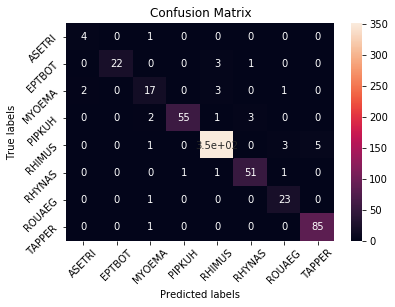

In [16]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [17]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9514866979655712


In [18]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       0.67      0.80      0.73         5
      EPTBOT       1.00      0.85      0.92        26
      MYOEMA       0.74      0.74      0.74        23
      PIPKUH       0.98      0.90      0.94        61
      RHIMUS       0.98      0.97      0.98       360
      RHYNAS       0.93      0.94      0.94        54
      ROUAEG       0.82      0.96      0.88        24
      TAPPER       0.94      0.99      0.97        86

    accuracy                           0.95       639
   macro avg       0.88      0.89      0.89       639
weighted avg       0.95      0.95      0.95       639



In [19]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:
0.9944894051335614 (macro)
0.9966741676792338 (weighted by prevalence)

One-vs-Rest ROC AUC scores:
0.9968811857079869 (macro)
0.9973380628046101 (weighted by prevalence)


/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


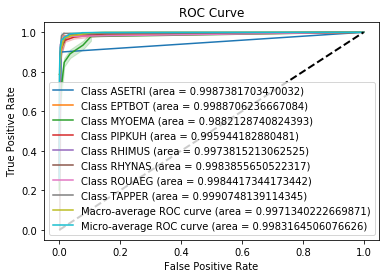

In [20]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

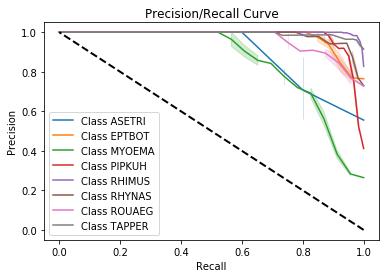

In [21]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 8
rec = [0] * 8
for i in range(8):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getSpecies(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)